In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import math

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
#v=list(os.walk('./zdjs/light_set'))
v=list(os.walk('./zdjs/pdfs'))

f=[0]*200
j=0
for i in range(0, len(v)):
    for x in (v[i][2]):
        f[j]=cv.imread(v[i][0]+'/'+x, cv.IMREAD_GRAYSCALE)
        j+=1
        
def grave(img, biw=0):
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    if (biw==1):
        ax.imshow(img, cmap='Greys',  interpolation='nearest')
    else:
        ax.imshow(img)
    plt.show()

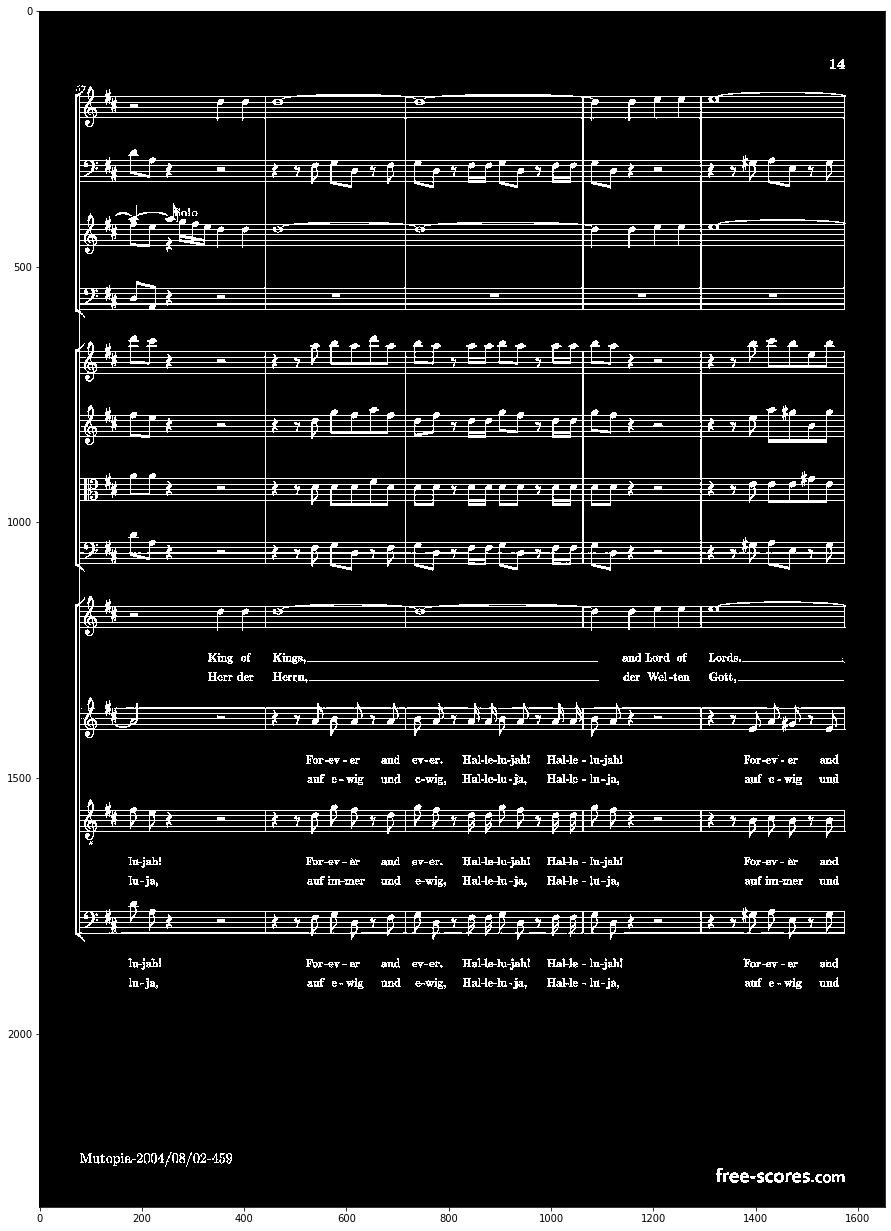

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(167.9434554973822, 2.056544502617801, 50, 1597)
(177.96399706098458, 1.946362968405584, 50, 1594)
(188.8792866941015, 2.5315500685871055, 50, 1594)
(198.96767676767678, 1.9407407407407407, 50, 1594)
(209.00200267022697, 1.9626168224299065, 50, 1594)
(291.98118668596237, 1.9522431259044863, 50, 1594)
(302.95983606557377, 1.9336065573770491, 50, 1594)
(312.9650974025974, 1.9277597402597402, 50, 1594)
(323.55916473317865, 2.1361175560711523, 50, 1594)
(333.96444780635403, 1.938729198184569, 50, 1594)
(416.94690265486724, 2.0763274336283186, 50, 1596)
(426.7792012057272, 1.8643556895252449, 50, 1594)
(437.97024221453285, 1.9397923875432526, 50, 1594)
(447.9676511954993, 1.9416315049226442, 50, 1594)
(458.82332402234636, 2.702513966480447, 50, 1594)
(541.9655405405406, 1.9493243243243243, 50, 1594)
(551.9752124645893, 1.9419263456090652, 50, 1594)
(561.9530685920578, 1.924187725631769, 50, 1594)
(572.96570275722

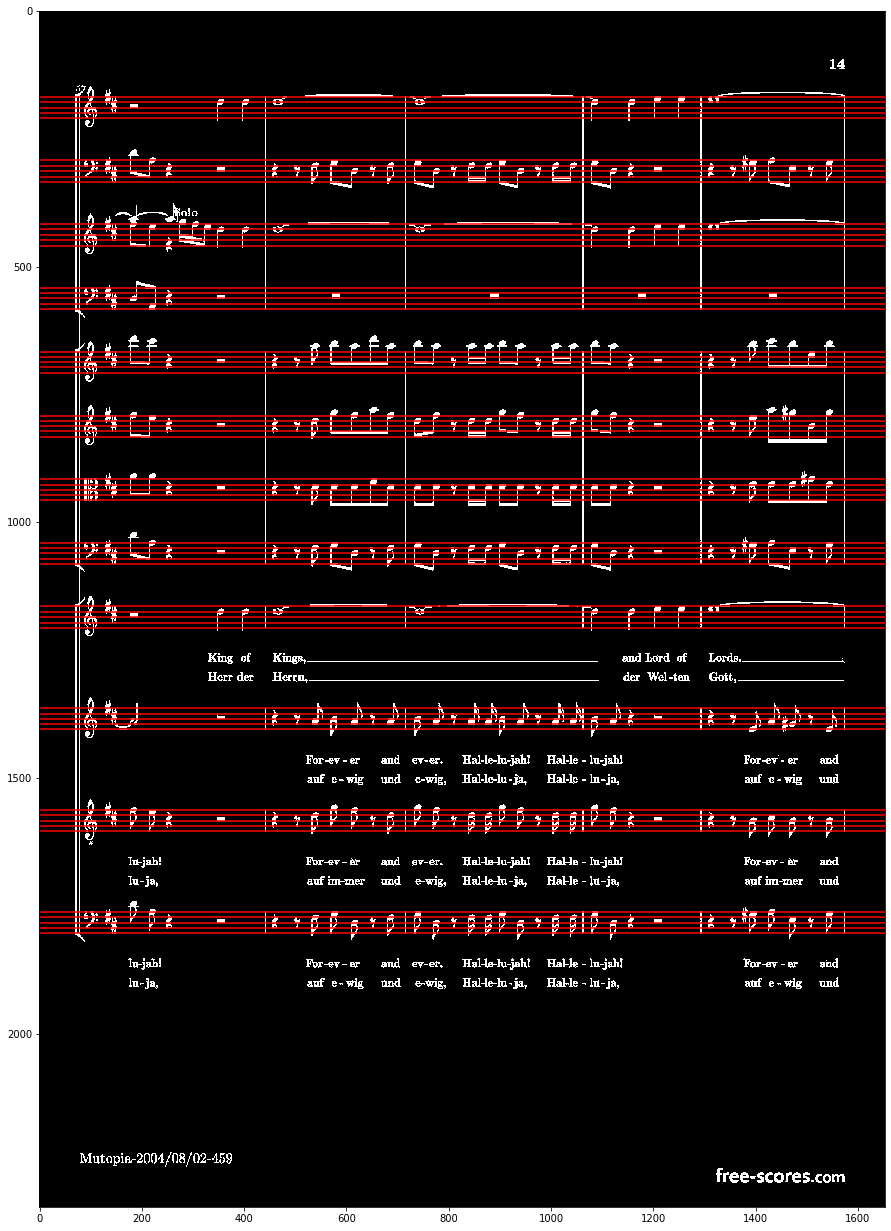

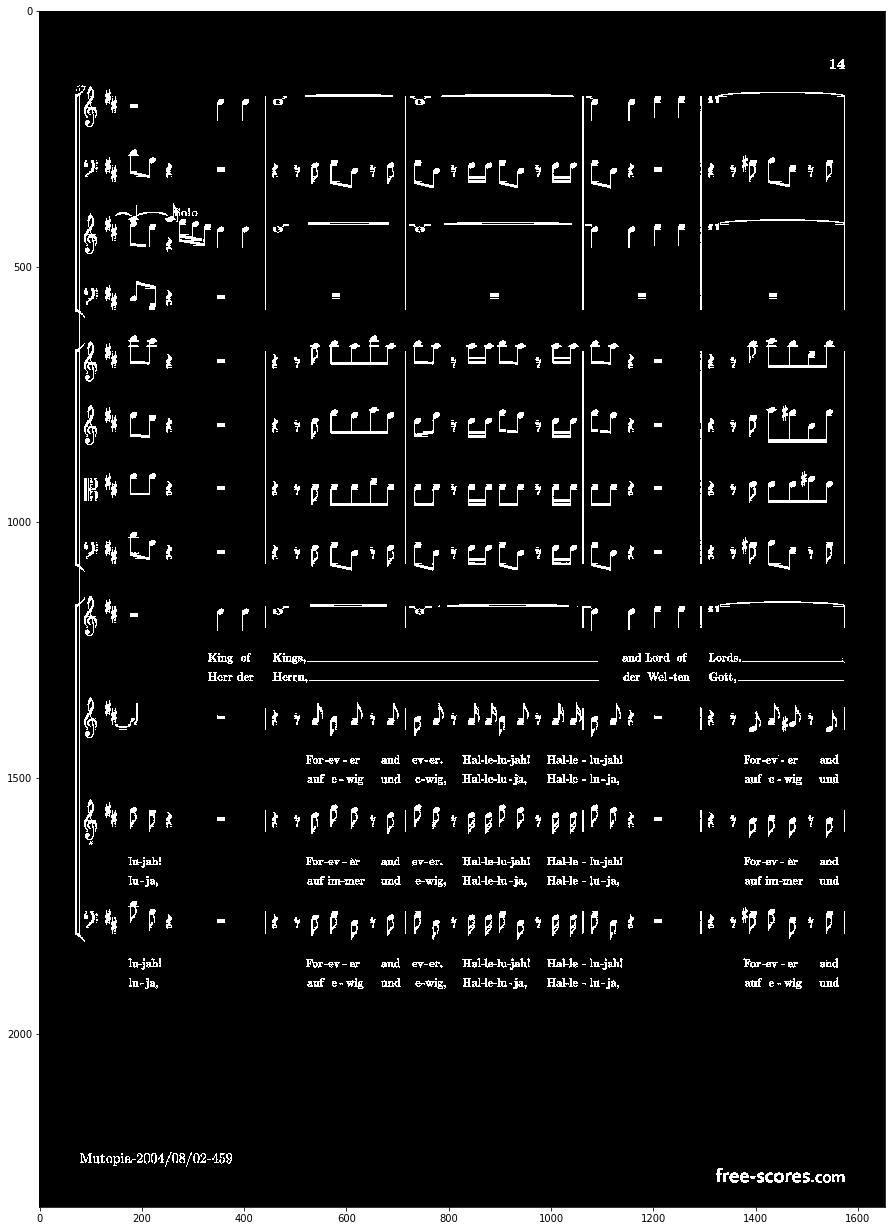

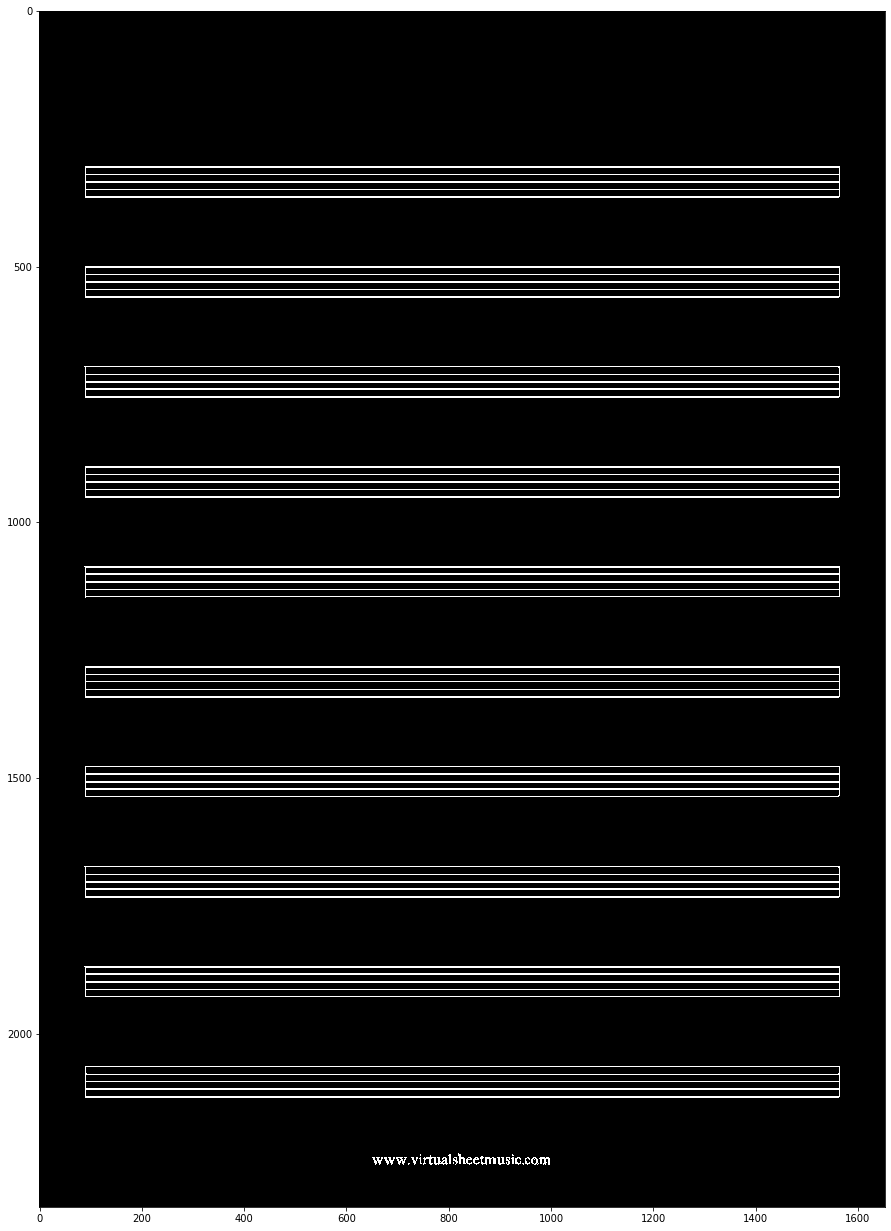

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(306.9186507936508, 2.9186507936507935, 69, 1585)
(320.91859695565853, 2.9185969556585043, 69, 1585)
(335.9186507936508, 2.9186507936507935, 69, 1585)
(350.9186507936508, 2.9186507936507935, 69, 1585)
(364.91859695565853, 2.9185969556585043, 69, 1585)
(501.91738268341044, 2.917382683410443, 68, 1585)
(516.9186507936508, 2.9186507936507935, 69, 1585)
(530.9186507936508, 2.9186507936507935, 69, 1585)
(545.9186507936508, 2.9186507936507935, 69, 1585)
(560.917328042328, 2.919973544973545, 69, 1585)
(696.9172733289213, 2.9172733289212442, 68, 1585)
(711.9186507936508, 2.9186507936507935, 69, 1585)
(726.9186507936508, 2.9186507936507935, 69, 1585)
(740.9186507936508, 2.9186507936507935, 69, 1585)
(755.9186507936508, 2.9186507936507935, 69, 1585)
(892.9173826834104, 2.917382683410443, 68, 1585)
(907.9186507936508, 2.9186507936507935, 69, 1585)
(922.9186507936508, 2.9186507936507935, 69, 1585)
(936.9185969556585, 2.

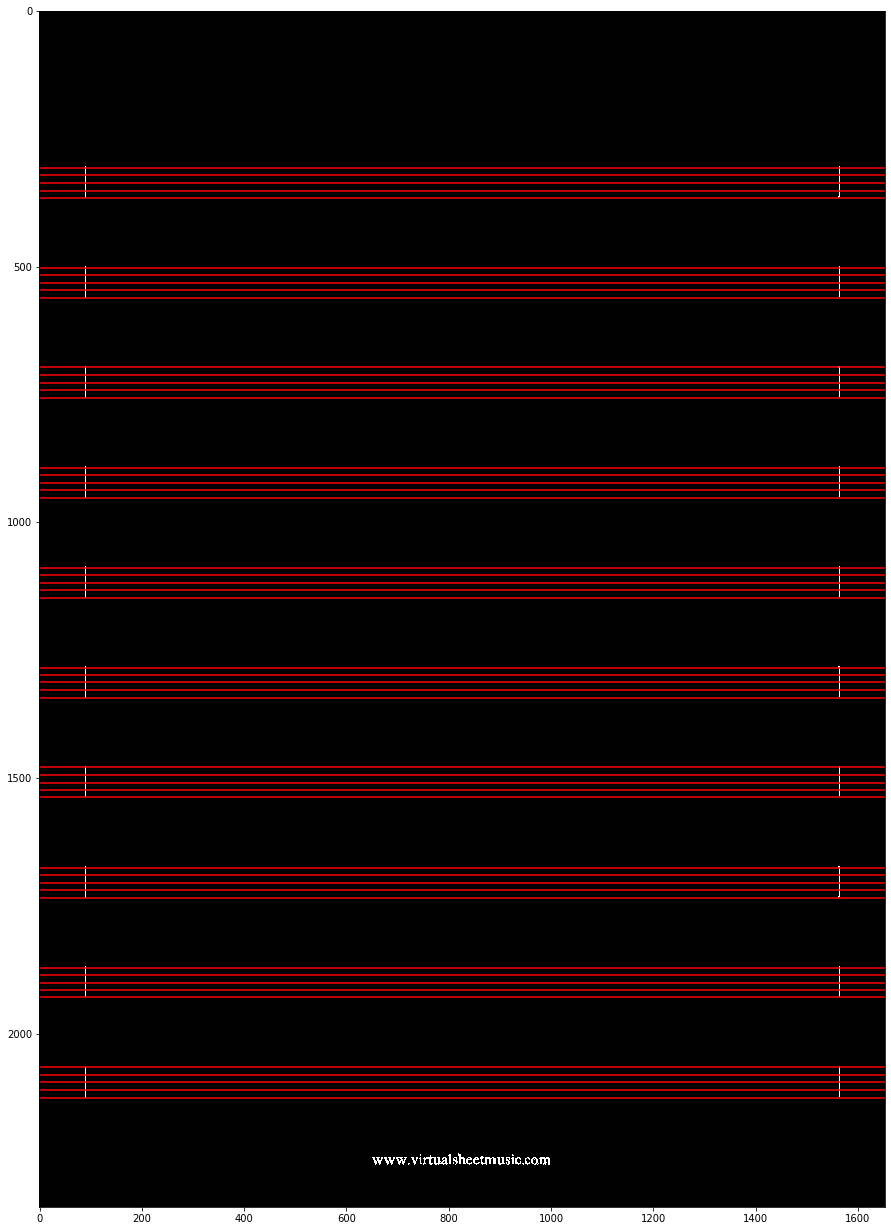

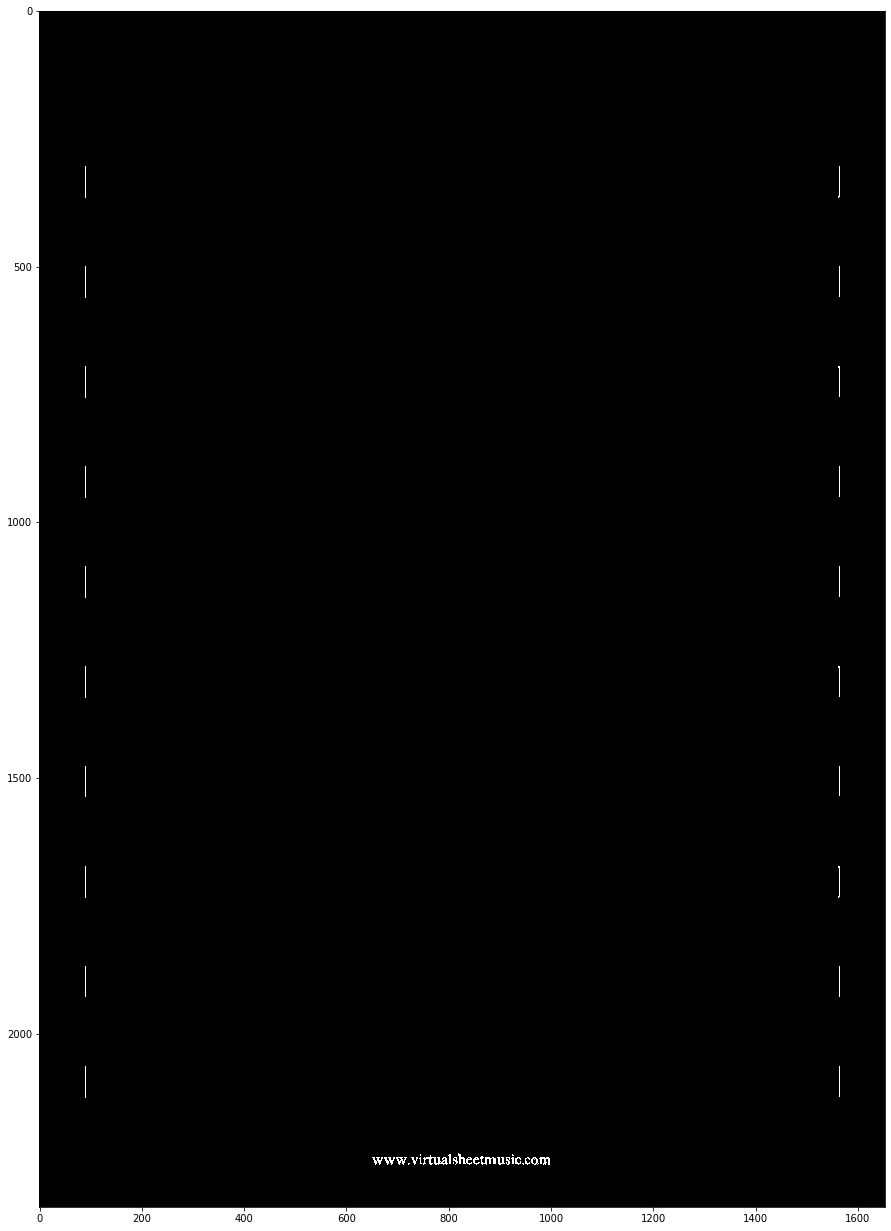

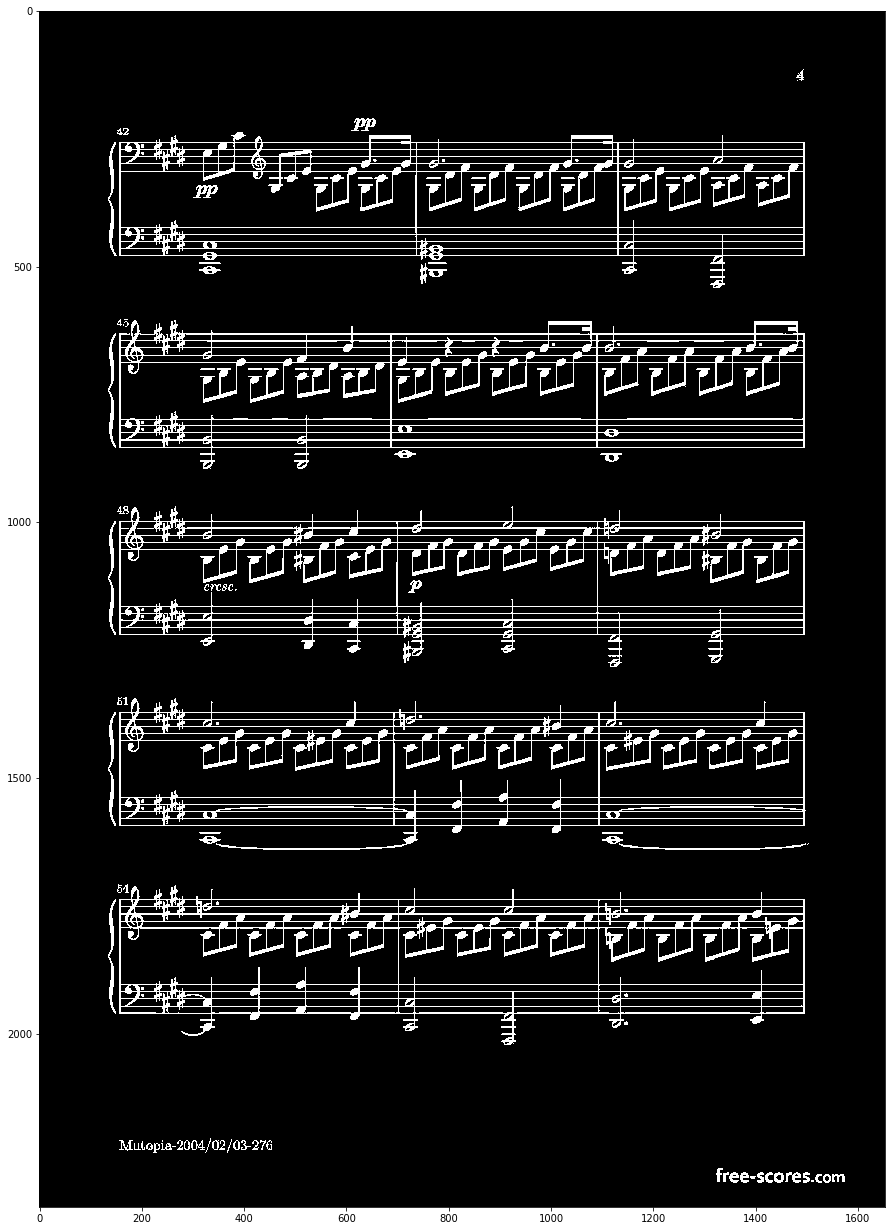

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(257.2779552715655, 2.0838658146964857, 127, 1516)
(270.9568403908795, 1.9185667752442996, 120, 1516)
(284.9624183006536, 1.9207516339869282, 117, 1516)
(298.93603603603606, 1.9216216216216215, 117, 1516)
(312.9579045837231, 1.9055191768007484, 118, 1516)
(424.8112359550562, 2.847191011235955, 118, 1516)
(436.97184170471843, 1.9254185692541856, 117, 1516)
(450.9688473520249, 1.9213395638629283, 117, 1516)
(464.9422776911076, 1.93603744149766, 120, 1516)
(478.97085889570553, 1.9394171779141105, 127, 1516)
(632.819305019305, 2.827027027027027, 127, 1516)
(645.8480124707717, 2.3655494933749024, 120, 1516)
(658.9506607929516, 1.905726872246696, 117, 1516)
(672.9557913351017, 1.9089301503094607, 117, 1516)
(686.9397482014389, 1.9262589928057554, 118, 1516)
(798.0435108777194, 2.522880720180045, 118, 1516)
(810.9661016949152, 1.9229583975346687, 117, 1516)
(824.952492211838, 1.9244548286604362, 117, 1516)
(838.955

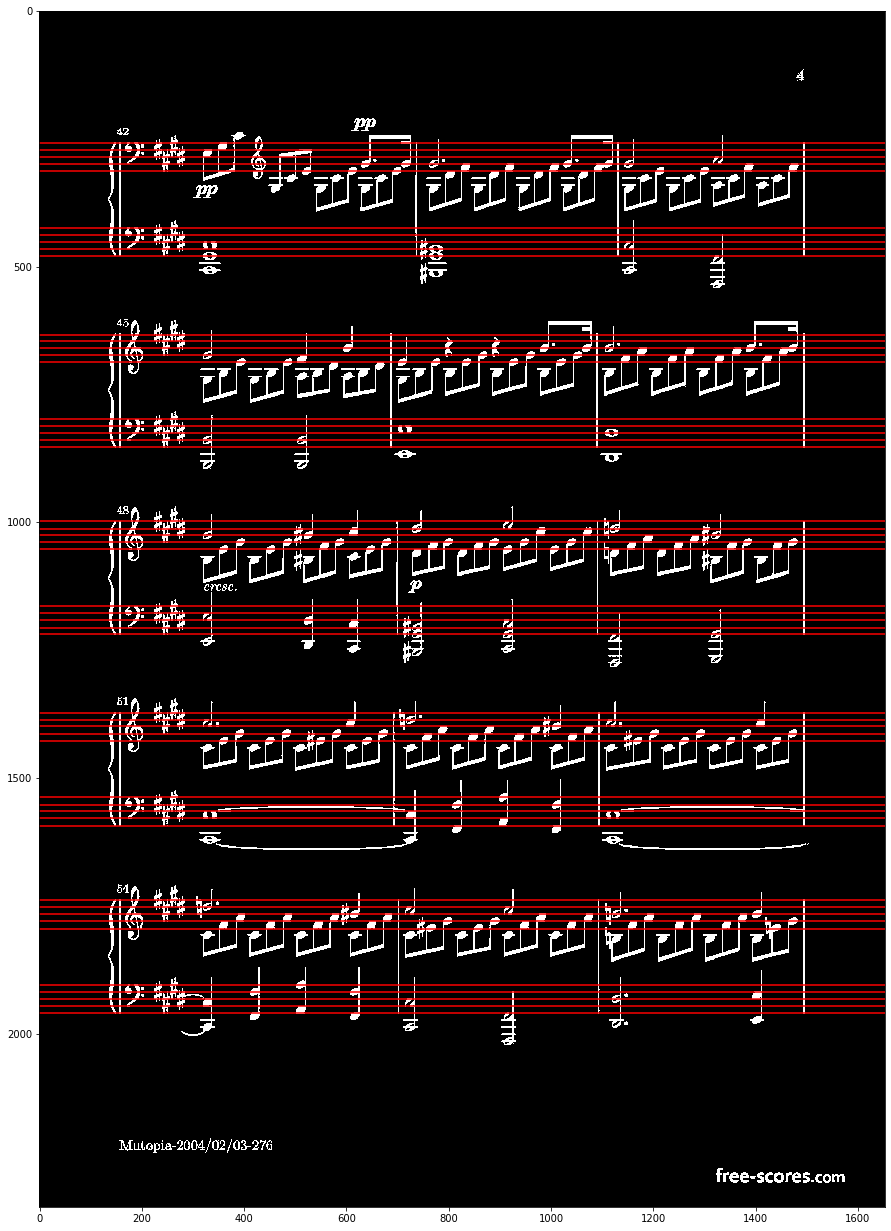

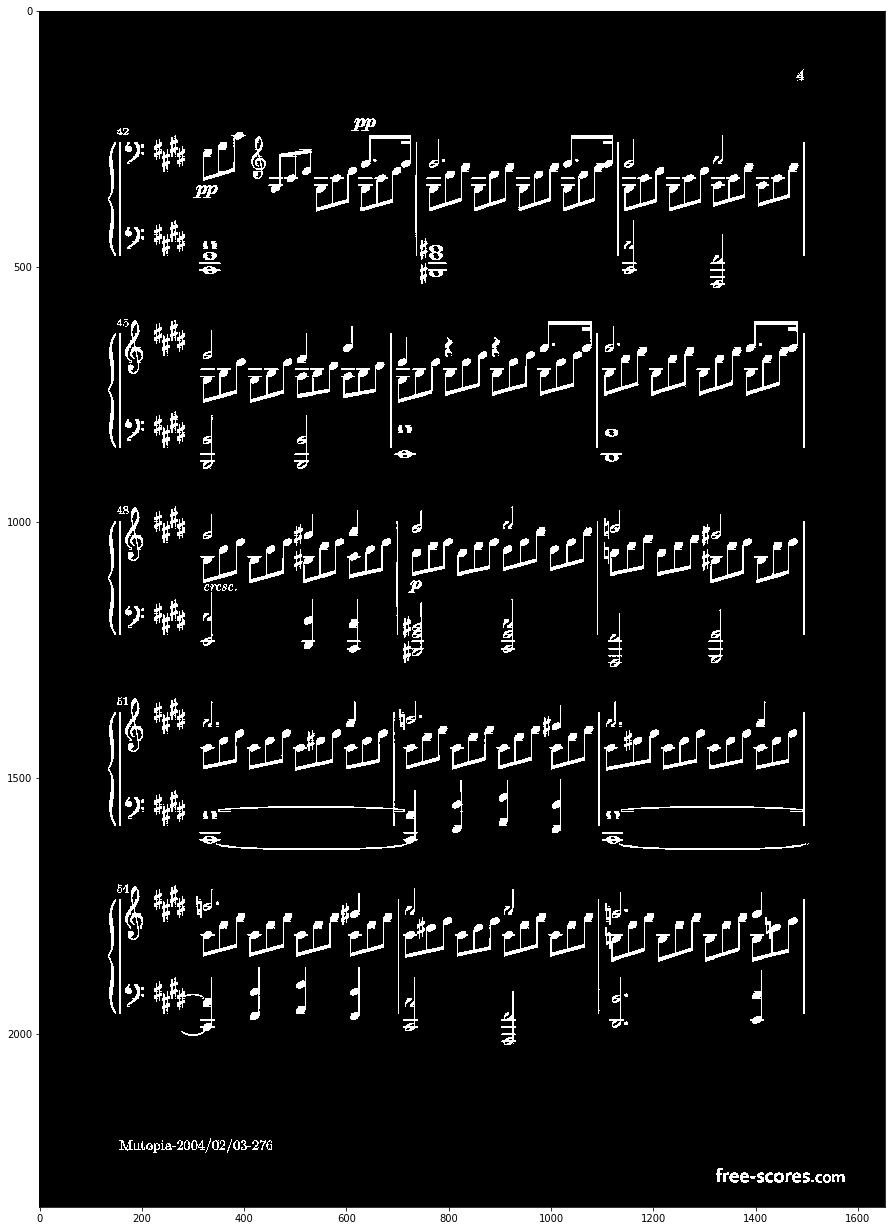

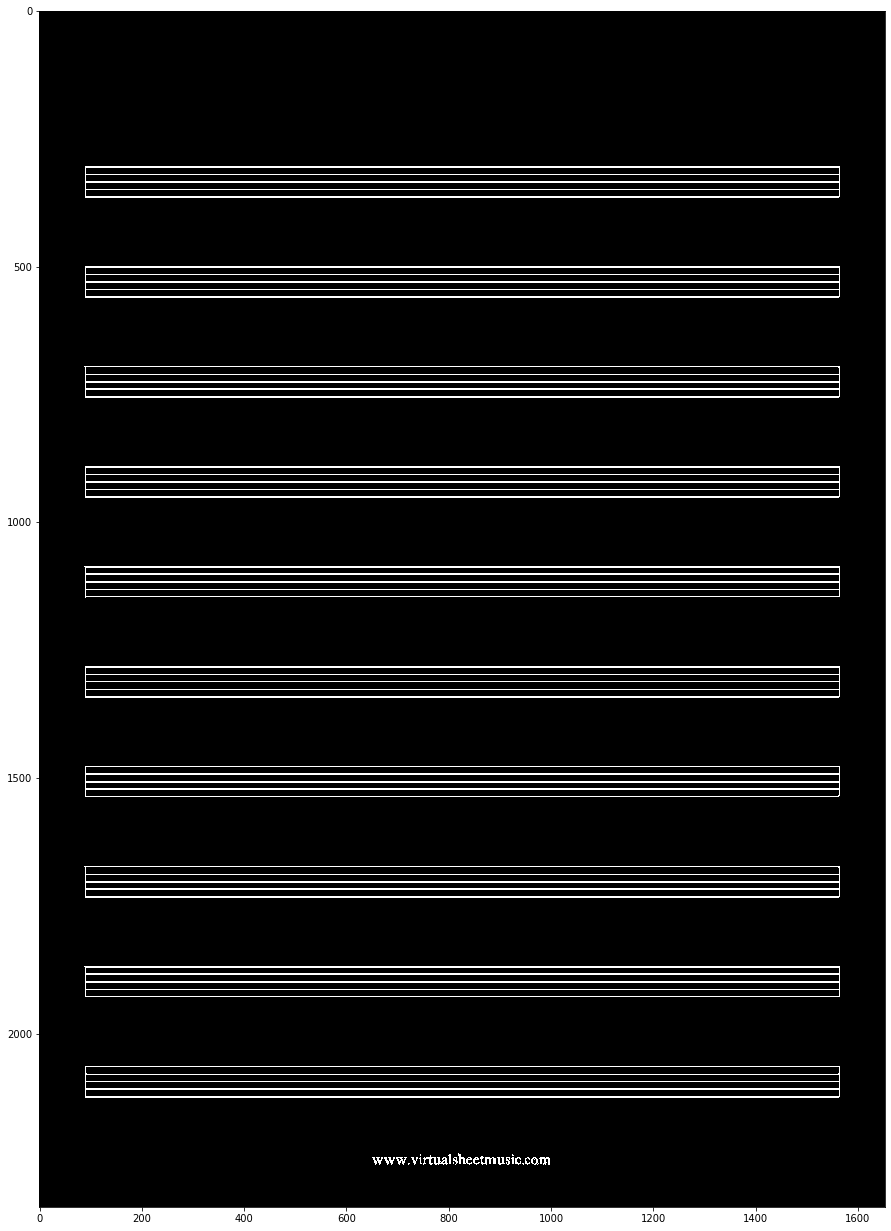

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(306.9186507936508, 2.9186507936507935, 69, 1585)
(320.91859695565853, 2.9185969556585043, 69, 1585)
(335.9186507936508, 2.9186507936507935, 69, 1585)
(350.9186507936508, 2.9186507936507935, 69, 1585)
(364.91859695565853, 2.9185969556585043, 69, 1585)
(501.91738268341044, 2.917382683410443, 68, 1585)
(516.9186507936508, 2.9186507936507935, 69, 1585)
(530.9186507936508, 2.9186507936507935, 69, 1585)
(545.9186507936508, 2.9186507936507935, 69, 1585)
(560.917328042328, 2.919973544973545, 69, 1585)
(696.9172733289213, 2.9172733289212442, 68, 1585)
(711.9186507936508, 2.9186507936507935, 69, 1585)
(726.9186507936508, 2.9186507936507935, 69, 1585)
(740.9186507936508, 2.9186507936507935, 69, 1585)
(755.9186507936508, 2.9186507936507935, 69, 1585)
(892.9173826834104, 2.917382683410443, 68, 1585)
(907.9186507936508, 2.9186507936507935, 69, 1585)
(922.9186507936508, 2.9186507936507935, 69, 1585)
(936.9185969556585, 2.

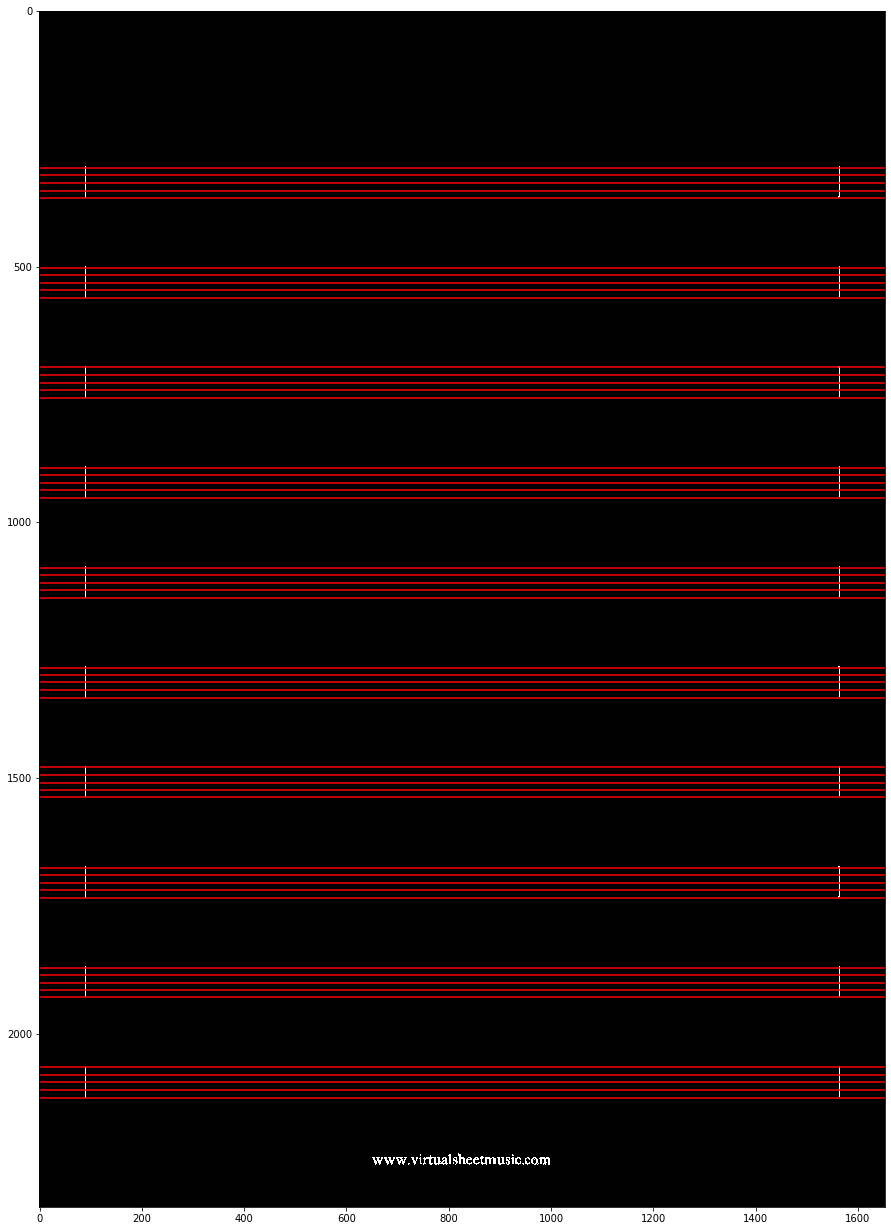

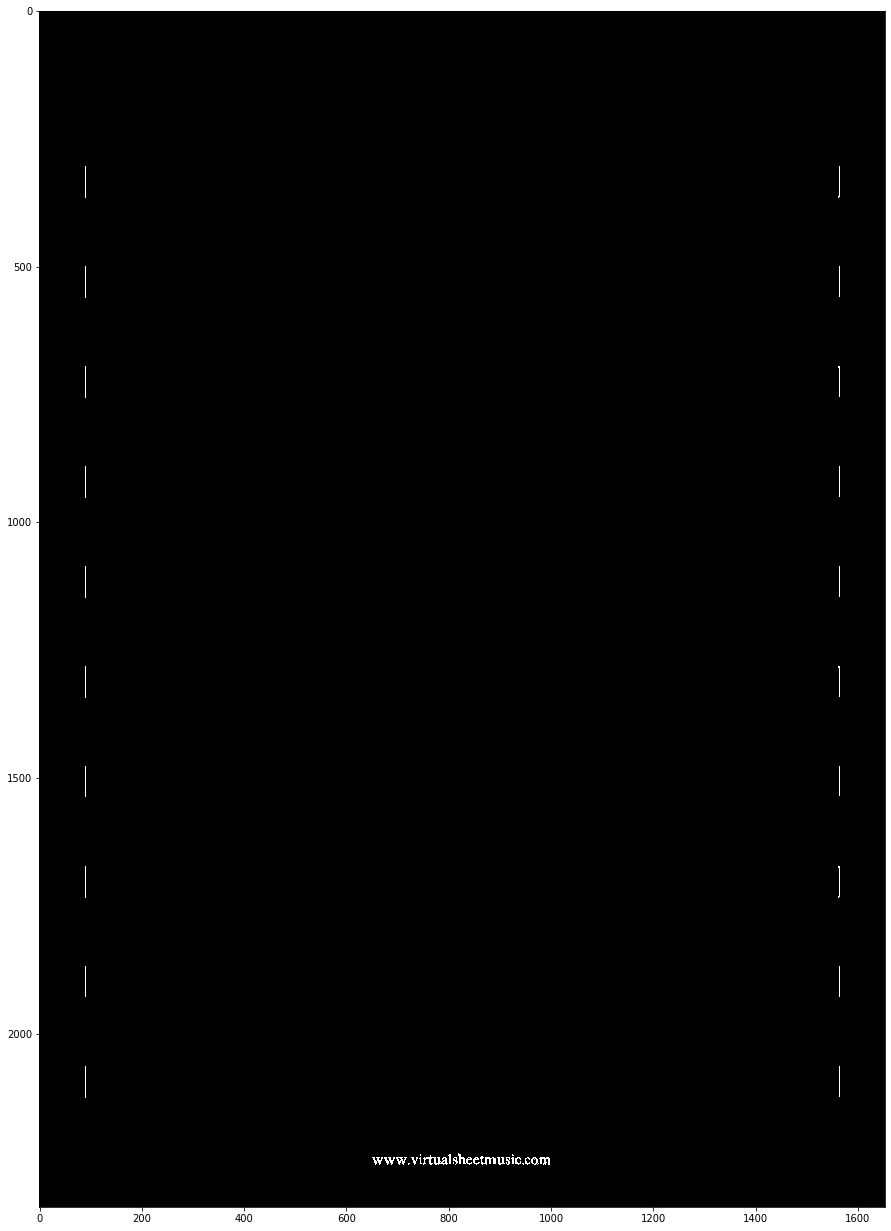

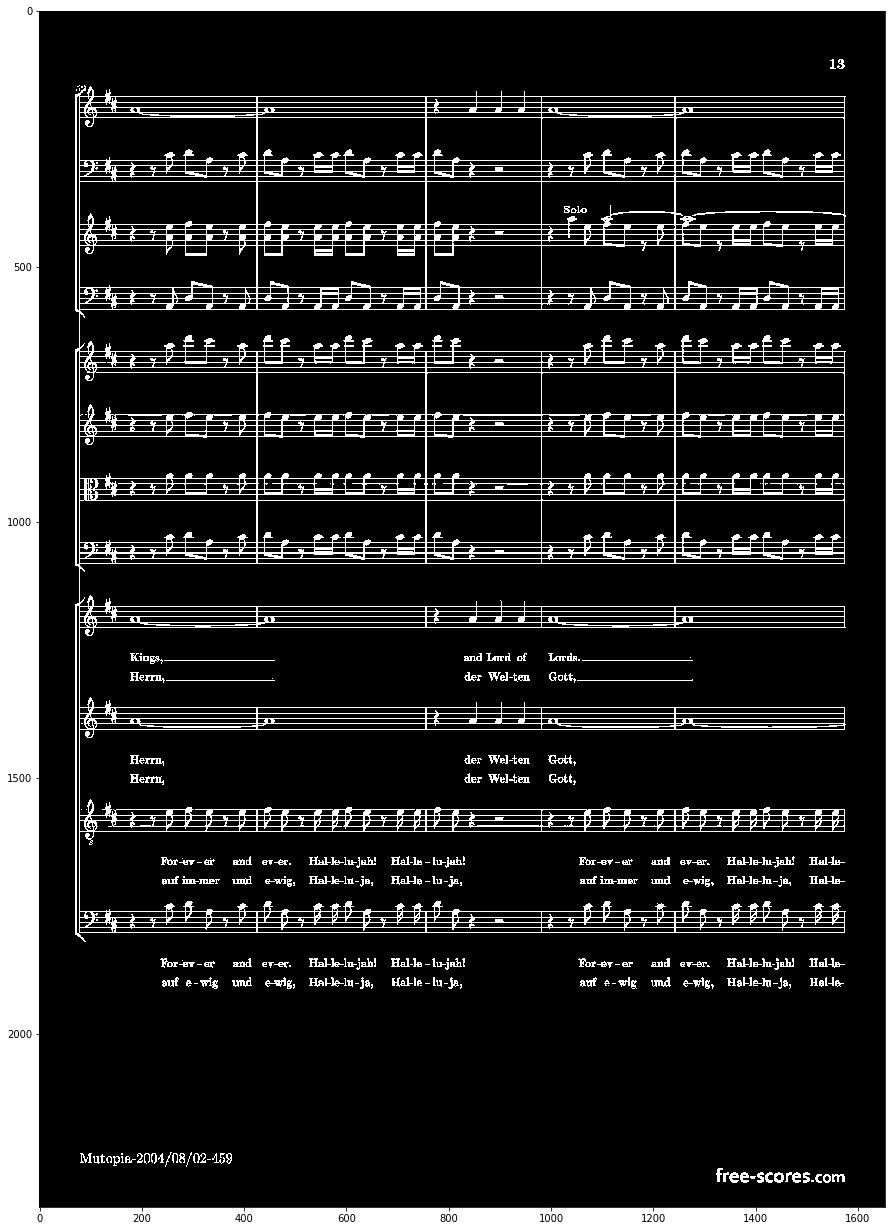

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(167.97108271687964, 1.944855413584398, 50, 1595)
(177.96951219512195, 1.9390243902439024, 50, 1594)
(188.51300578034682, 2.425578034682081, 50, 1594)
(198.94082397003746, 1.952808988764045, 50, 1594)
(208.96486718080547, 1.9331619537275064, 50, 1594)
(291.94677661169413, 1.81784107946027, 50, 1594)
(302.9587542087542, 1.9368686868686869, 50, 1594)
(312.96351730589333, 1.9186155285313378, 50, 1594)
(323.7671875, 2.0953125, 50, 1594)
(333.9690382081686, 1.9433465085639, 50, 1594)
(416.96120689655174, 1.925, 50, 1594)
(426.9601018675722, 1.9244482173174873, 50, 1594)
(437.9608510638298, 1.9259574468085106, 50, 1594)
(447.9548218940052, 1.9270199826238055, 50, 1594)
(457.93833992094864, 1.991304347826087, 50, 1594)
(540.9718909710392, 1.9310051107325383, 50, 1594)
(551.9617622610141, 1.9301745635910224, 50, 1594)
(561.9601328903655, 1.9318936877076411, 50, 1594)
(571.9487394957983, 1.8739495798319328, 50, 1594)

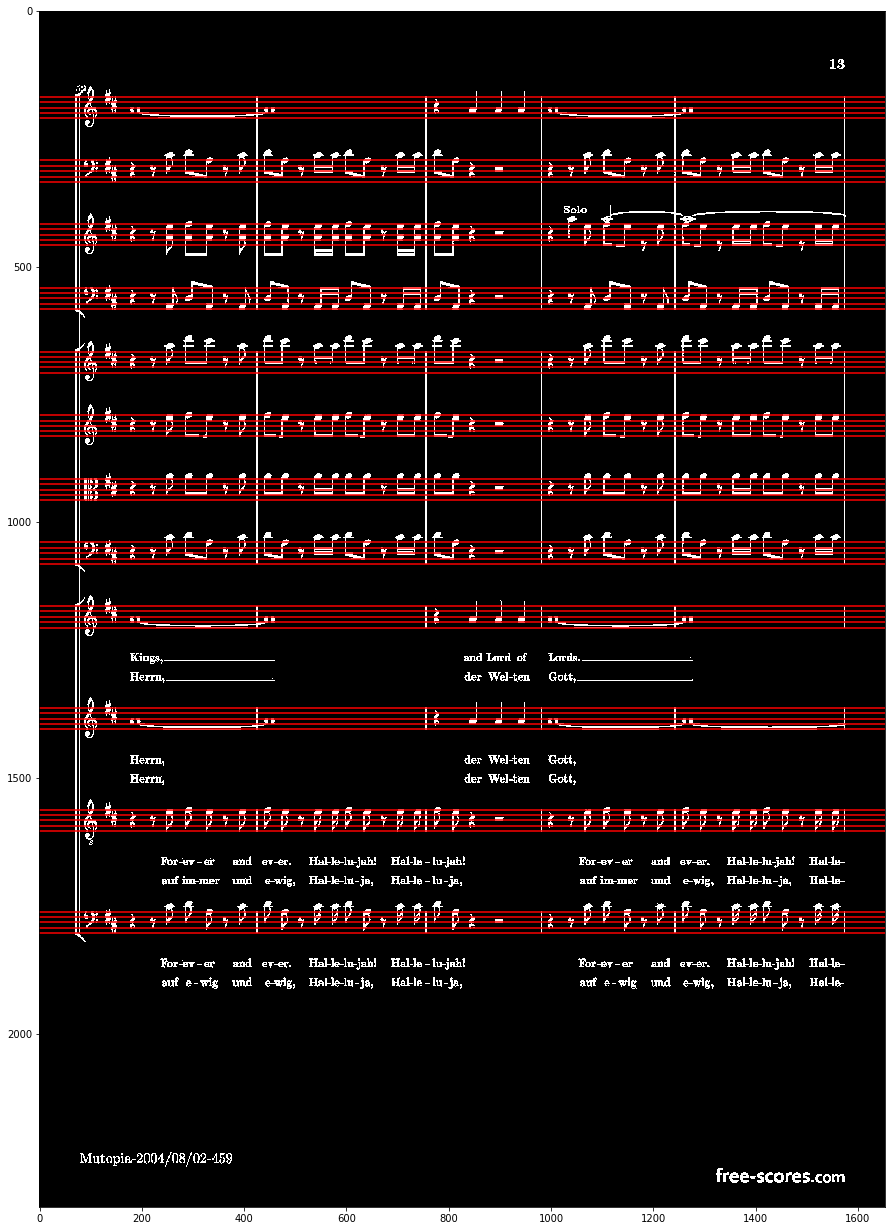

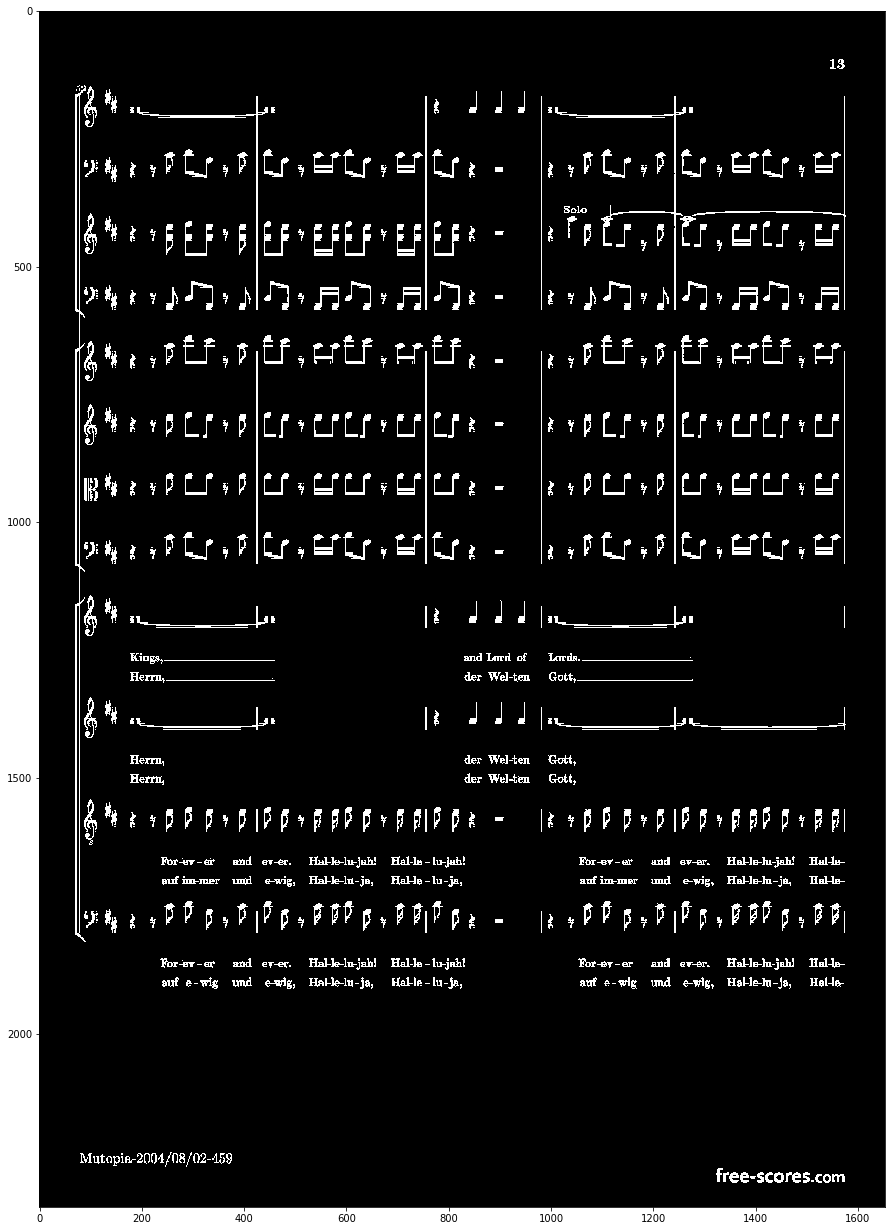

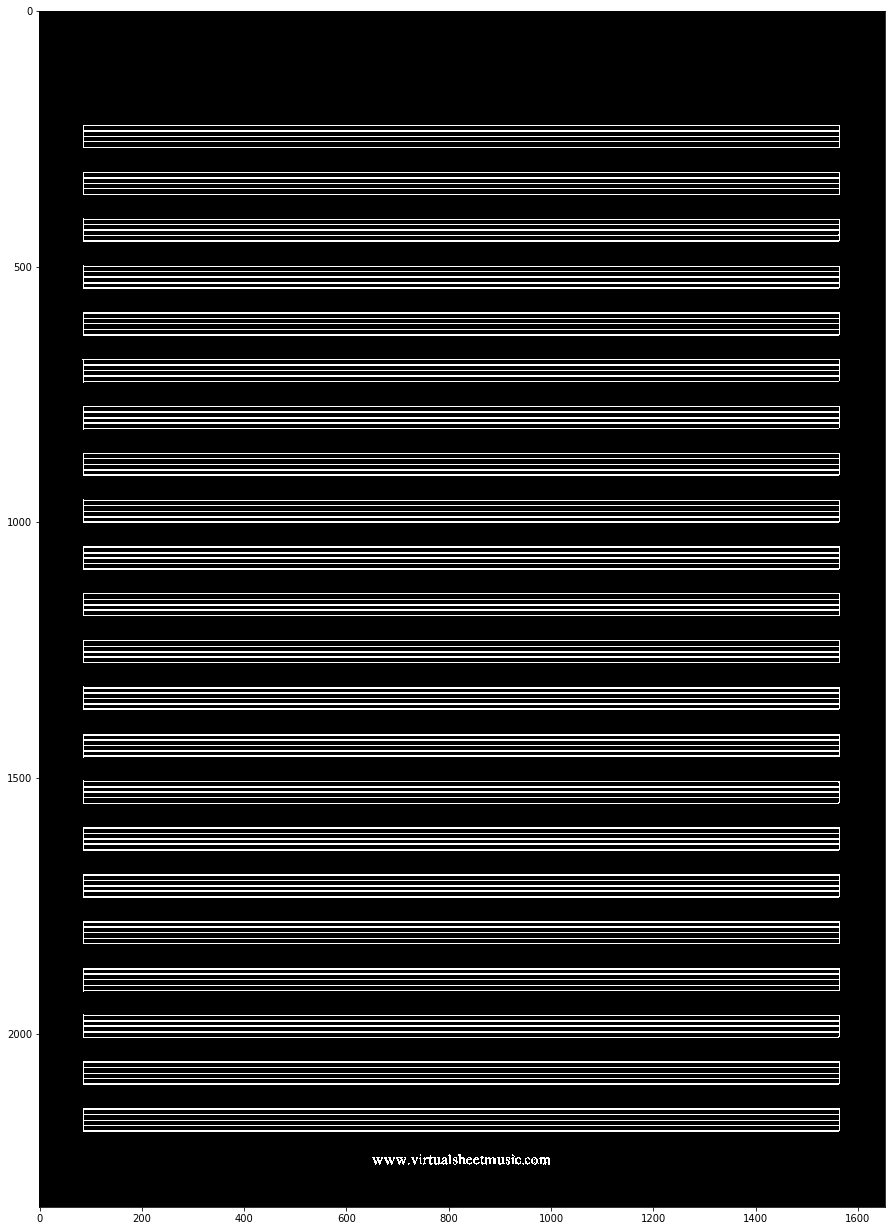

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(224.91754617414247, 2.91754617414248, 65, 1585)
(235.9188654353562, 2.9188654353562007, 66, 1585)
(246.9188654353562, 2.9188654353562007, 66, 1585)
(256.9188118811881, 2.9188118811881187, 66, 1585)
(267.91694133157546, 2.918259723137772, 65, 1585)
(316.9189189189189, 2.918259723137772, 65, 1585)
(327.9188654353562, 2.9188654353562007, 66, 1585)
(338.9188654353562, 2.9188654353562007, 66, 1585)
(348.9188654353562, 2.9188654353562007, 66, 1585)
(359.91628213579435, 2.918259723137772, 65, 1585)
(408.9176005273566, 2.918259723137772, 65, 1585)
(418.9188654353562, 2.9188654353562007, 66, 1585)
(429.9188654353562, 2.9188654353562007, 66, 1585)
(440.91820580474933, 2.9195250659630605, 66, 1585)
(450.9189189189189, 2.918259723137772, 65, 1585)
(500.9188654353562, 2.9188654353562007, 65, 1585)
(510.9188654353562, 2.9188654353562007, 66, 1585)
(521.9188654353562, 2.9188654353562007, 66, 1585)
(532.9188654353562, 2.91

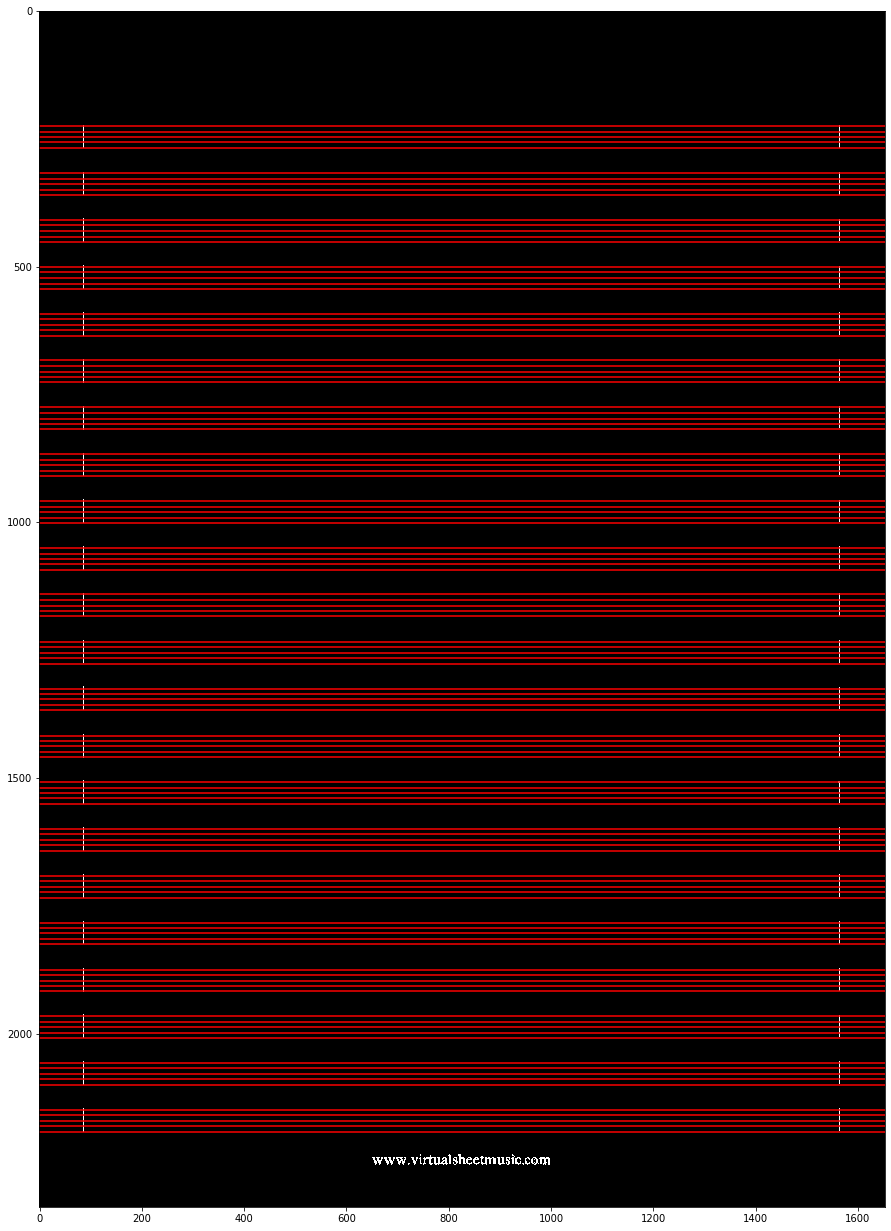

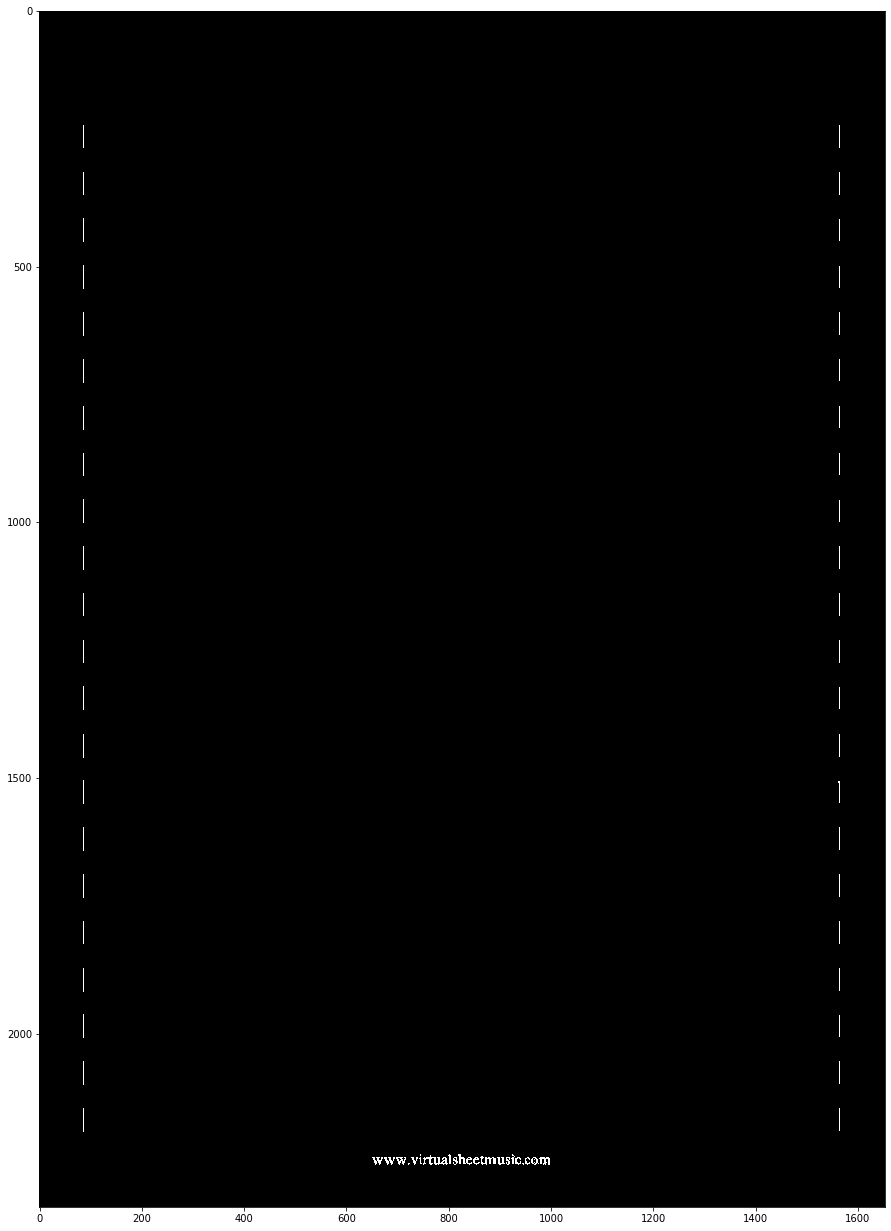

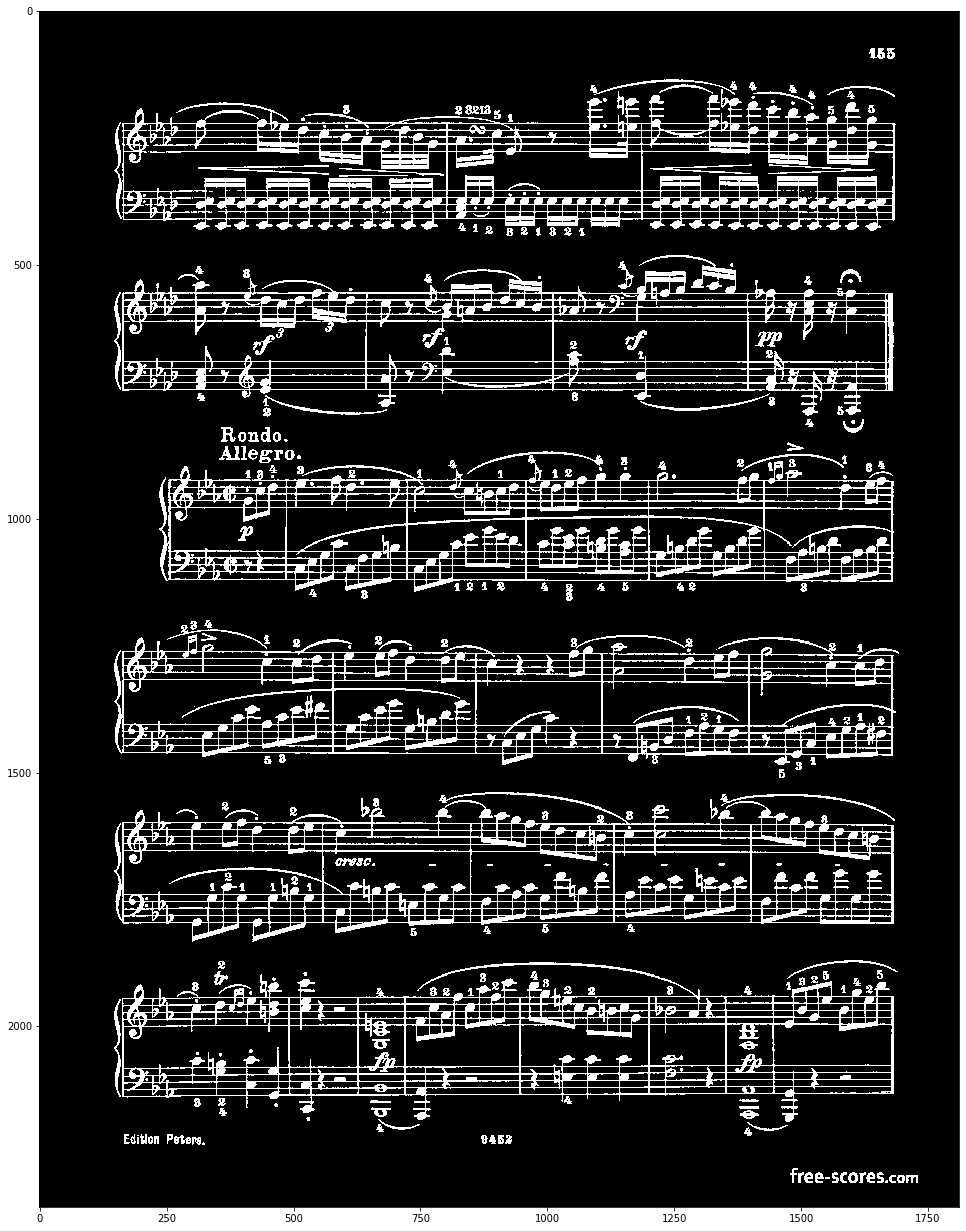

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(221.62733446519525, 2.396434634974533, 137, 1705)
(235.4704391891892, 2.266891891891892, 131, 1705)
(249.90075062552125, 2.1684737281067554, 129, 1705)
(262.1979256698358, 2.1469317199654276, 131, 1705)
(276.54652137468565, 2.1391450125733447, 134, 1705)
(355.44444444444446, 1.9606625258799173, 133, 1705)
(369.8132733408324, 2.061867266591676, 131, 1705)
(382.614, 2.176, 131, 1704)
(395.98933901918974, 2.03909026297086, 134, 1704)
(410.2012578616352, 2.2696540880503147, 140, 1705)
(556.4991334488735, 2.5103986135181975, 137, 1701)
(570.502938706969, 2.4483627204030225, 131, 1701)
(584.7432675044884, 2.3563734290843805, 128, 1701)
(597.8269867549669, 2.3584437086092715, 129, 1701)
(611.9058025621703, 2.46345139412208, 132, 1702)
(692.0442726633872, 2.471539002108222, 132, 1701)
(705.8586080586081, 2.5597069597069595, 130, 1701)
(719.7691082802547, 2.5214968152866244, 130, 1701)
(733.0242914979757, 2.46882591

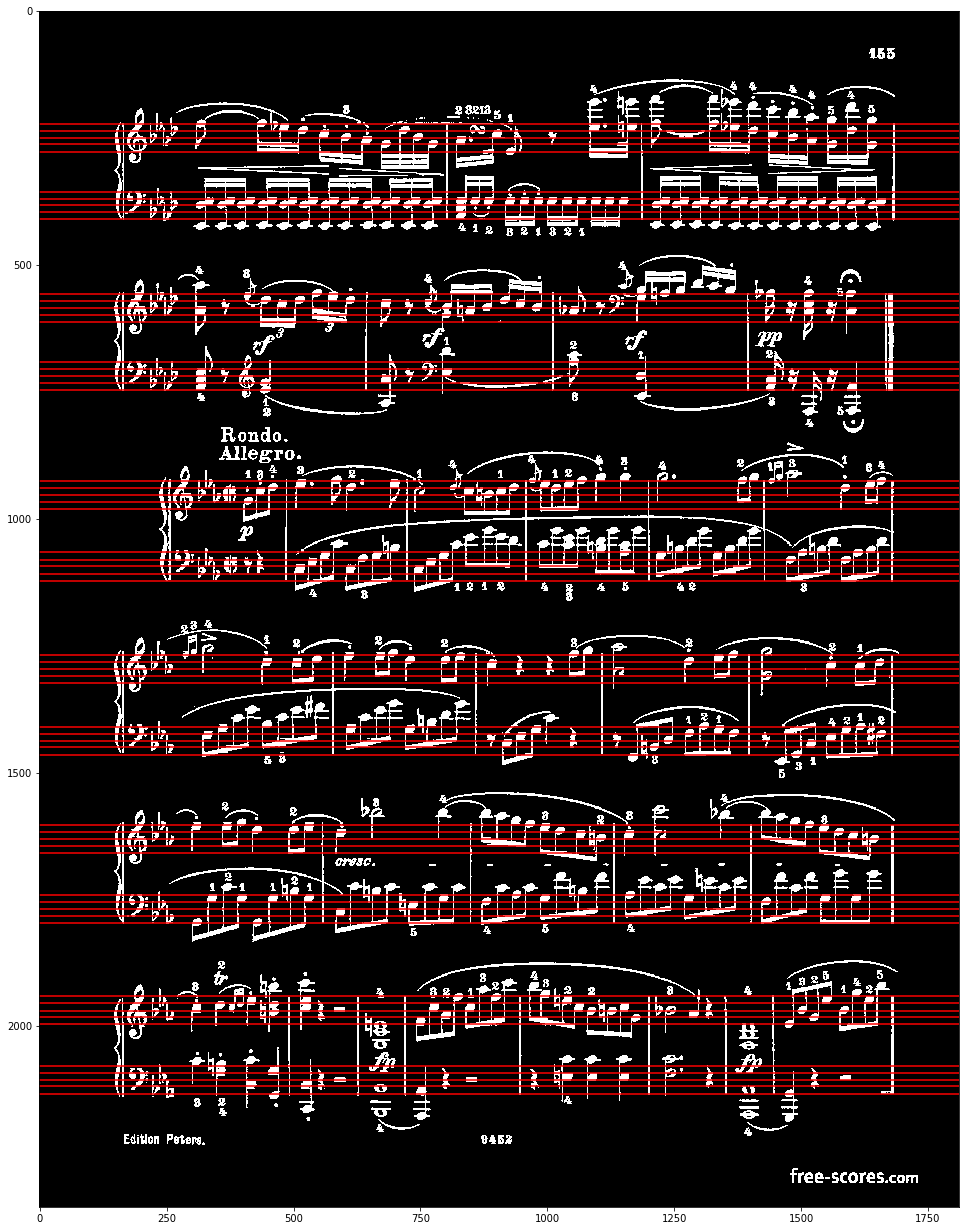

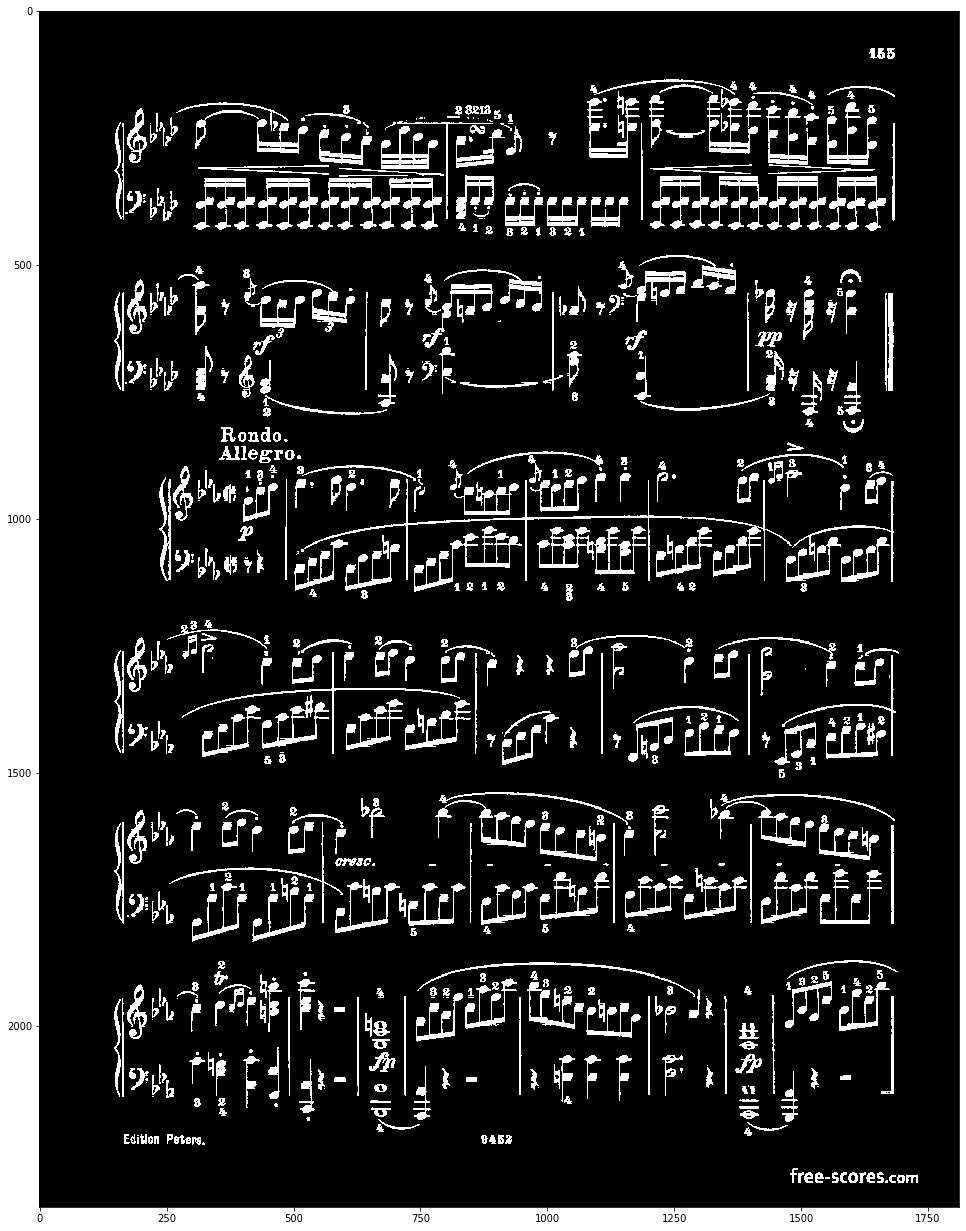

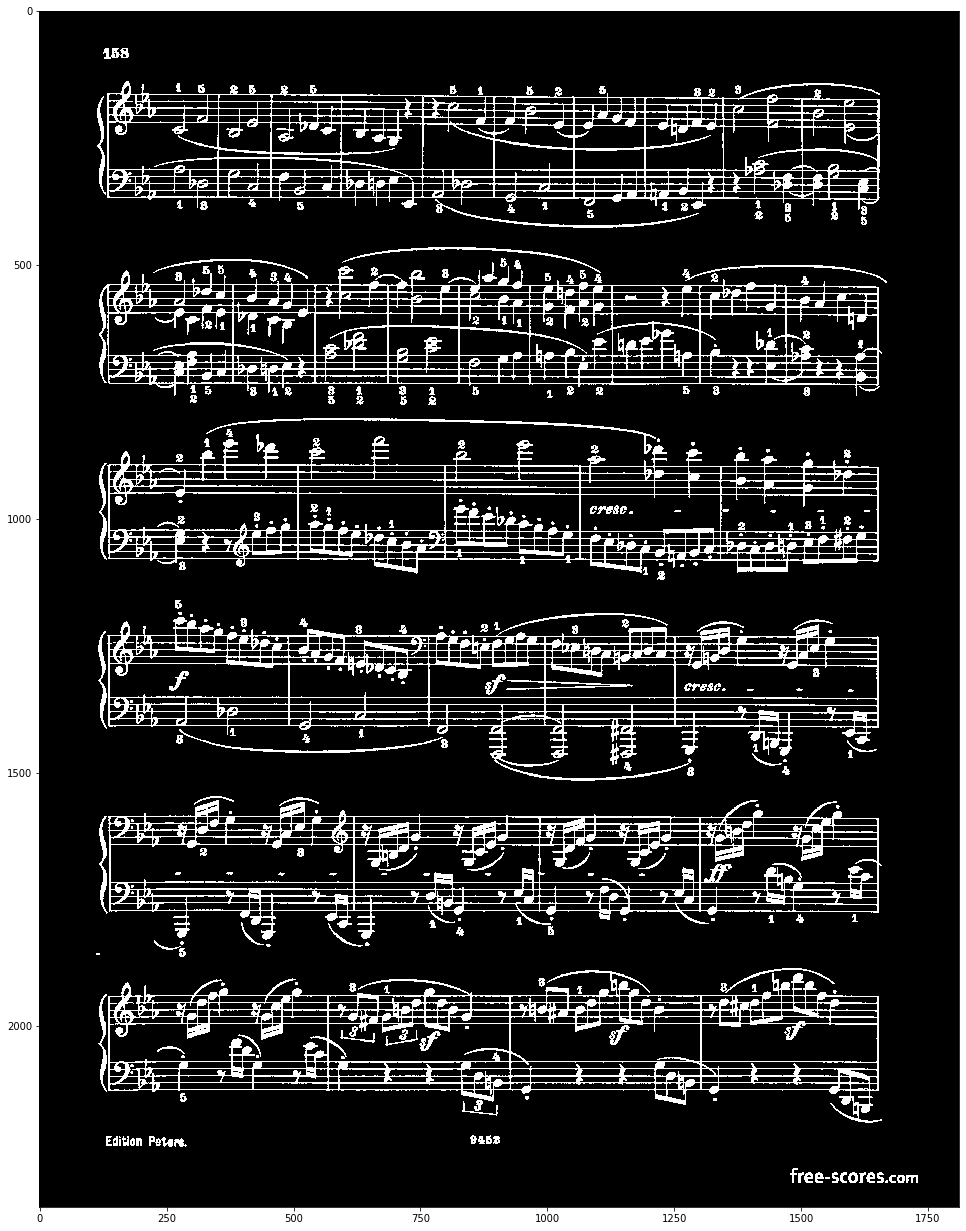

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(173.34259954921112, 2.580015026296018, 112, 1675)
(187.3355072463768, 2.5615942028985508, 100, 1675)
(201.31647509578545, 2.5187739463601533, 95, 1675)
(215.30943102104442, 2.4777864380358534, 95, 1675)
(228.35274261603377, 2.572995780590717, 97, 1675)
(316.8808095952024, 2.4887556221889056, 99, 1675)
(330.9859044635865, 2.485512920908379, 98, 1675)
(343.2050847457627, 2.314406779661017, 99, 1674)
(357.0961695191524, 2.6324368378158107, 104, 1674)
(370.9351432880845, 2.8529411764705883, 114, 1674)
(543.2385620915032, 2.4501633986928106, 112, 1674)
(556.6113902847571, 2.3936348408710217, 104, 1674)
(570.7139084507043, 2.461267605633803, 100, 1674)
(584.4875827814569, 2.4304635761589406, 99, 1674)
(599.271329746349, 2.550345887778632, 101, 1674)
(681.0519698239732, 2.3319362950544846, 102, 1673)
(694.2466887417219, 2.277317880794702, 99, 1673)
(707.7194826192401, 2.6022635408245756, 100, 1673)
(721.8469308469

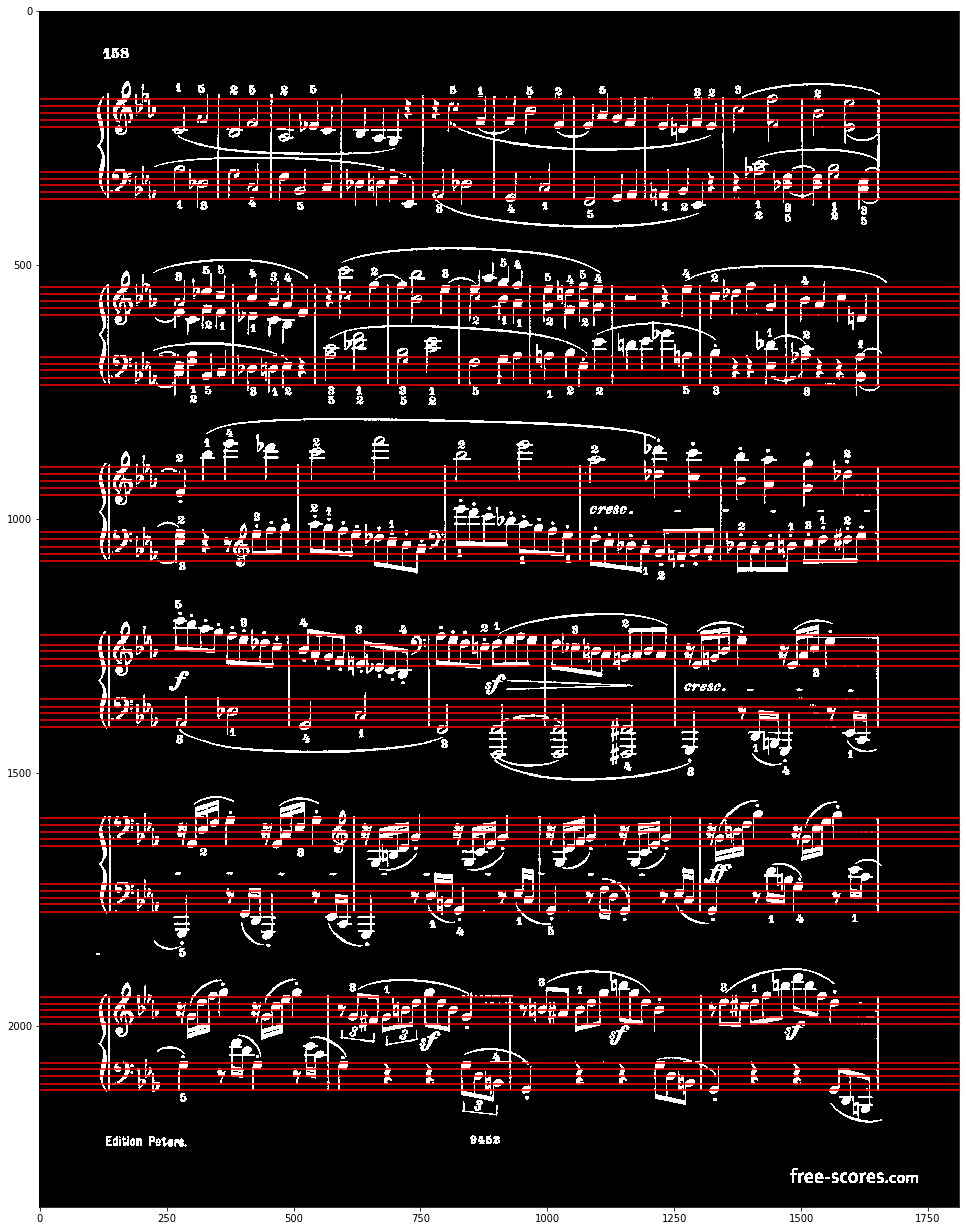

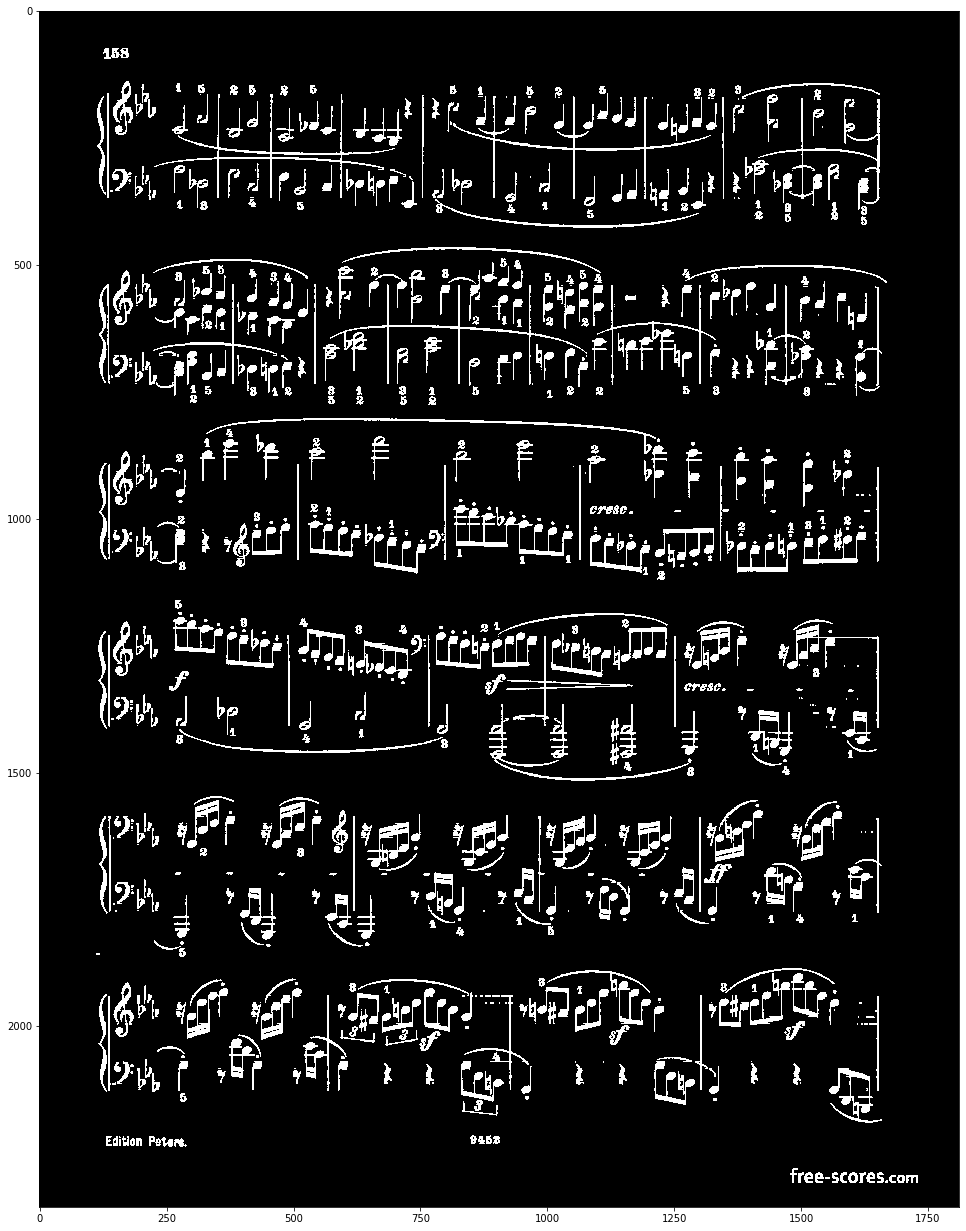

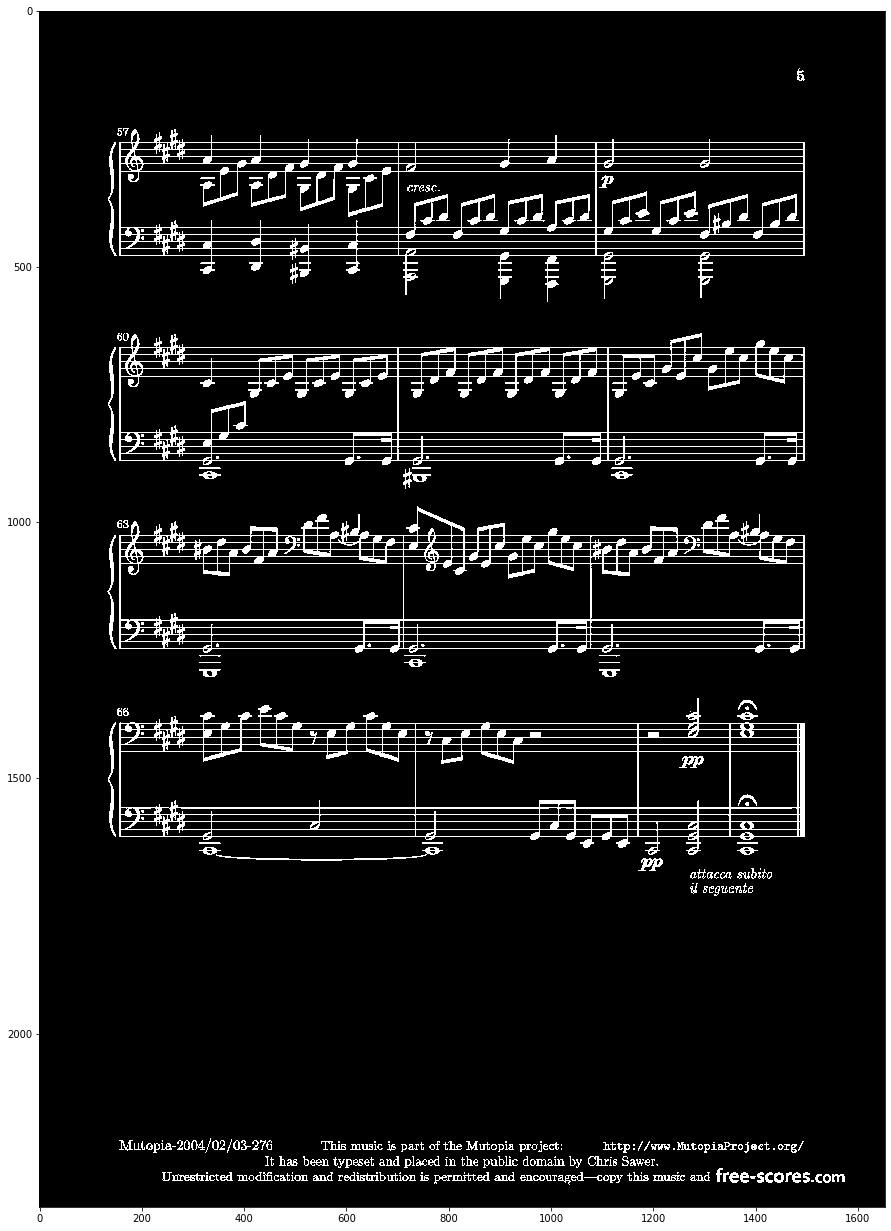

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(257.5617283950617, 2.2276234567901234, 127, 1516)
(270.9590733590734, 1.9204633204633204, 120, 1516)
(284.955905511811, 1.9173228346456692, 117, 1516)
(298.96010407632264, 1.914137033824805, 117, 1516)
(312.9394422310757, 1.9330677290836653, 118, 1516)
(424.63953488372096, 2.756644518272425, 118, 1516)
(436.96949152542373, 1.9194915254237288, 117, 1516)
(450.95573122529646, 1.915415019762846, 117, 1516)
(464.96354992076067, 1.927892234548336, 120, 1516)
(478.95023696682466, 1.9407582938388626, 127, 1516)
(659.5920608108108, 2.789695945945946, 127, 1516)
(671.9637362637362, 1.8967032967032966, 120, 1516)
(685.9505395683453, 1.9037769784172662, 117, 1516)
(699.9547359597653, 1.9145012573344509, 117, 1516)
(713.9343955014058, 1.9165885660731021, 118, 1516)
(825.0716228467815, 2.653671804170444, 118, 1516)
(837.958024691358, 1.9135802469135803, 117, 1516)
(851.957231726283, 1.9144634525660964, 117, 1516)
(865.9

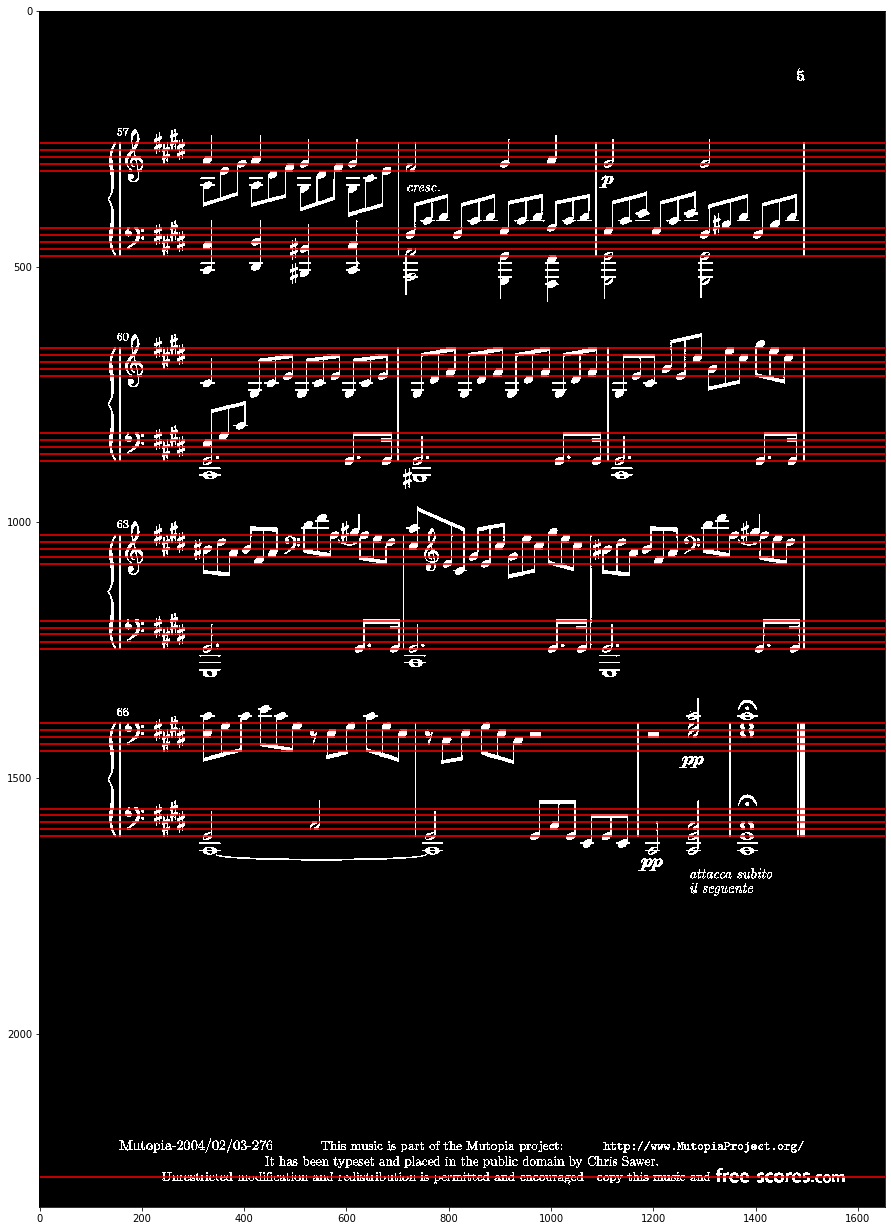

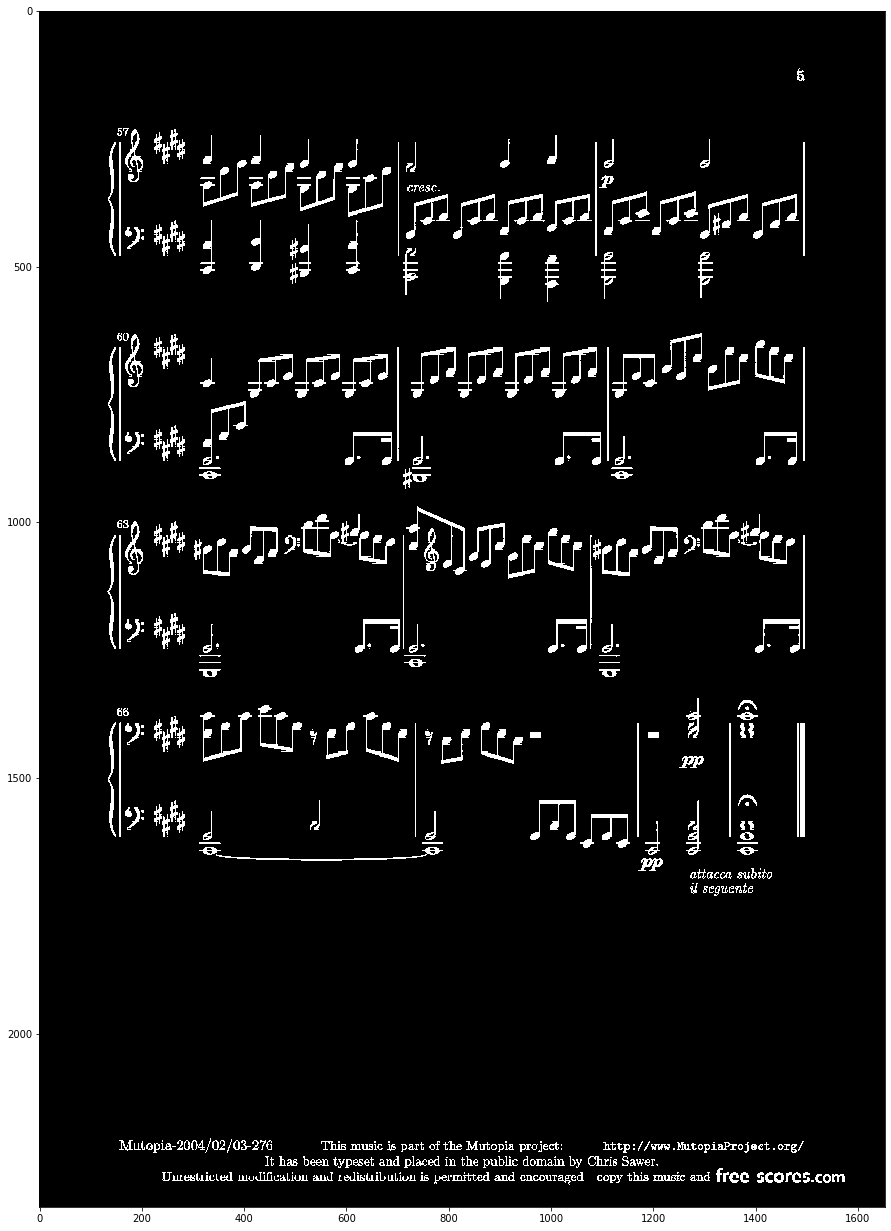

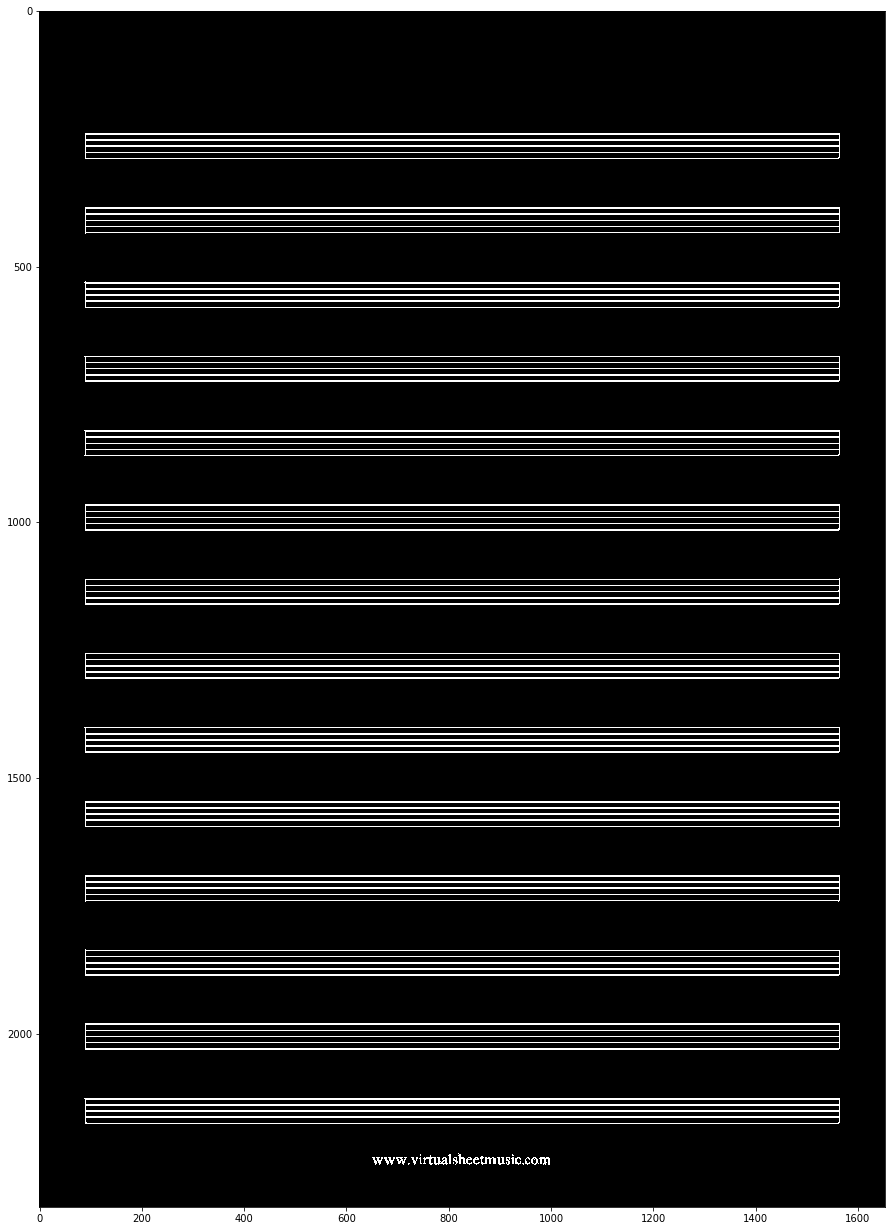

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(241.91865079365078, 2.9186507936507935, 69, 1585)
(253.91865079365078, 2.9186507936507935, 69, 1585)
(265.9186507936508, 2.9186507936507935, 69, 1585)
(277.9186507936508, 2.9186507936507935, 69, 1585)
(289.91732804232805, 2.919973544973545, 69, 1585)
(386.91738268341044, 2.917382683410443, 68, 1585)
(398.9186507936508, 2.9186507936507935, 69, 1585)
(410.9186507936508, 2.9186507936507935, 69, 1585)
(422.9186507936508, 2.9186507936507935, 69, 1585)
(434.9186507936508, 2.9186507936507935, 69, 1585)
(532.9167217448777, 2.917382683410443, 68, 1585)
(544.9179894179895, 2.9193121693121693, 69, 1585)
(556.9186507936508, 2.9186507936507935, 69, 1585)
(568.9179894179895, 2.9193121693121693, 69, 1585)
(580.9179894179895, 2.9193121693121693, 69, 1585)
(676.9173826834104, 2.917382683410443, 68, 1585)
(688.9186507936508, 2.9186507936507935, 69, 1585)
(700.9186507936508, 2.9186507936507935, 69, 1585)
(712.9185969556585, 2

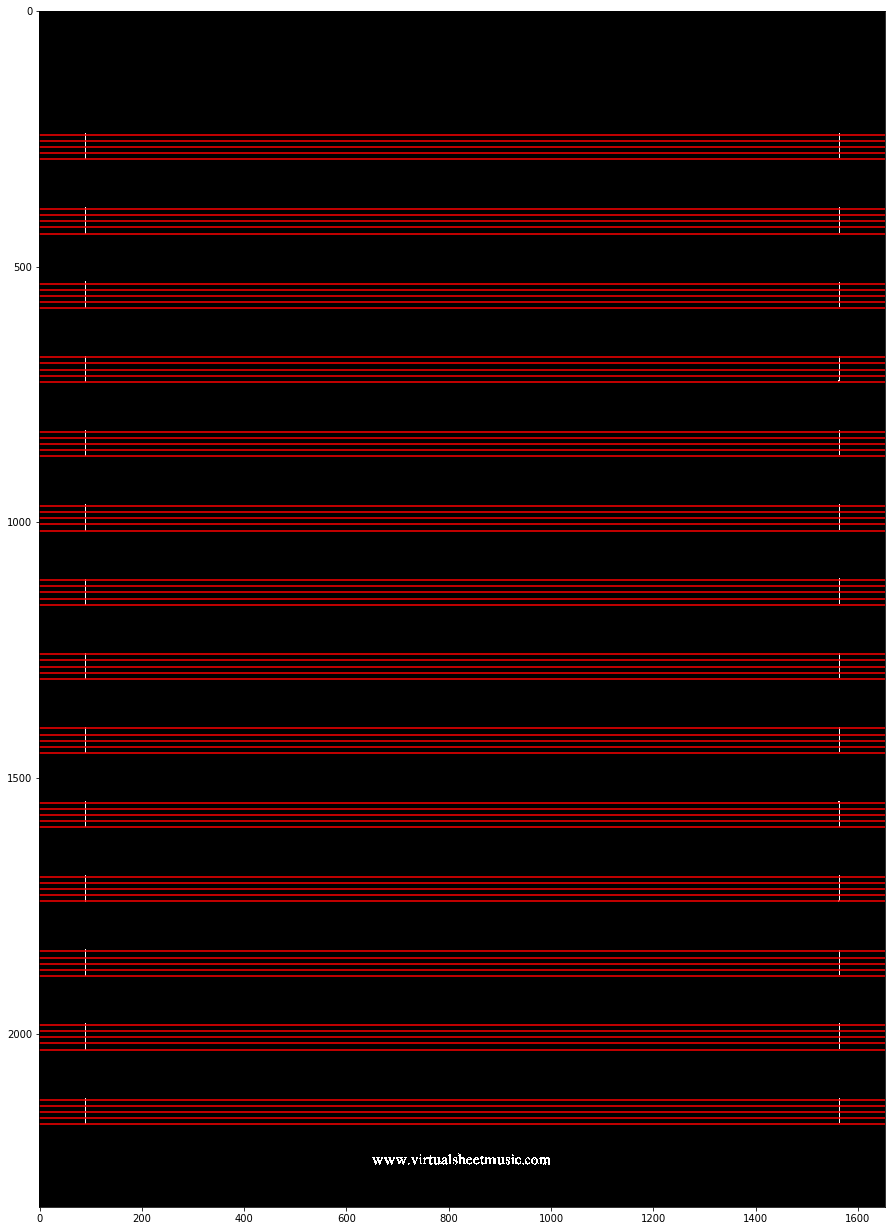

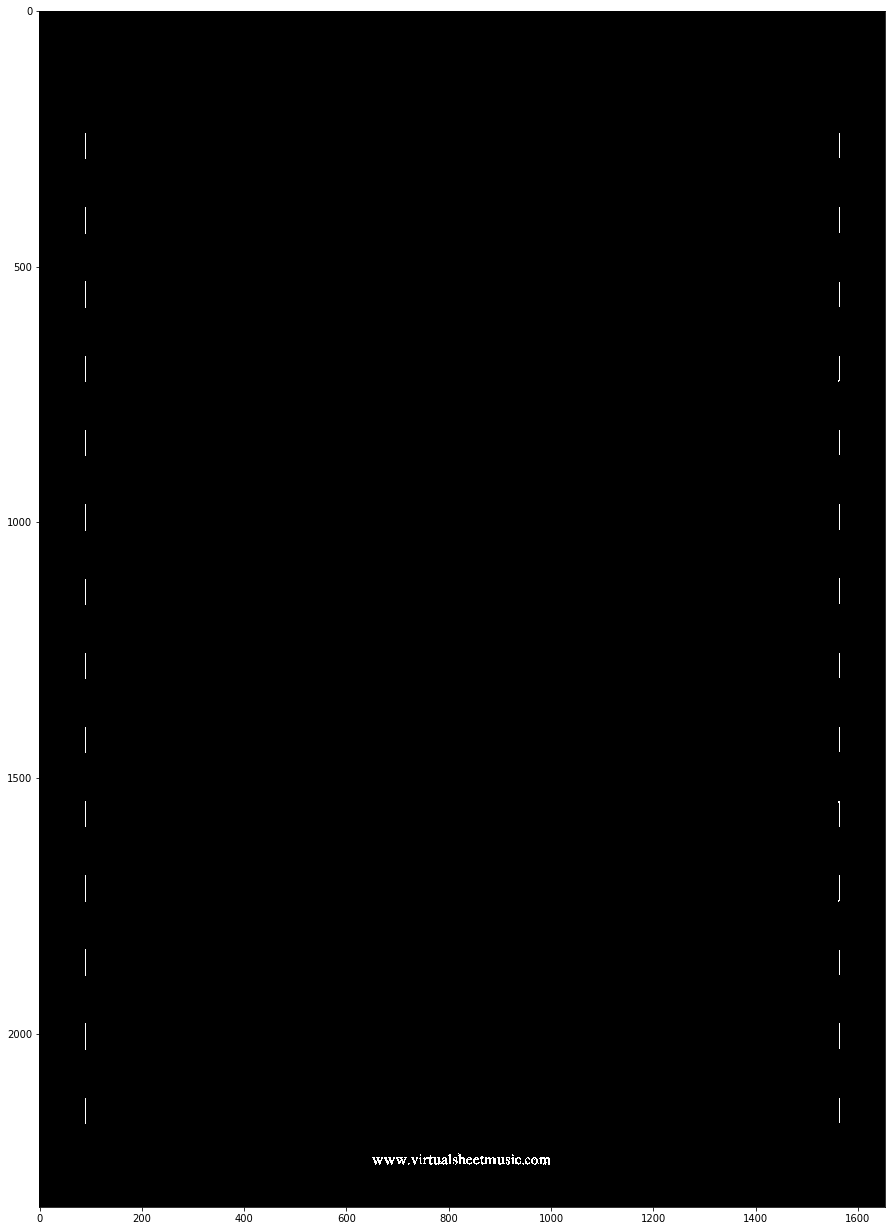

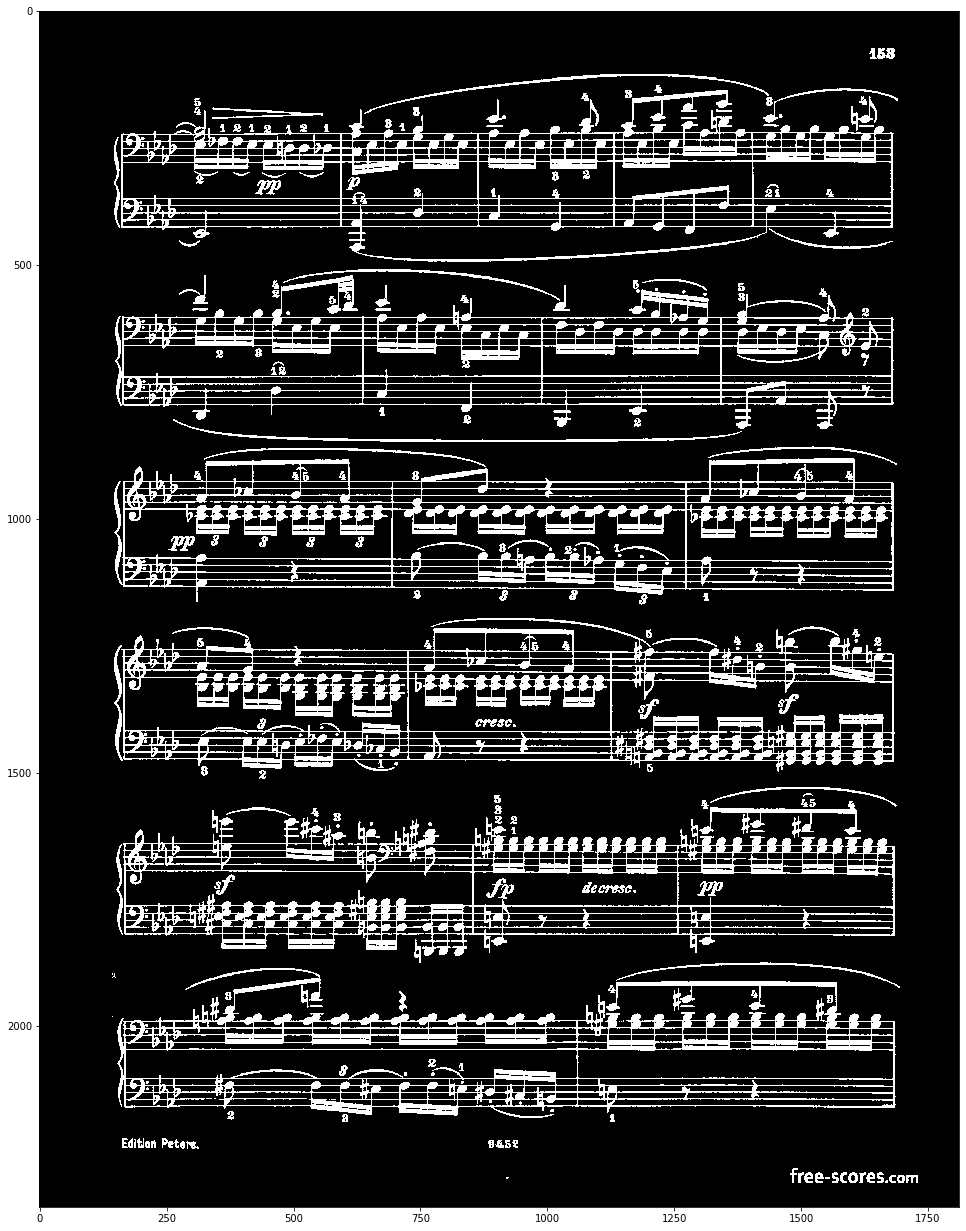

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(240.8420551855376, 2.3387250237868695, 142, 1702)
(254.79607109448082, 2.3554724041159965, 130, 1701)
(268.2862783810464, 2.3583415597235935, 128, 1702)
(282.1783439490446, 2.5341219290263877, 128, 1701)
(296.43134328358207, 2.6059701492537313, 129, 1701)
(370.6434395848777, 2.636767976278725, 132, 1701)
(385.15819209039546, 2.739406779661017, 129, 1701)
(398.54956896551727, 2.807471264367816, 128, 1701)
(411.8392857142857, 2.6757142857142857, 130, 1701)
(426.8233890214797, 2.888623707239459, 135, 1701)
(604.8157248157248, 2.511875511875512, 135, 1701)
(618.7134404057481, 2.353338968723584, 131, 1701)
(633.3143904674611, 2.384967919340055, 130, 1701)
(647.1514657980456, 2.5944625407166124, 131, 1701)
(659.8847184986595, 2.4691689008042896, 134, 1701)
(719.3887399463807, 2.6273458445040214, 136, 1701)
(733.4182194616977, 2.7267080745341614, 133, 1701)
(747.3963768115942, 2.7065217391304346, 132, 1701)
(761.4

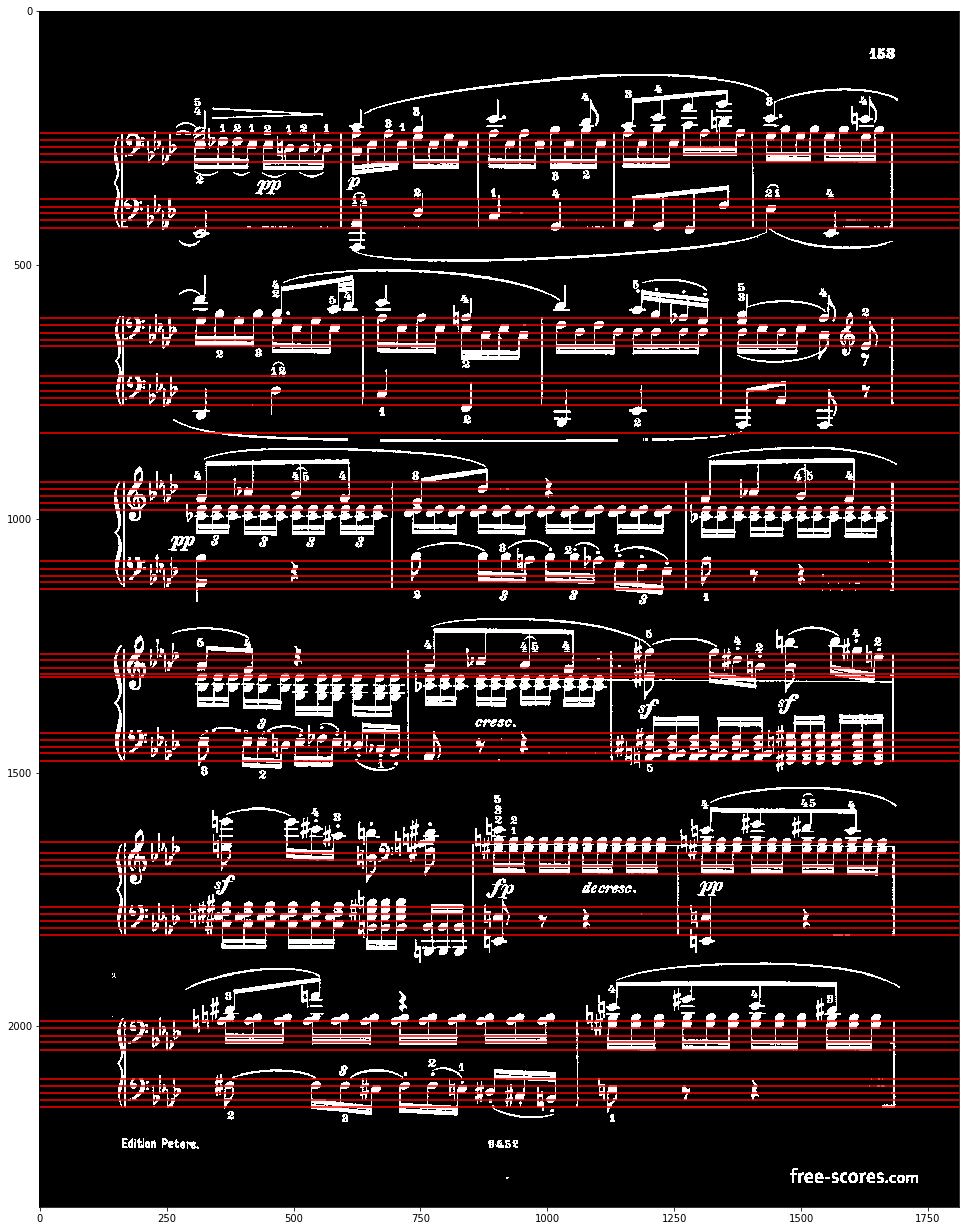

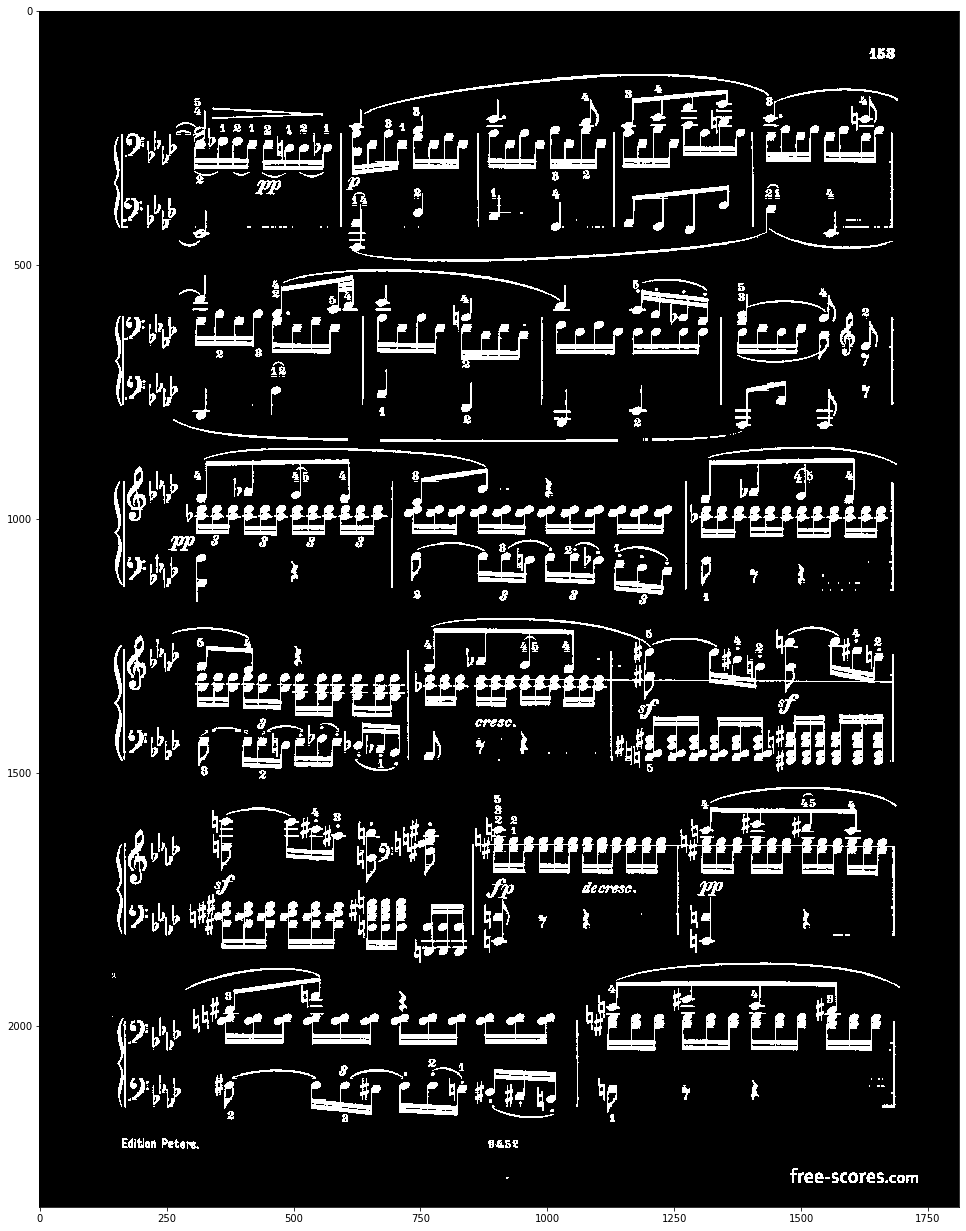

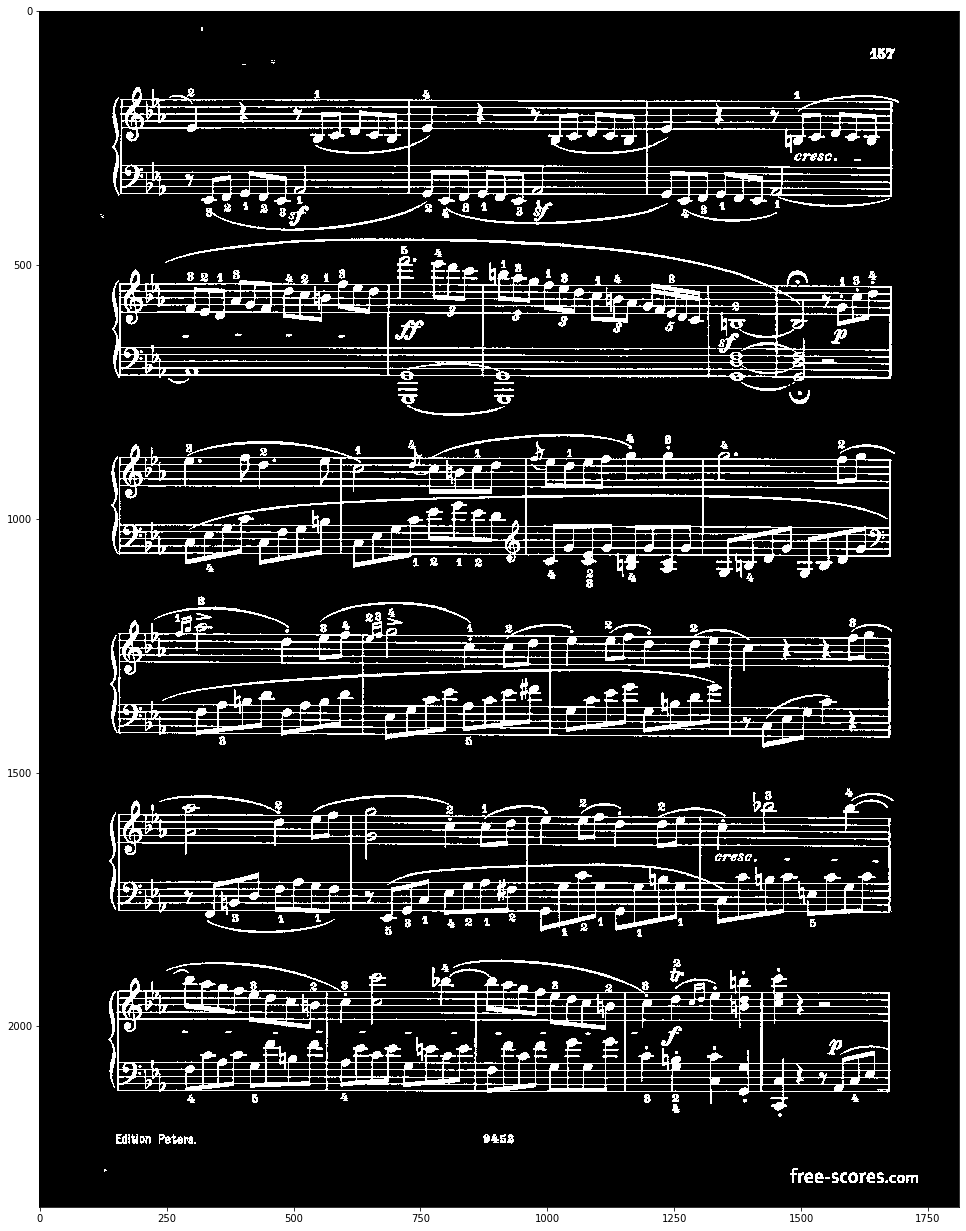

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(177.7220650636492, 2.876237623762376, 130, 1713)
(193.1432545201669, 2.8692628650904033, 125, 1700)
(205.31483253588516, 2.7502392344497606, 125, 1700)
(219.1716738197425, 2.824749642346209, 126, 1700)
(234.32258064516128, 2.8687171792948236, 128, 1700)
(309.4110962566845, 2.713903743315508, 129, 1701)
(323.3082969432314, 2.7266375545851527, 126, 1700)
(337.85560675883255, 2.5384024577572966, 126, 1700)
(350.5687811831789, 2.7540983606557377, 128, 1700)
(364.2810902896082, 2.819420783645656, 133, 1700)
(501.4415584415584, 3.090909090909091, 242, 1347)
(542.9595619208087, 2.5973041280539175, 130, 1699)
(557.149641577061, 2.697132616487455, 125, 1699)
(570.4533582089553, 2.3936567164179103, 124, 1699)
(583.1364406779661, 2.561864406779661, 125, 1699)
(597.6936708860759, 2.8135021097046415, 128, 1699)
(665.9730290456431, 2.773167358229599, 129, 1699)
(681.6043265875785, 2.762037683182135, 126, 1699)
(694.13208

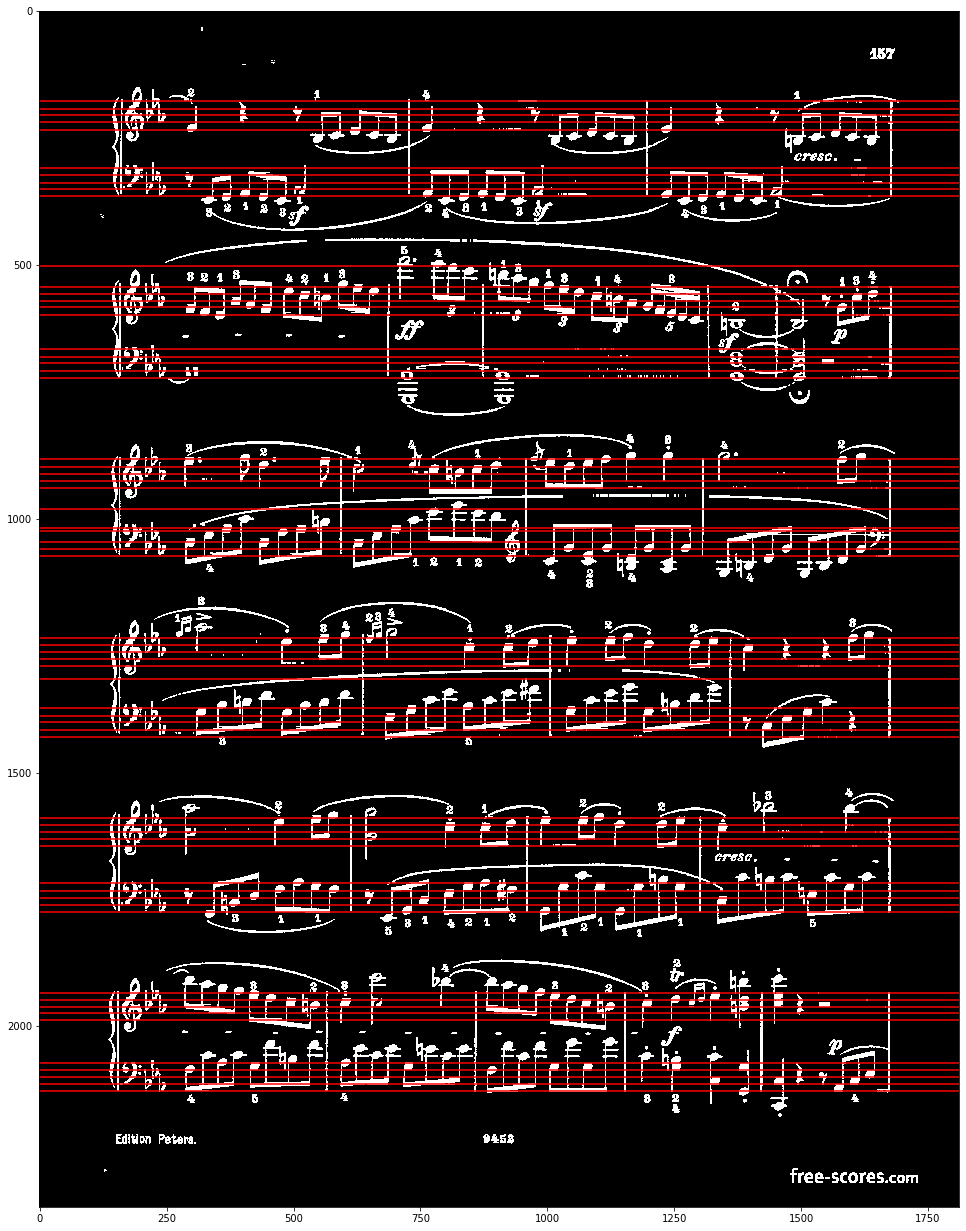

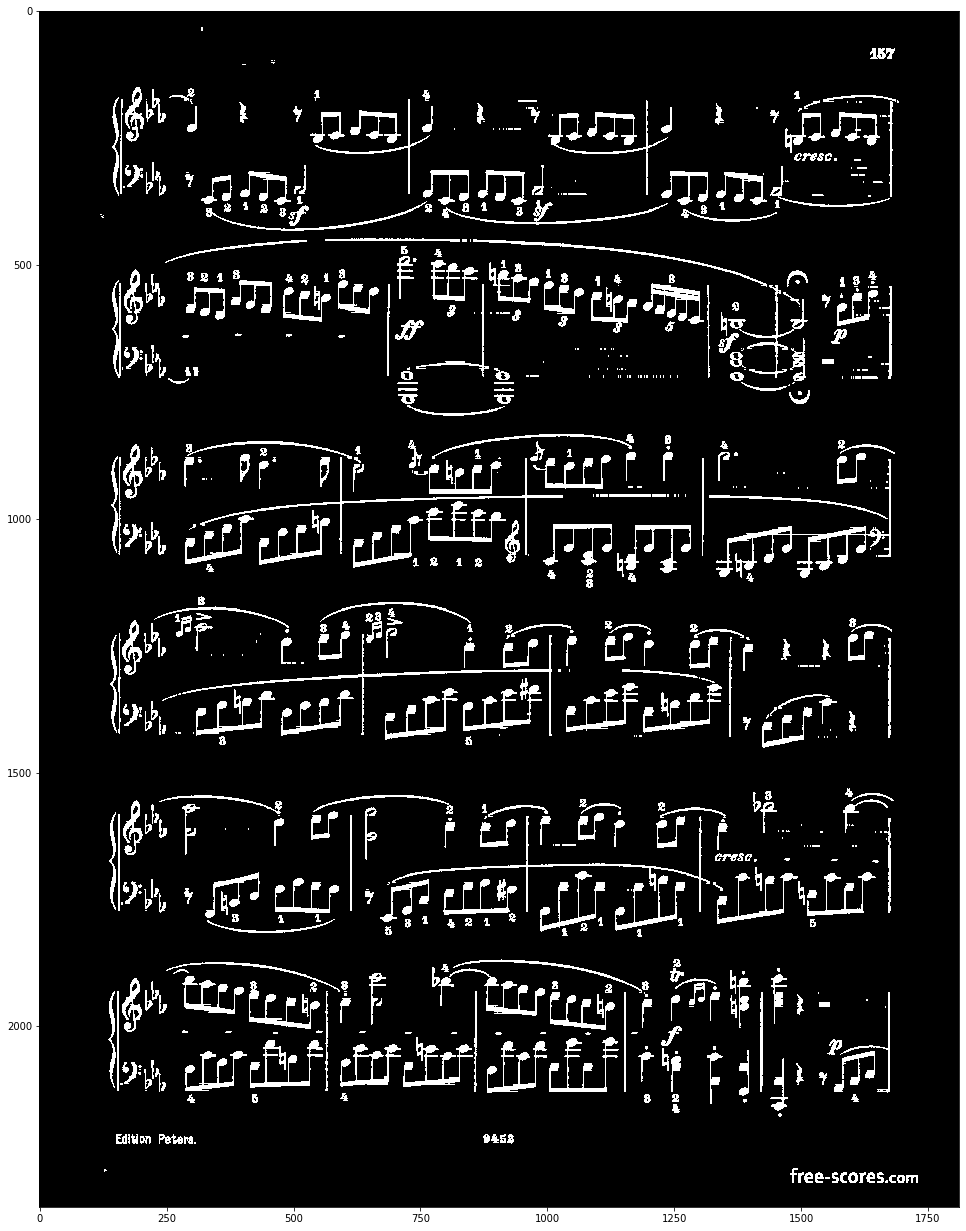

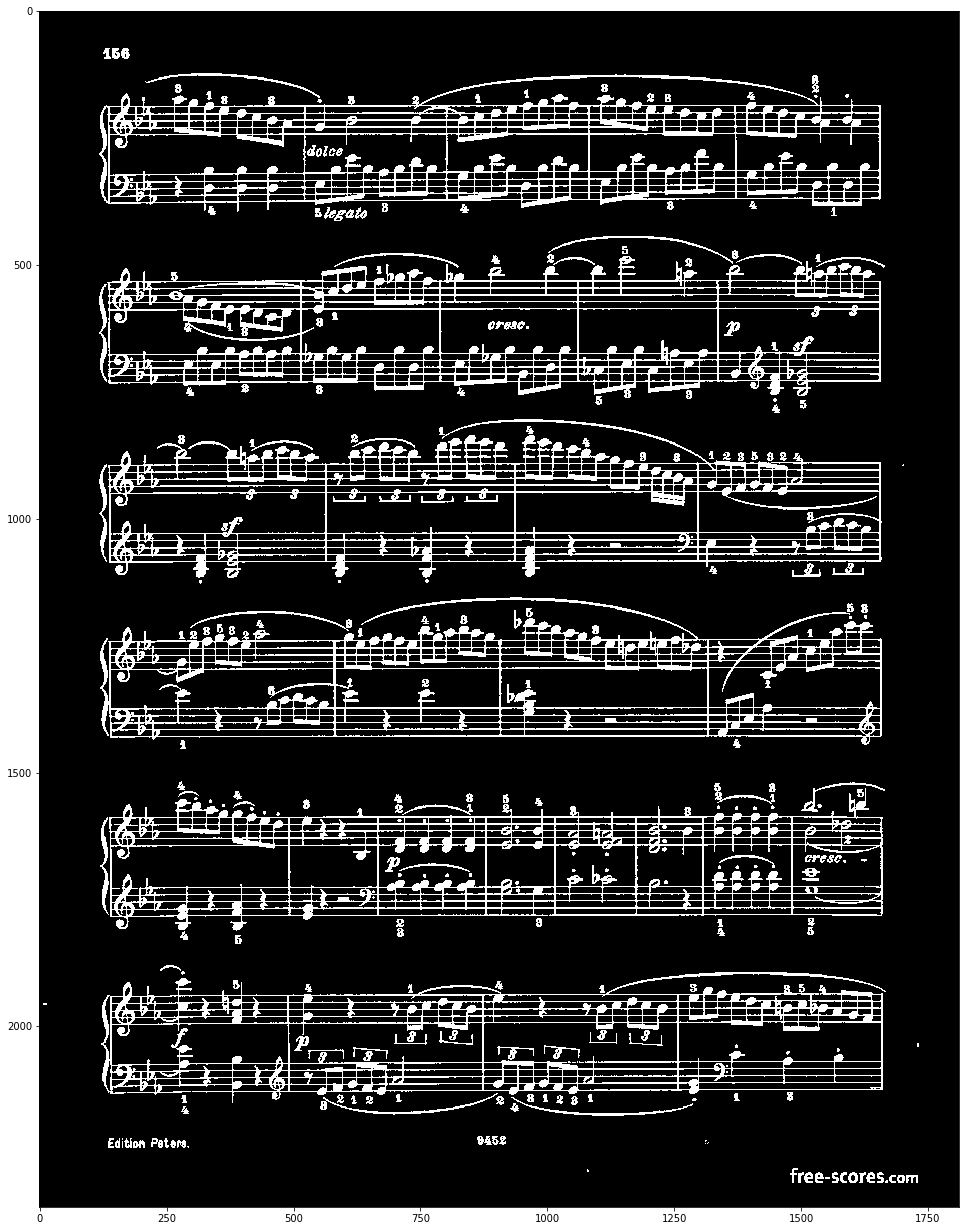

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(187.35635123614662, 2.8312020460358056, 108, 1677)
(201.39763113367175, 2.718274111675127, 102, 1677)
(215.10186005314438, 2.6908768821966342, 100, 1677)
(228.84323858742462, 2.67786391042205, 101, 1677)
(242.7828014184397, 2.6959219858156027, 104, 1677)
(314.68283582089555, 2.469216417910448, 103, 1677)
(328.4651162790698, 2.54463615903976, 101, 1677)
(342.5799522673031, 2.7008750994431185, 101, 1677)
(355.78564500484964, 2.6314258001939863, 105, 1677)
(369.4544626593807, 2.7522768670309654, 111, 1677)
(532.8585445625511, 2.5682747342600165, 114, 1677)
(546.9176029962547, 2.737827715355805, 103, 1678)
(561.1164817749603, 2.8748019017432647, 99, 1678)
(573.4014981273408, 2.7310861423220976, 99, 1678)
(587.6119287374129, 2.850503485670023, 101, 1678)
(674.3979303857009, 2.5625587958607716, 102, 1677)
(687.9578264395783, 2.5498783454987834, 100, 1678)
(701.0157154673284, 2.5723738626964434, 101, 1677)
(715.36

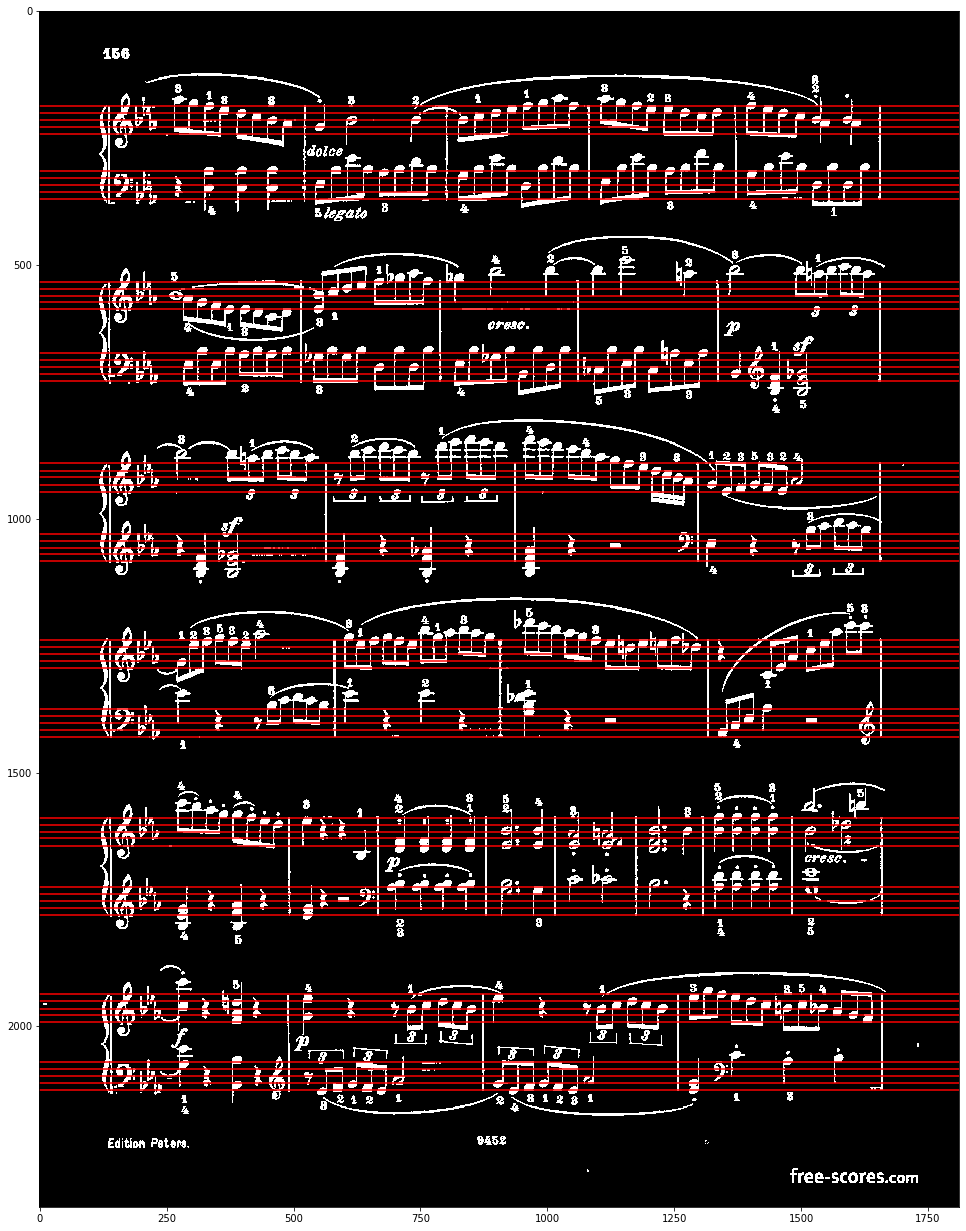

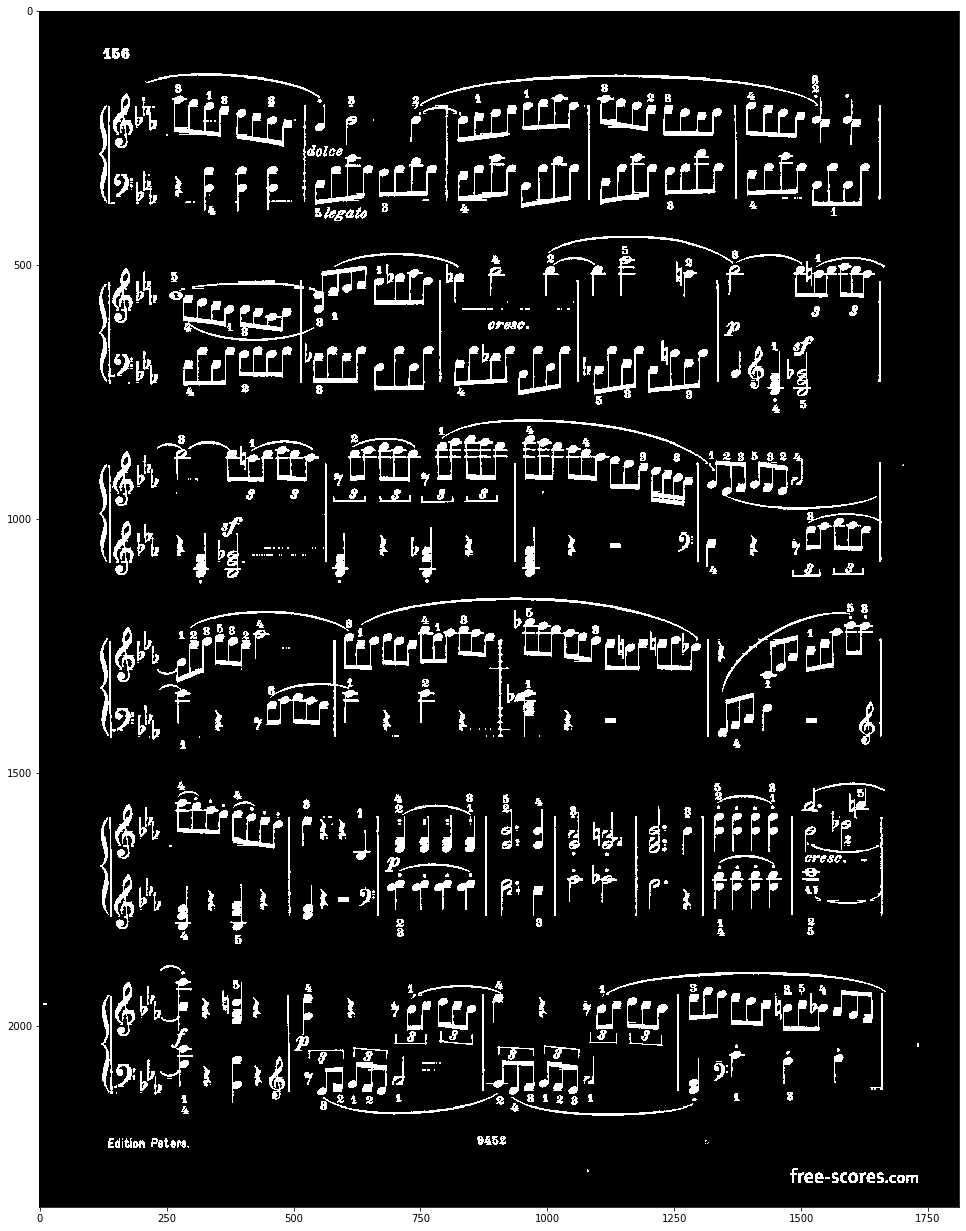

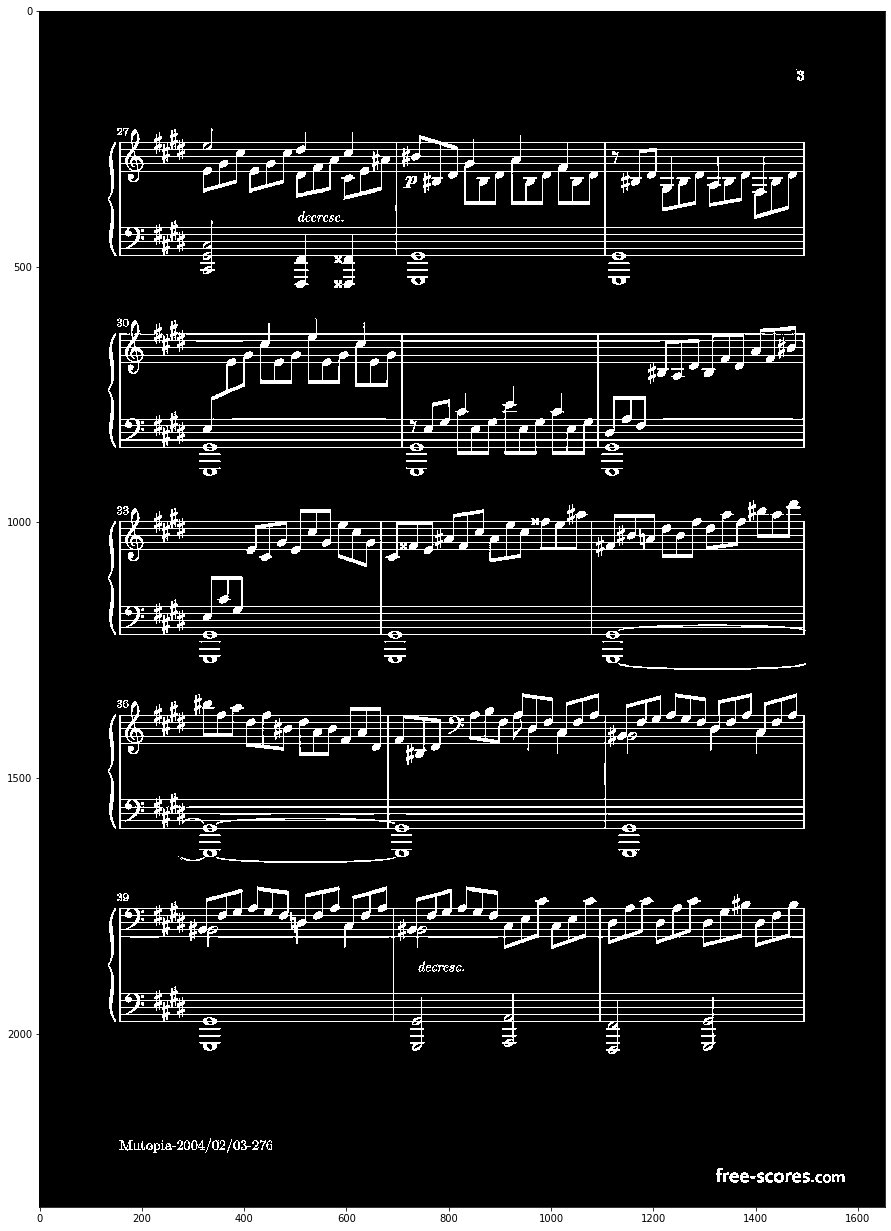

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(257.3785084202085, 2.1339214113873295, 127, 1516)
(270.9458762886598, 1.918384879725086, 120, 1516)
(284.95, 1.910344827586207, 117, 1516)
(298.9472340425532, 1.9191489361702128, 117, 1516)
(312.94519317160825, 1.9227313566936208, 118, 1516)
(424.811377245509, 2.8473053892215567, 118, 1516)
(436.974105102818, 1.9276466108149277, 117, 1516)
(450.9663608562691, 1.9212538226299694, 117, 1516)
(464.9532428355958, 1.9313725490196079, 120, 1516)
(478.96287519747233, 1.9352290679304898, 127, 1516)
(633.6235584843492, 2.798187808896211, 127, 1516)
(645.977234401349, 2.4241146711635753, 120, 1516)
(658.9553933495539, 1.9148418491484185, 117, 1516)
(672.9595709570957, 1.9166666666666667, 117, 1516)
(686.9369294605809, 1.929460580912863, 118, 1516)
(797.4995944849959, 2.381184103811841, 118, 1516)
(810.9554585152838, 1.908296943231441, 117, 1516)
(824.9510779436152, 1.9112769485903813, 117, 1516)
(838.952380952381, 1.

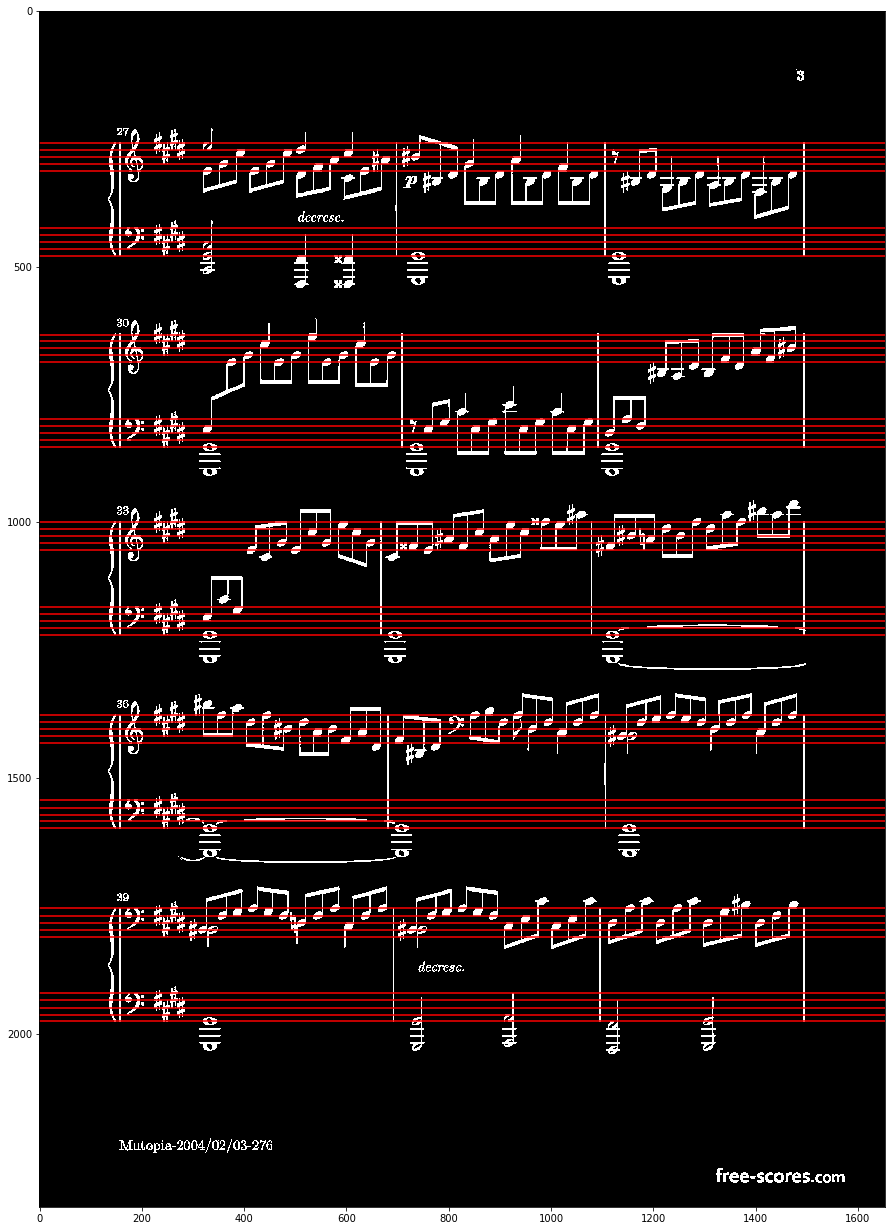

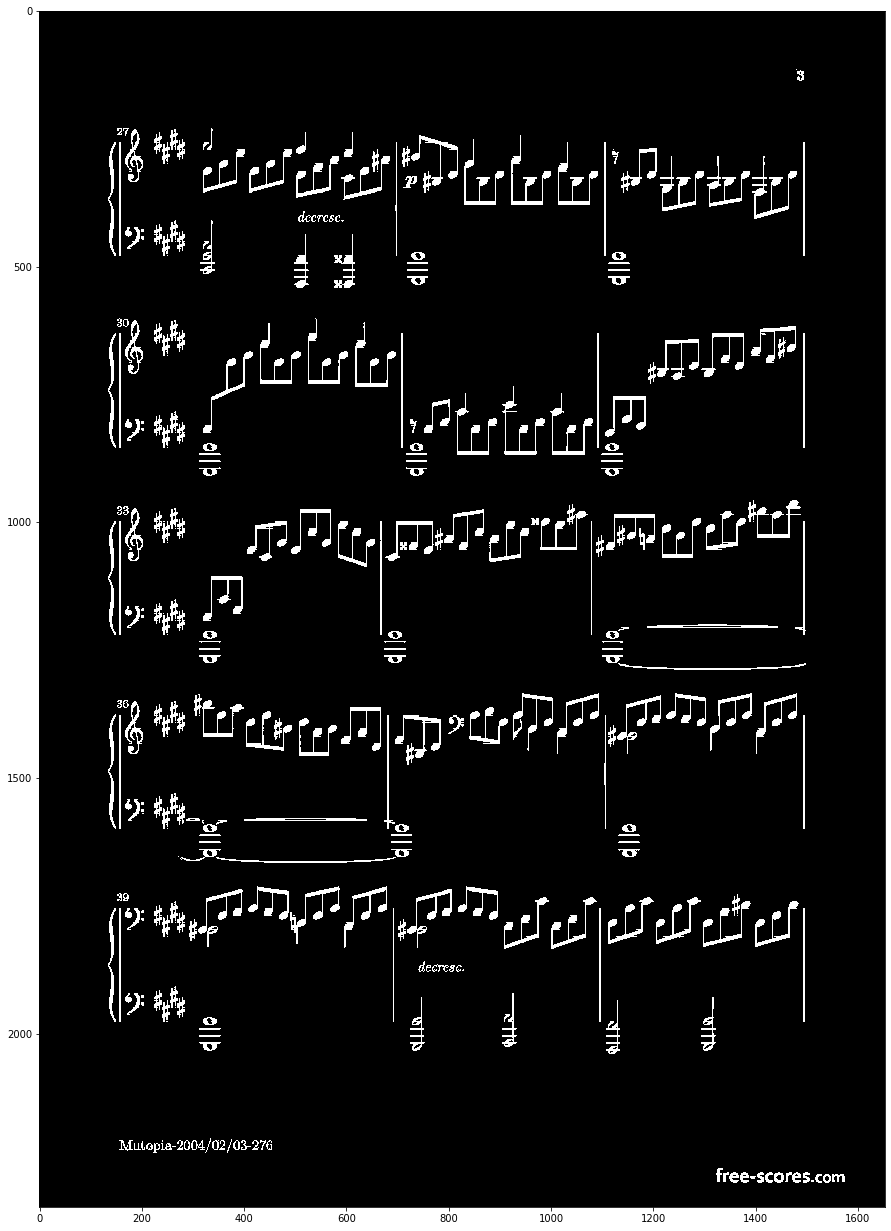

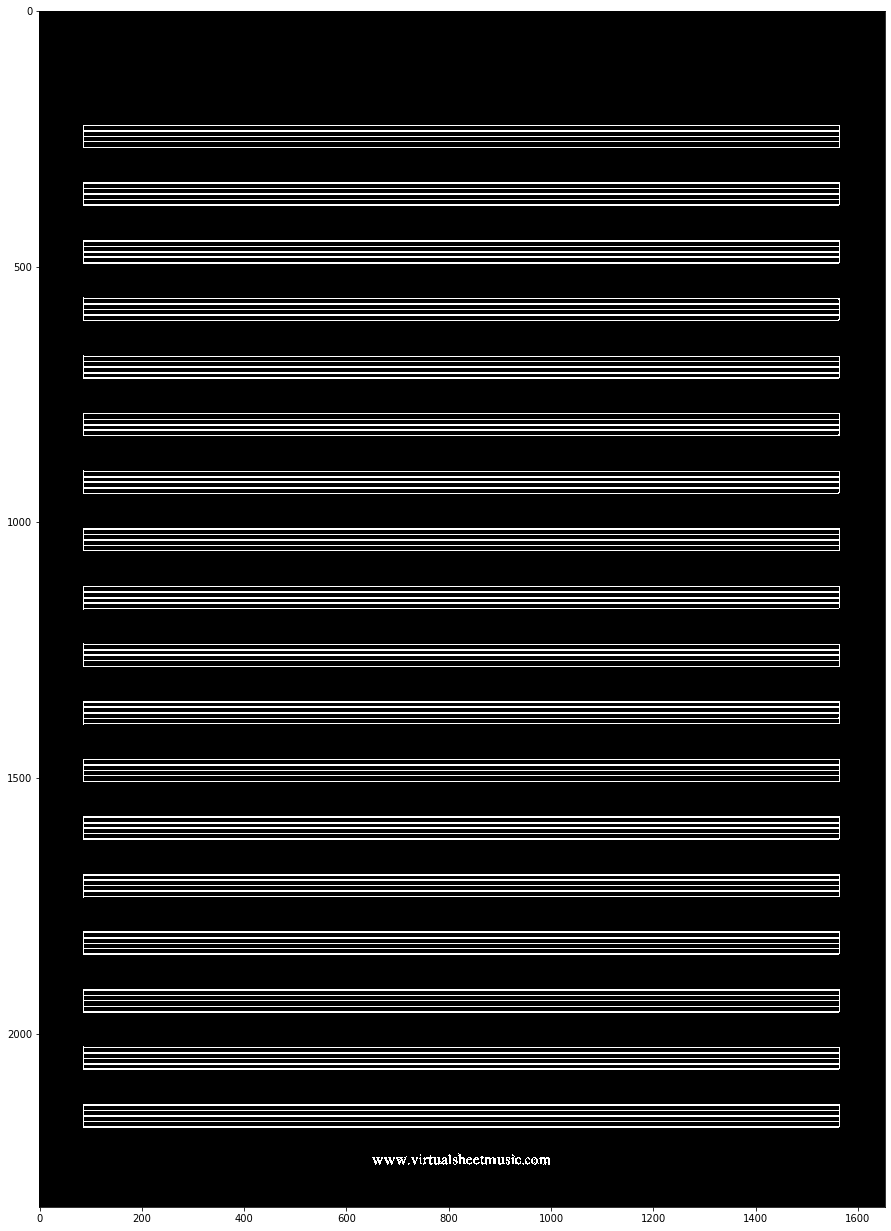

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(224.91754617414247, 2.91754617414248, 65, 1585)
(235.9188654353562, 2.9188654353562007, 66, 1585)
(246.9188654353562, 2.9188654353562007, 66, 1585)
(256.9188118811881, 2.9188118811881187, 66, 1585)
(267.91694133157546, 2.918259723137772, 65, 1585)
(337.91694133157546, 2.917600527356625, 65, 1585)
(348.9188654353562, 2.9188654353562007, 66, 1585)
(358.9188654353562, 2.9188654353562007, 66, 1585)
(369.9188654353562, 2.9188654353562007, 66, 1585)
(380.9156229400132, 2.919578114700066, 65, 1585)
(450.9176548089592, 2.91699604743083, 64, 1585)
(461.9188654353562, 2.9188654353562007, 66, 1585)
(472.9188654353562, 2.9188654353562007, 66, 1585)
(482.9188654353562, 2.9188654353562007, 66, 1585)
(493.91628213579435, 2.918259723137772, 65, 1585)
(563.9143045484509, 2.915622940013184, 65, 1587)
(574.9188654353562, 2.9188654353562007, 66, 1585)
(584.9188654353562, 2.9188654353562007, 66, 1585)
(595.9188654353562, 2.9188

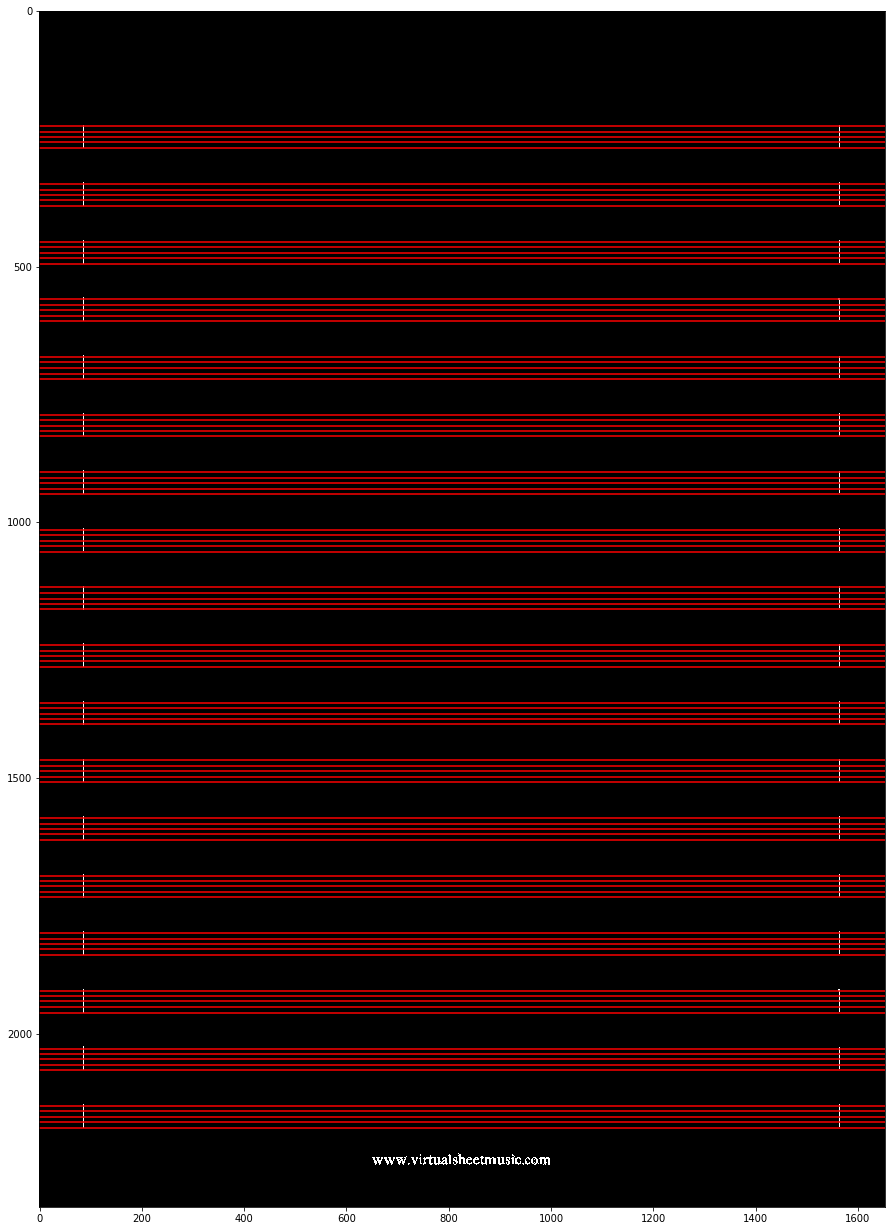

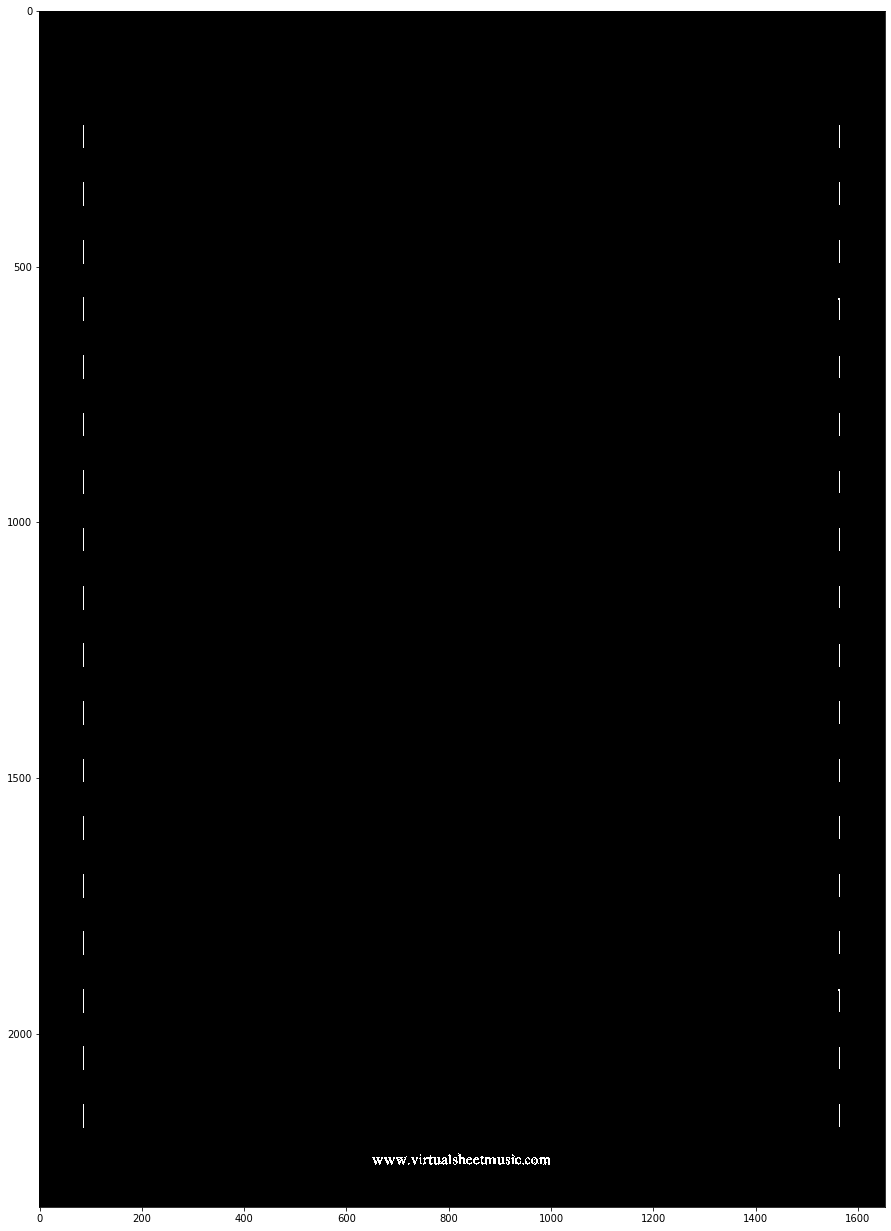

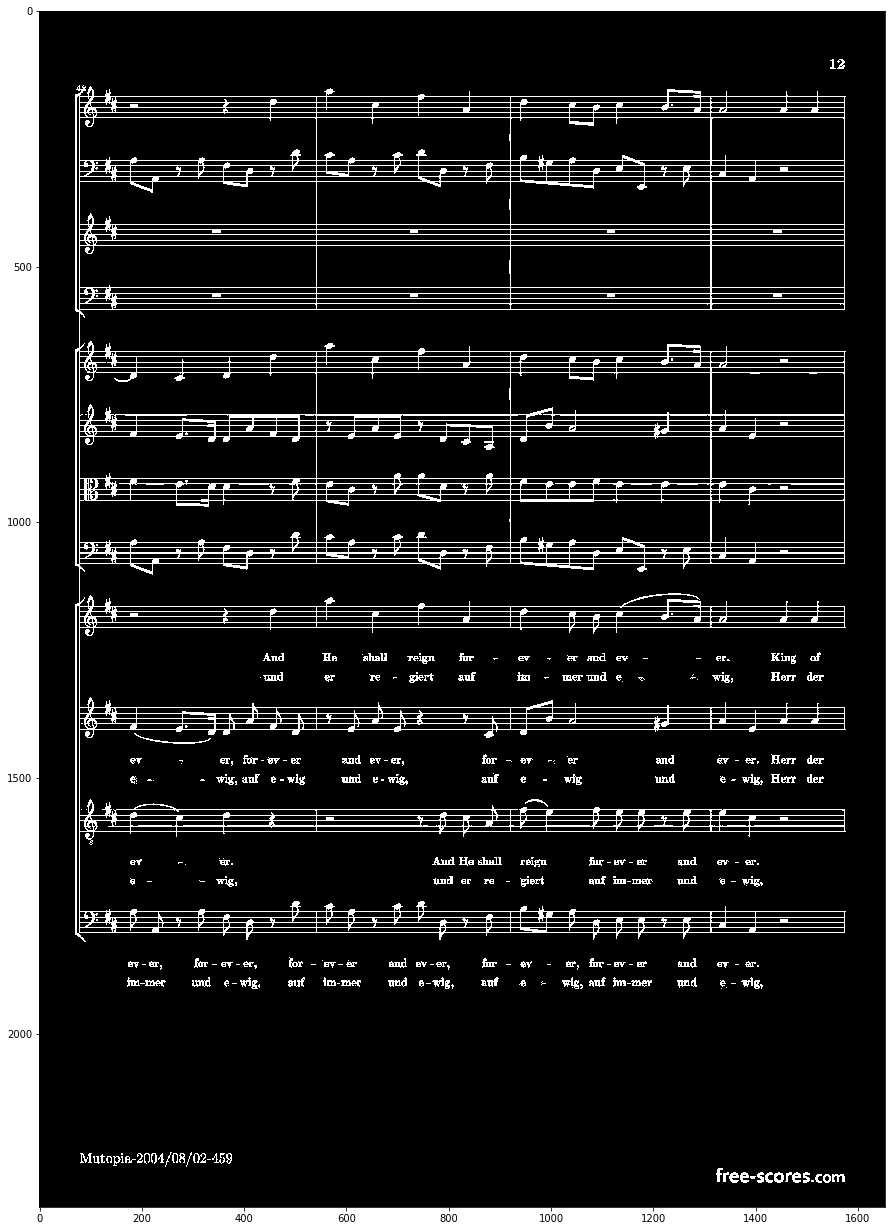

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(167.96582365003417, 1.9569377990430623, 50, 1595)
(177.96588486140726, 1.9381663113006398, 50, 1594)
(188.33258088788563, 2.5312264860797593, 50, 1594)
(198.96410978184377, 1.9429978888106967, 50, 1594)
(208.98869680851064, 1.9561170212765957, 50, 1594)
(292.0221402214022, 1.9771217712177123, 50, 1594)
(302.9637188208617, 1.9372637944066515, 50, 1594)
(312.9662480376766, 1.9301412872841444, 50, 1594)
(323.6119186046512, 2.214389534883721, 50, 1594)
(333.96279422930905, 1.94457099468489, 50, 1594)
(416.9713524317122, 1.9407061958694203, 50, 1594)
(426.97833682739343, 1.9419986023759608, 50, 1594)
(437.9698593436035, 1.9397186872069658, 50, 1594)
(447.9694352159468, 1.9408637873754153, 50, 1594)
(457.9644268774704, 1.9453227931488801, 50, 1594)
(540.9781456953642, 1.9463576158940397, 50, 1594)
(551.9698879551821, 1.9397759103641457, 50, 1594)
(561.969144460028, 1.9382889200561009, 50, 1594)
(571.9854304635761

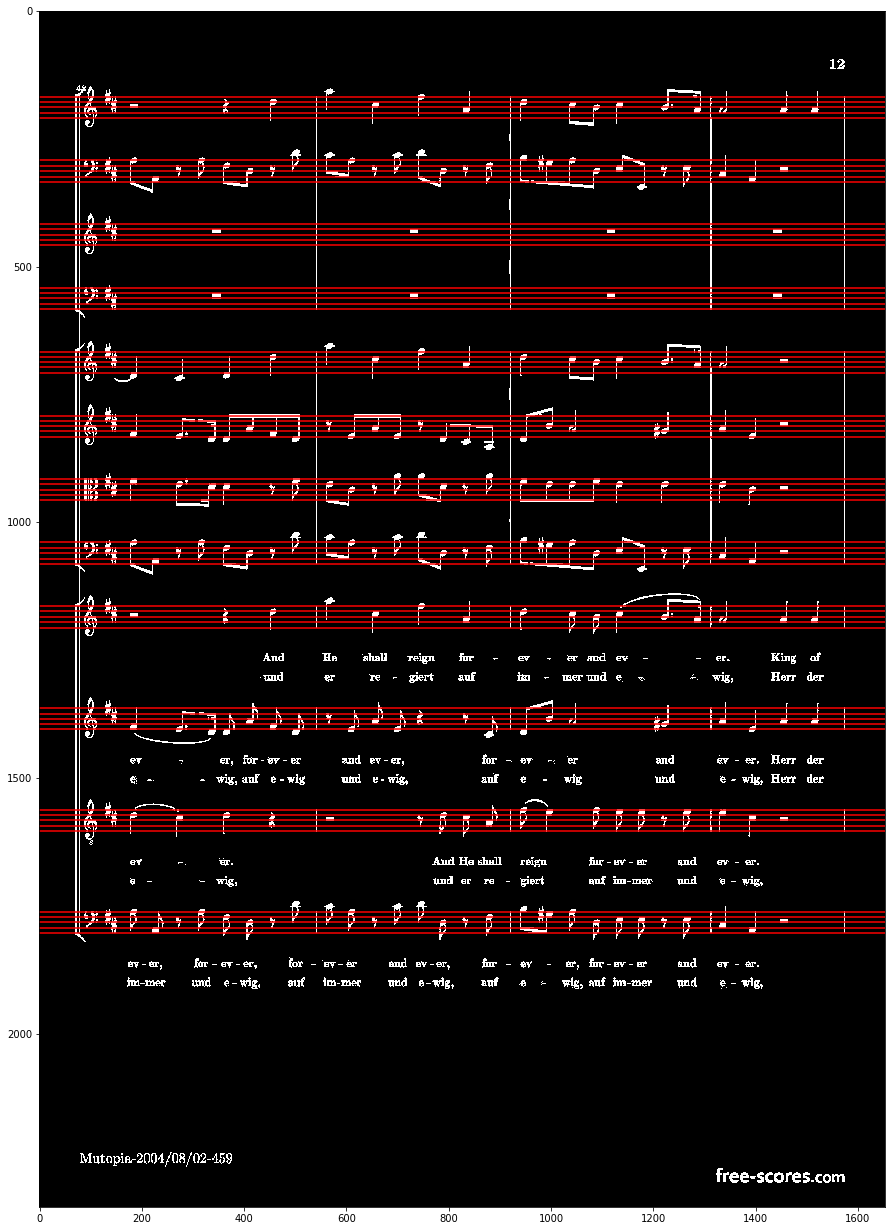

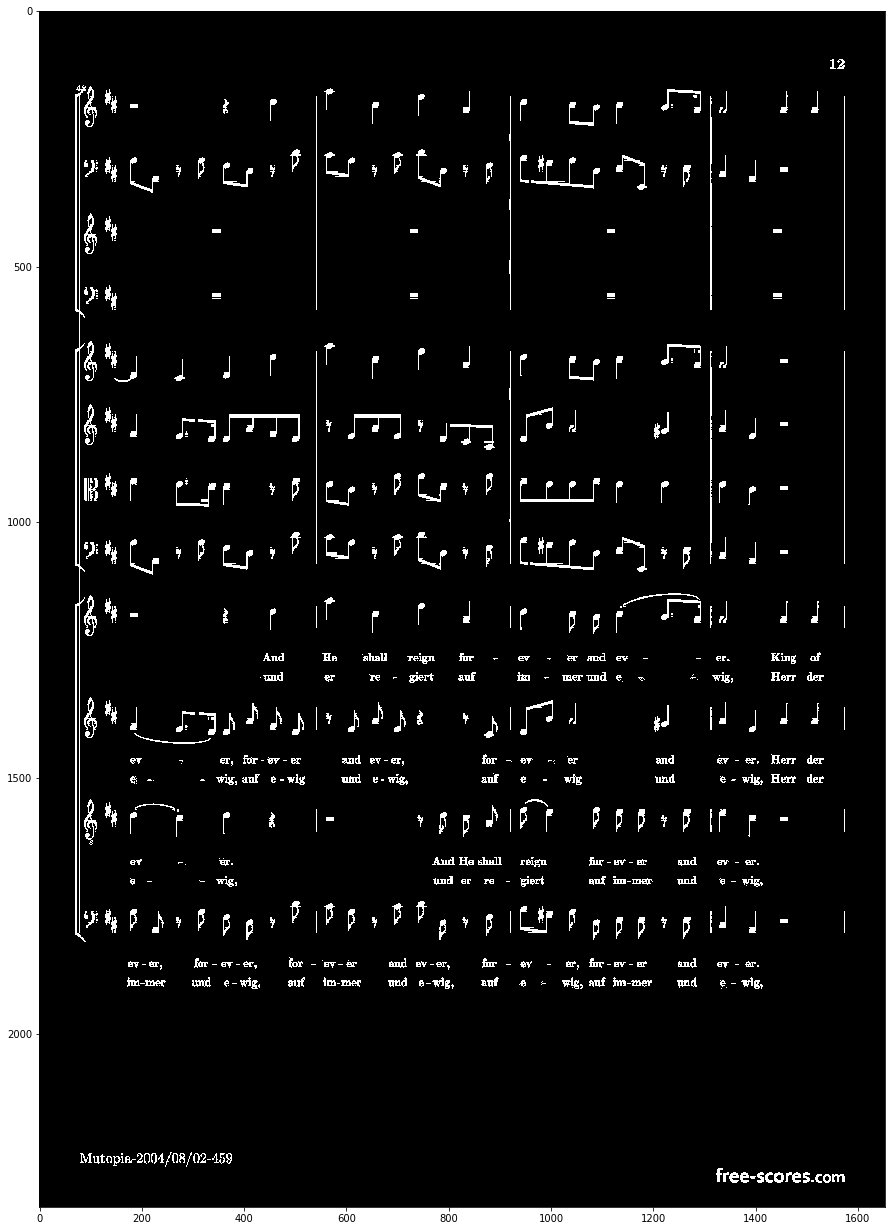

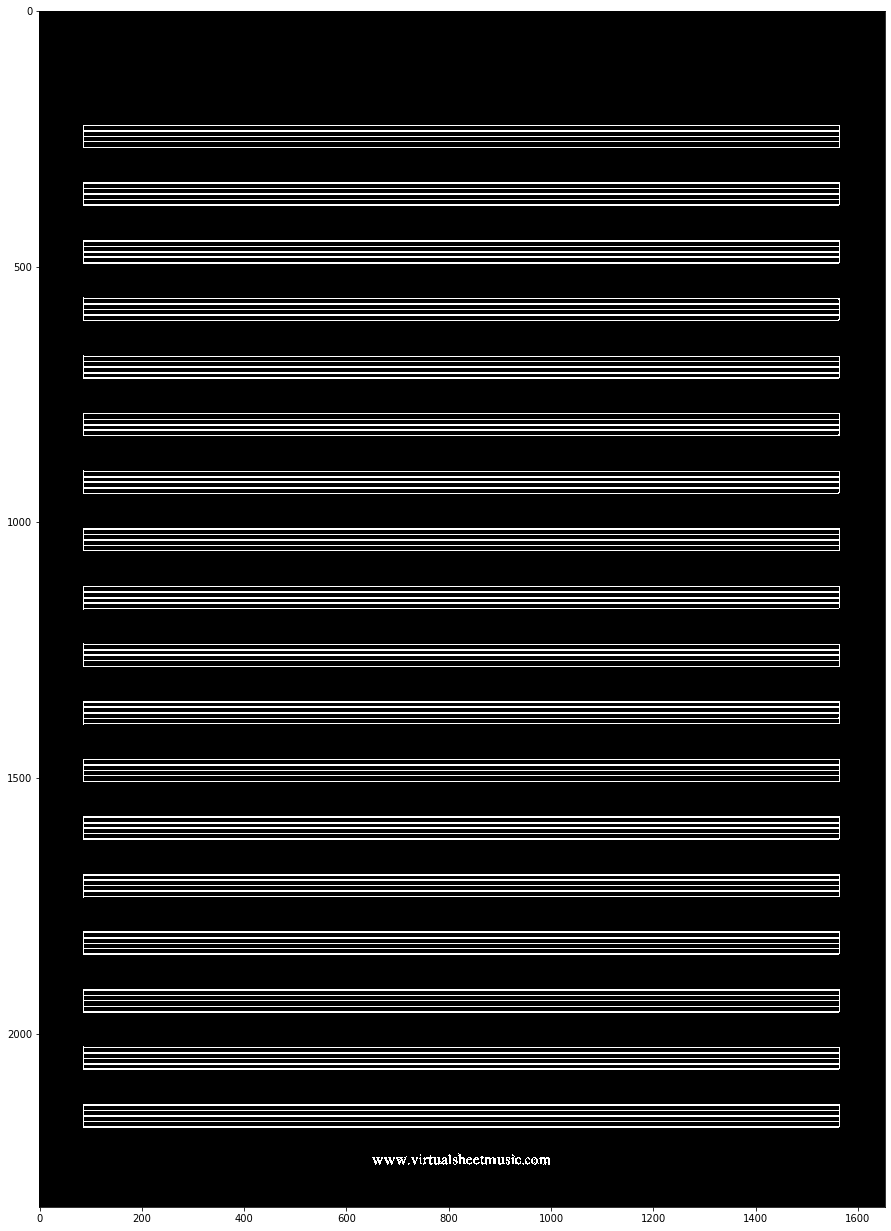

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(224.91754617414247, 2.91754617414248, 65, 1585)
(235.9188654353562, 2.9188654353562007, 66, 1585)
(246.9188654353562, 2.9188654353562007, 66, 1585)
(256.9188118811881, 2.9188118811881187, 66, 1585)
(267.91694133157546, 2.918259723137772, 65, 1585)
(337.91694133157546, 2.917600527356625, 65, 1585)
(348.9188654353562, 2.9188654353562007, 66, 1585)
(358.9188654353562, 2.9188654353562007, 66, 1585)
(369.9188654353562, 2.9188654353562007, 66, 1585)
(380.9156229400132, 2.919578114700066, 65, 1585)
(450.9176548089592, 2.91699604743083, 64, 1585)
(461.9188654353562, 2.9188654353562007, 66, 1585)
(472.9188654353562, 2.9188654353562007, 66, 1585)
(482.9188654353562, 2.9188654353562007, 66, 1585)
(493.91628213579435, 2.918259723137772, 65, 1585)
(563.9143045484509, 2.915622940013184, 65, 1587)
(574.9188654353562, 2.9188654353562007, 66, 1585)
(584.9188654353562, 2.9188654353562007, 66, 1585)
(595.9188654353562, 2.9188

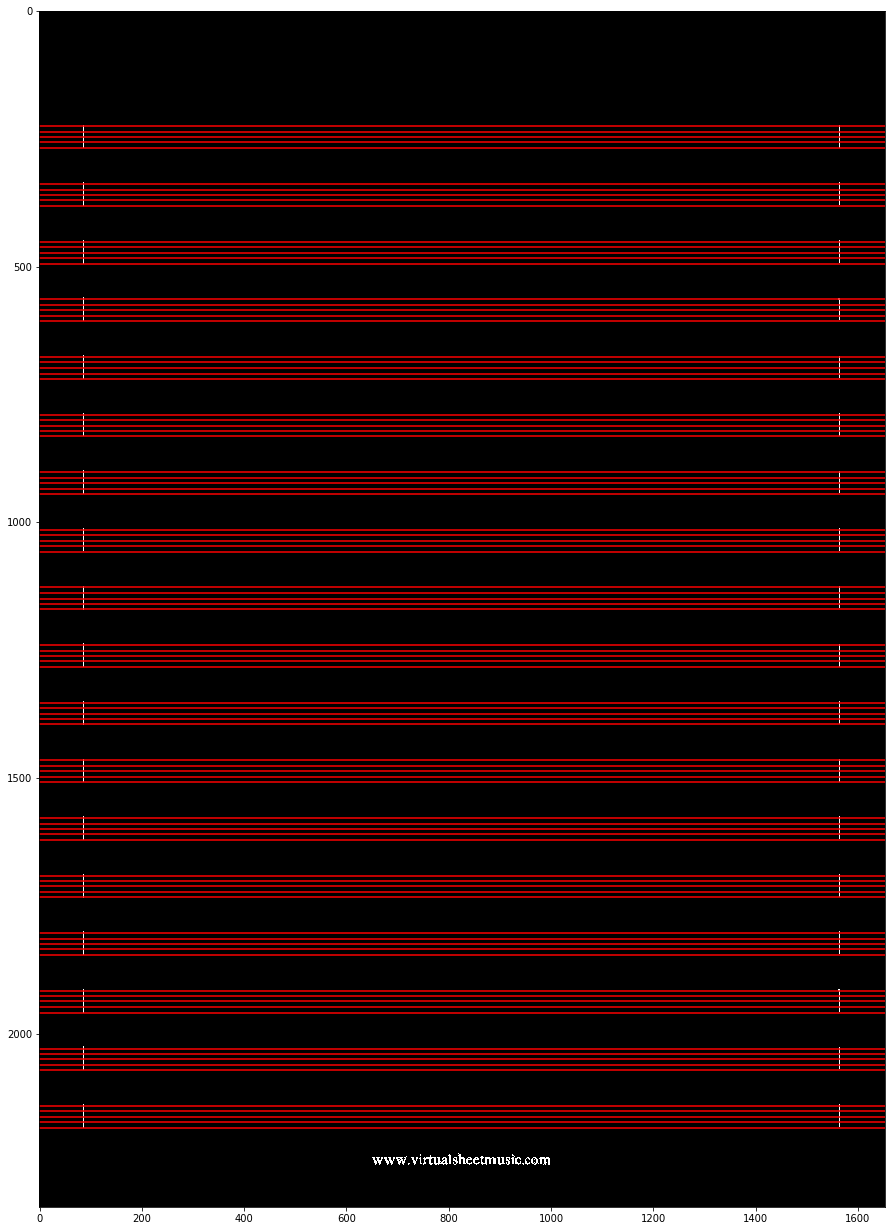

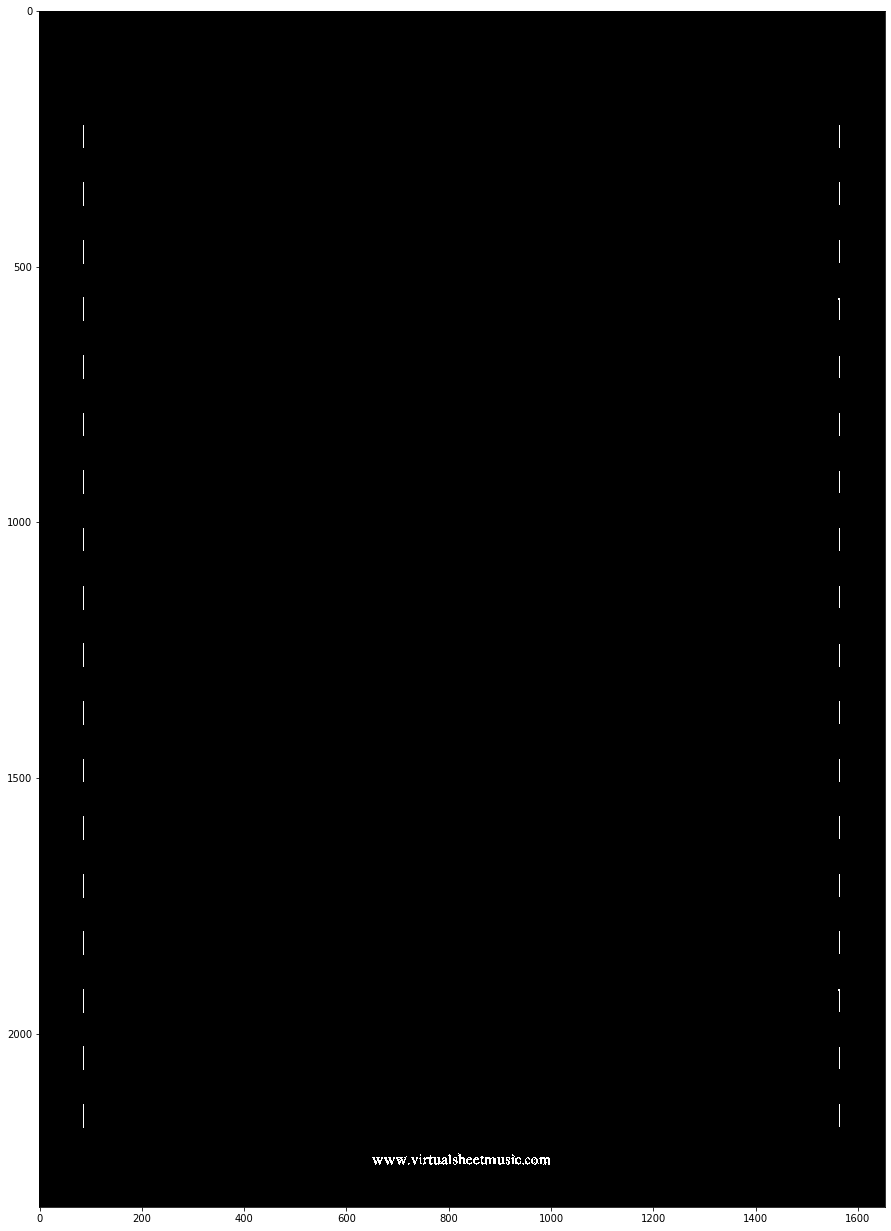

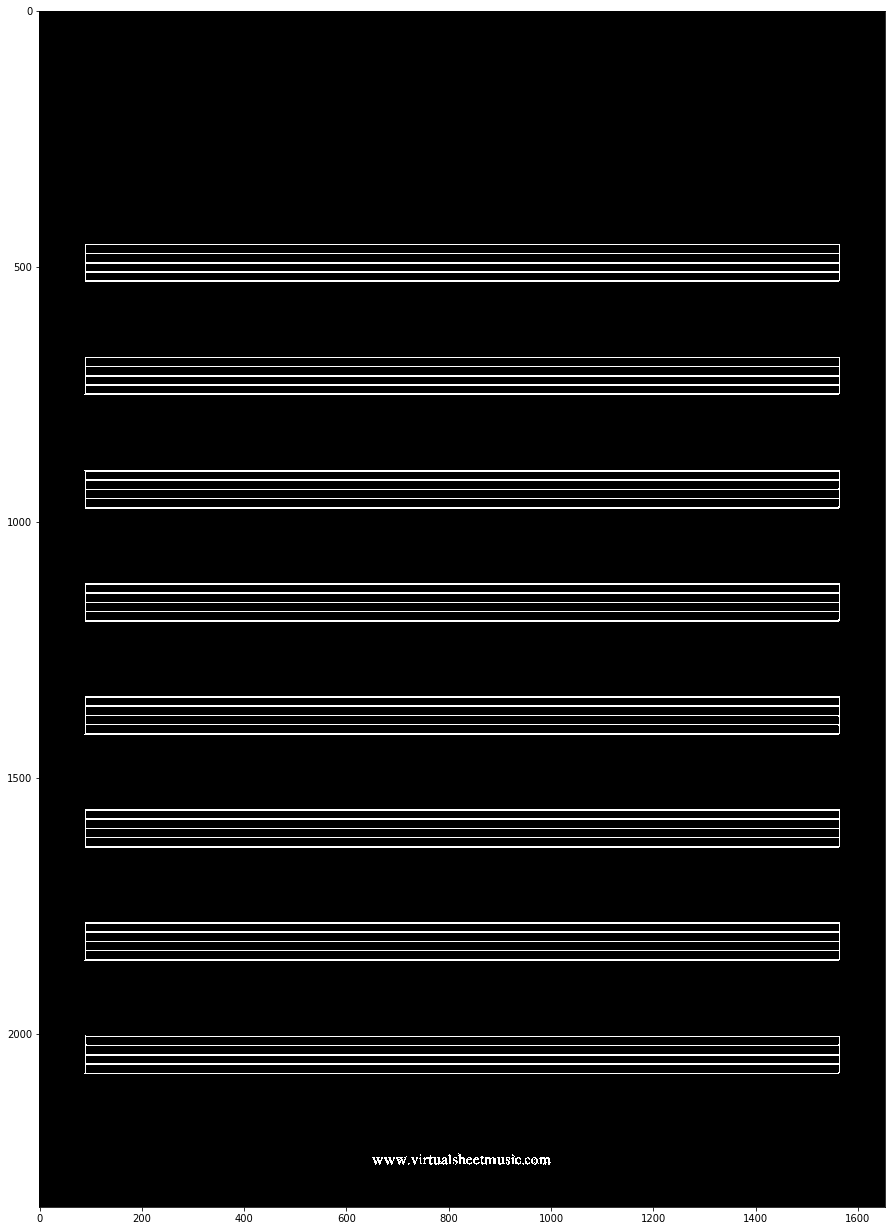

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(457.9186507936508, 2.9186507936507935, 69, 1585)
(475.9186507936508, 2.9186507936507935, 69, 1585)
(493.9186507936508, 2.9186507936507935, 69, 1585)
(511.9186507936508, 2.9186507936507935, 69, 1585)
(529.917328042328, 2.919973544973545, 69, 1585)
(678.9186507936508, 2.9186507936507935, 69, 1585)
(696.9186507936508, 2.9186507936507935, 69, 1585)
(714.9185969556585, 2.9185969556585043, 69, 1585)
(732.9185969556585, 2.9185969556585043, 69, 1585)
(750.9199735449736, 2.9193121693121693, 69, 1585)
(900.9186507936508, 2.9193121693121693, 68, 1585)
(918.9186507936508, 2.9186507936507935, 69, 1585)
(936.9179894179895, 2.9193121693121693, 69, 1585)
(954.9186507936508, 2.9186507936507935, 69, 1585)
(972.9134742404227, 2.916116248348745, 69, 1587)
(1121.9186507936508, 2.9186507936507935, 69, 1585)
(1139.9186507936508, 2.9186507936507935, 69, 1585)
(1157.9186507936508, 2.9186507936507935, 69, 1585)
(1175.9186507936508, 

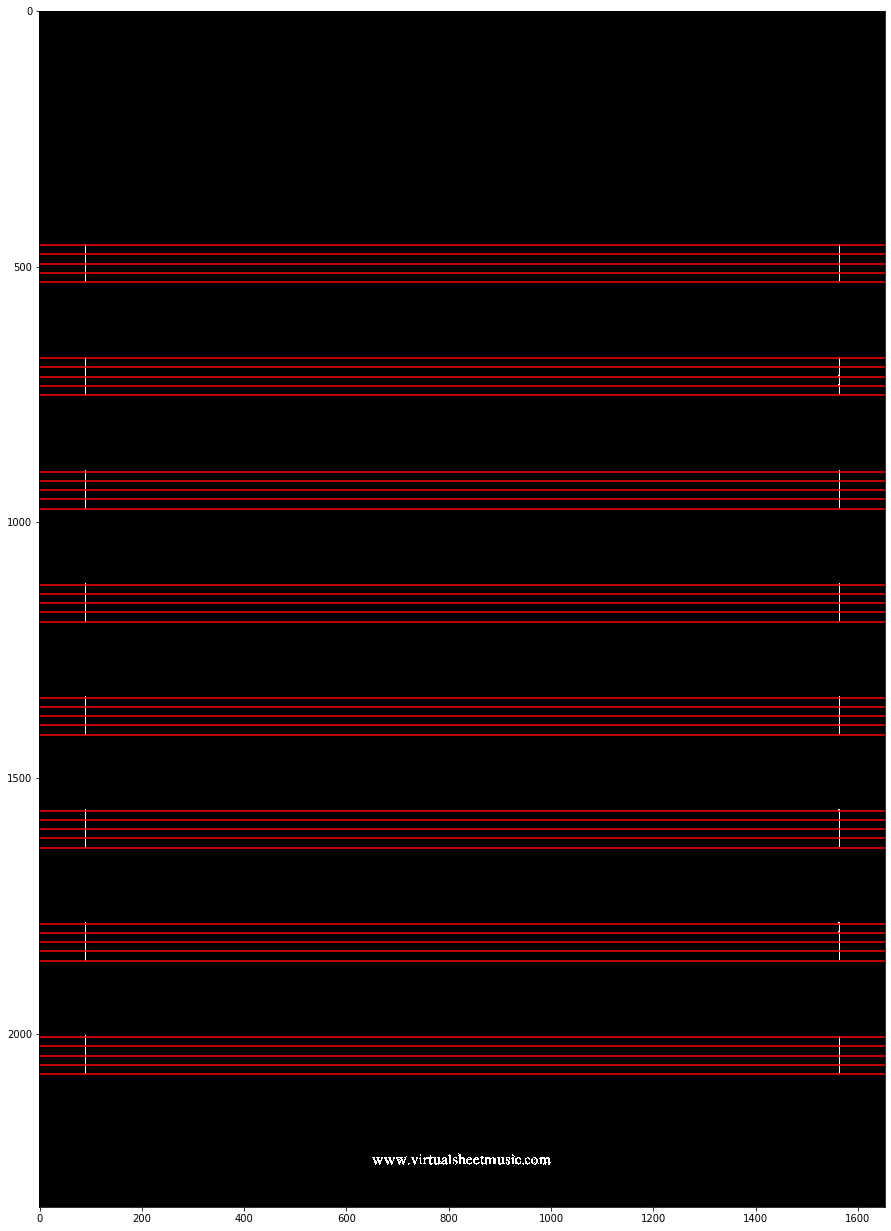

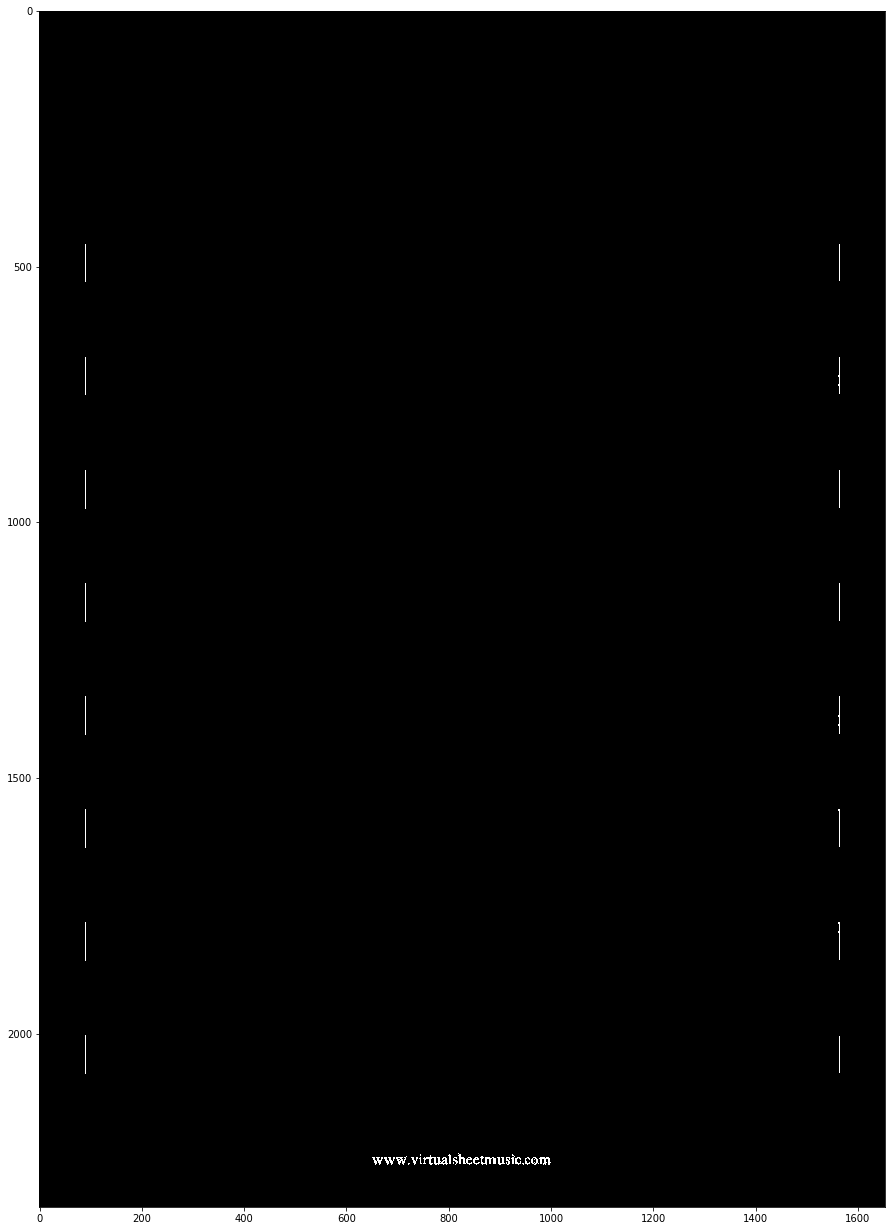

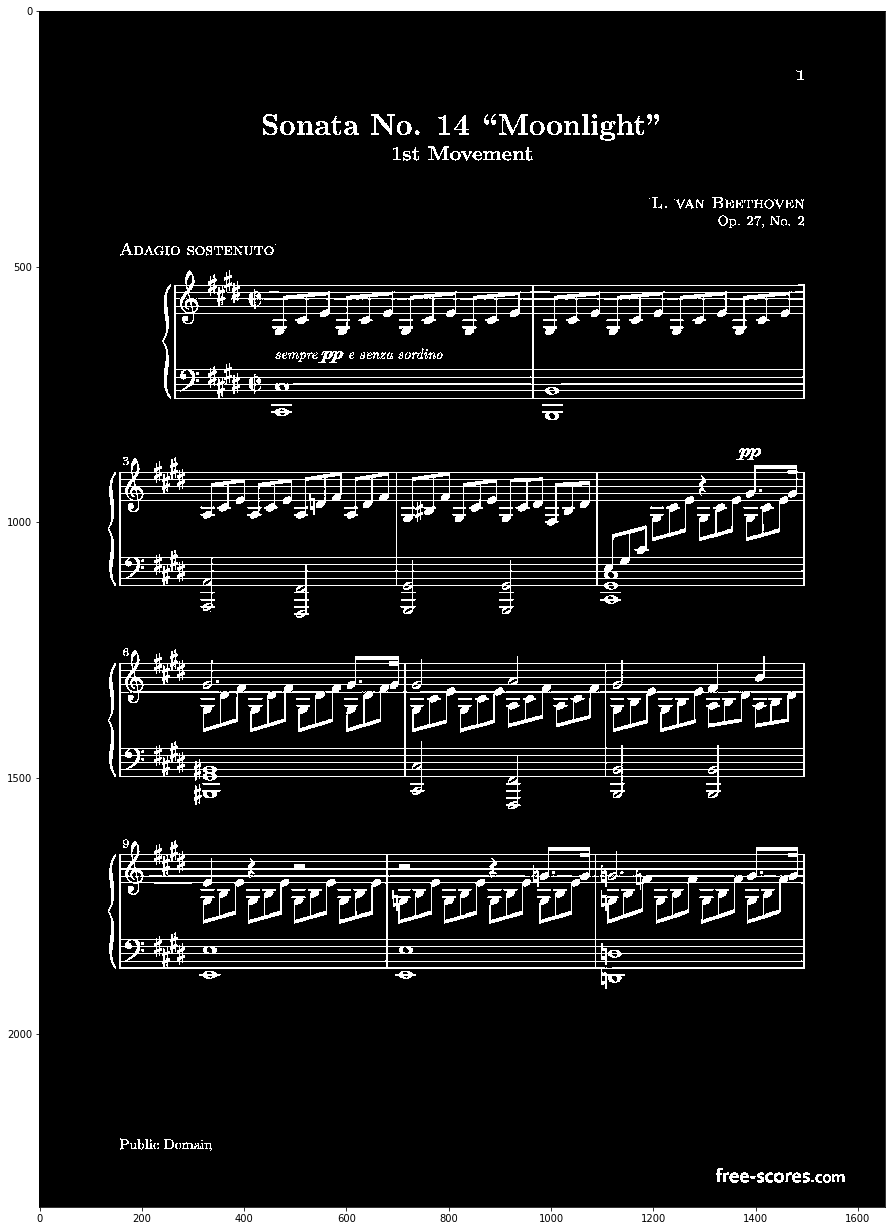

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(535.9547325102881, 1.9349794238683127, 234, 1517)
(549.8446490218643, 1.9781357882623705, 227, 1516)
(563.5997375328084, 2.242782152230971, 224, 1516)
(576.9541984732824, 1.9253604749787956, 224, 1516)
(590.9293680297397, 1.9237918215613383, 225, 1516)
(701.9644012944984, 1.919093851132686, 225, 1516)
(715.9466666666667, 1.92, 224, 1516)
(730.34375, 2.710304054054054, 224, 1516)
(742.9411764705883, 1.934453781512605, 227, 1516)
(756.9620253164557, 1.9311708860759493, 234, 1516)
(901.9658536585366, 1.9292682926829268, 127, 1516)
(915.9478346456693, 1.9015748031496063, 120, 1516)
(929.9521228545619, 1.906052393857272, 117, 1516)
(943.5927152317881, 2.221026490066225, 117, 1516)
(956.9799453053784, 1.9325432999088423, 118, 1516)
(1067.9651250947688, 1.9234268385140258, 118, 1516)
(1081.9594067135051, 1.9188134270101482, 117, 1516)
(1095.9442292796282, 1.9279628195197522, 117, 1516)
(1109.5758962623952, 2.67505

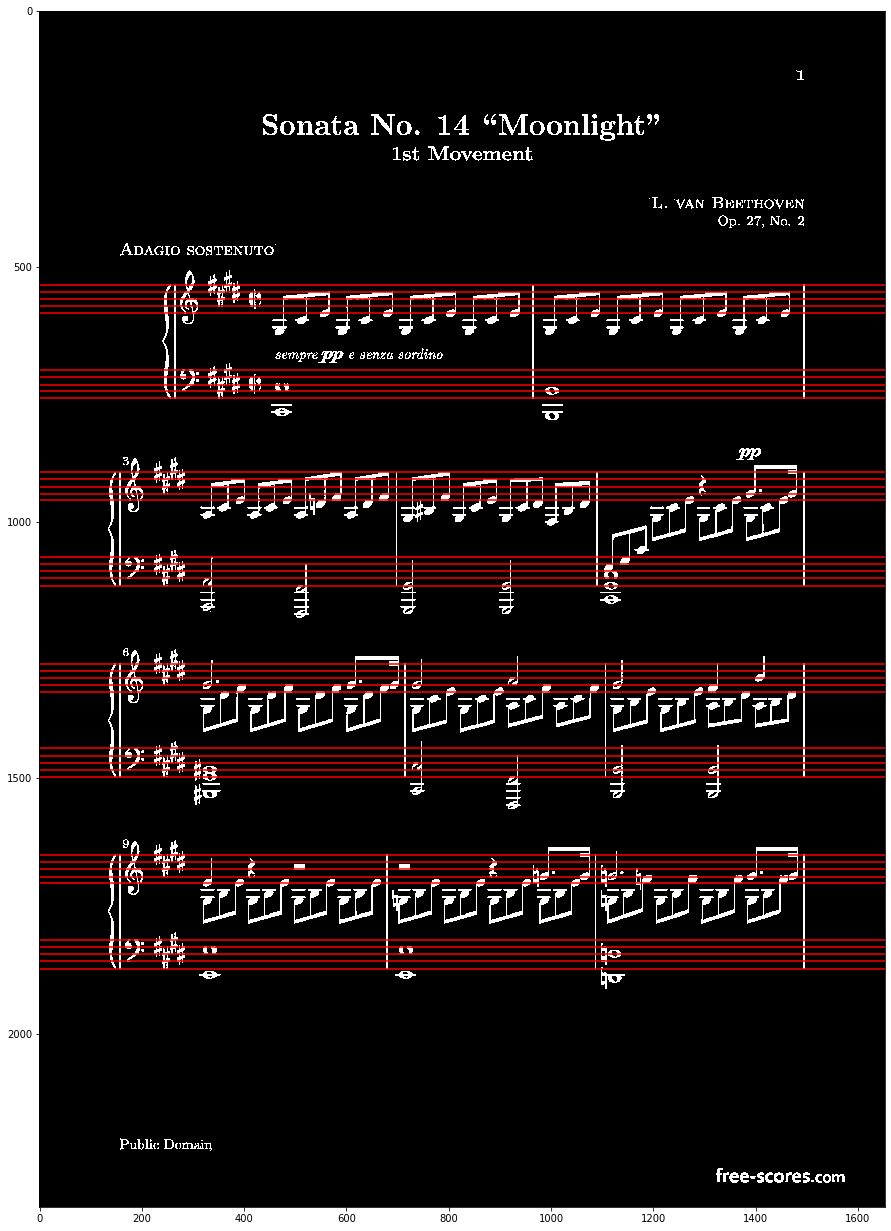

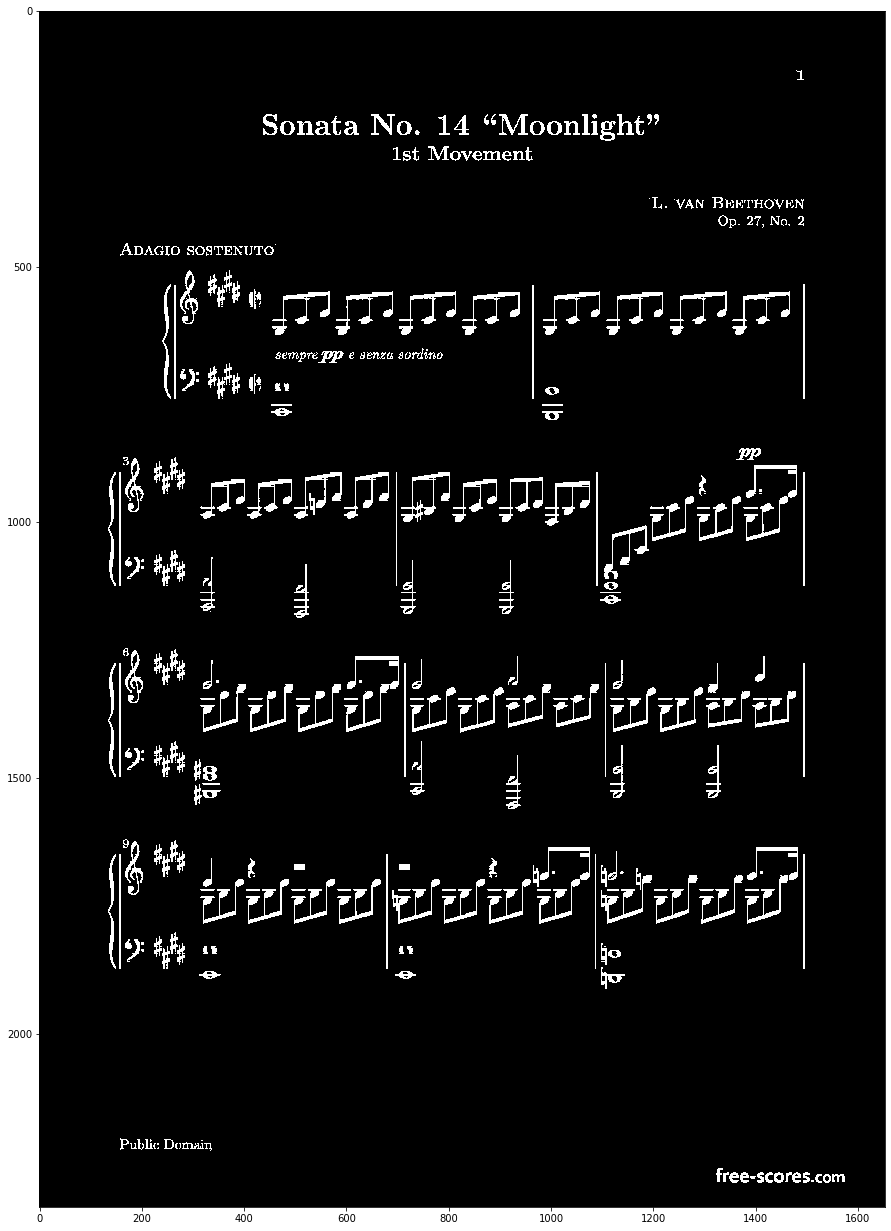

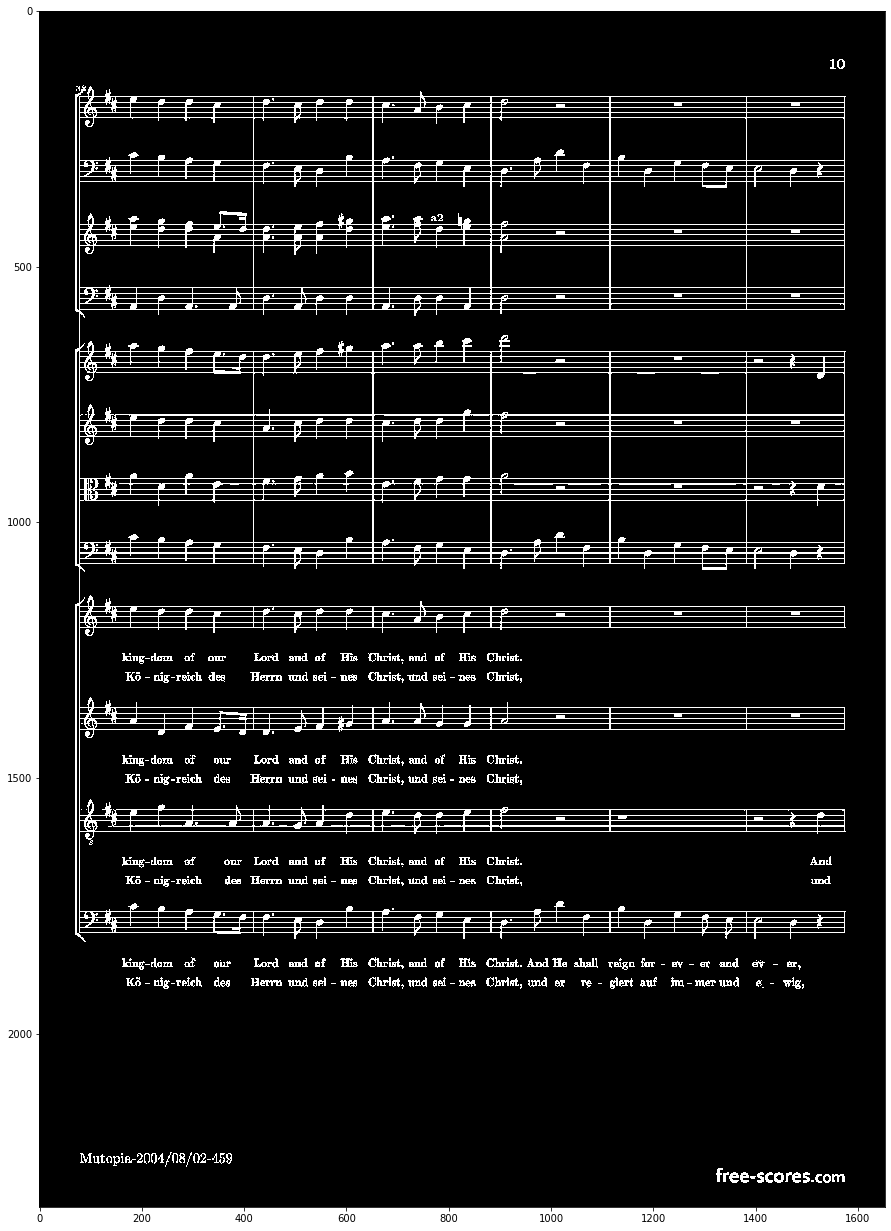

kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec
(167.9707084468665, 1.944141689373297, 50, 1595)
(177.96302003081664, 1.9375963020030817, 50, 1594)
(188.43108504398828, 2.4347507331378297, 50, 1594)
(198.96485182632668, 1.9407305306685045, 50, 1594)
(209.00475866757307, 1.963290278721958, 50, 1594)
(291.95824175824174, 1.9428571428571428, 50, 1594)
(302.96625766871165, 1.9363496932515338, 50, 1594)
(312.9598180439727, 1.9378316906747537, 50, 1594)
(323.42797202797203, 2.472027972027972, 50, 1594)
(333.9679836512262, 1.9448228882833787, 50, 1594)
(416.971820258949, 1.9345011424219345, 50, 1594)
(426.9717425431711, 1.934850863422292, 50, 1594)
(437.96945454545454, 1.9381818181818182, 50, 1594)
(447.96164772727275, 1.9410511363636365, 50, 1594)
(457.96336499321575, 1.9436906377204886, 50, 1594)
(540.9791386271871, 1.946164199192463, 50, 1594)
(551.9726123595506, 1.9410112359550562, 50, 1594)
(561.9594180704441, 1.937978560490046, 50, 1594)
(571.9971448965025

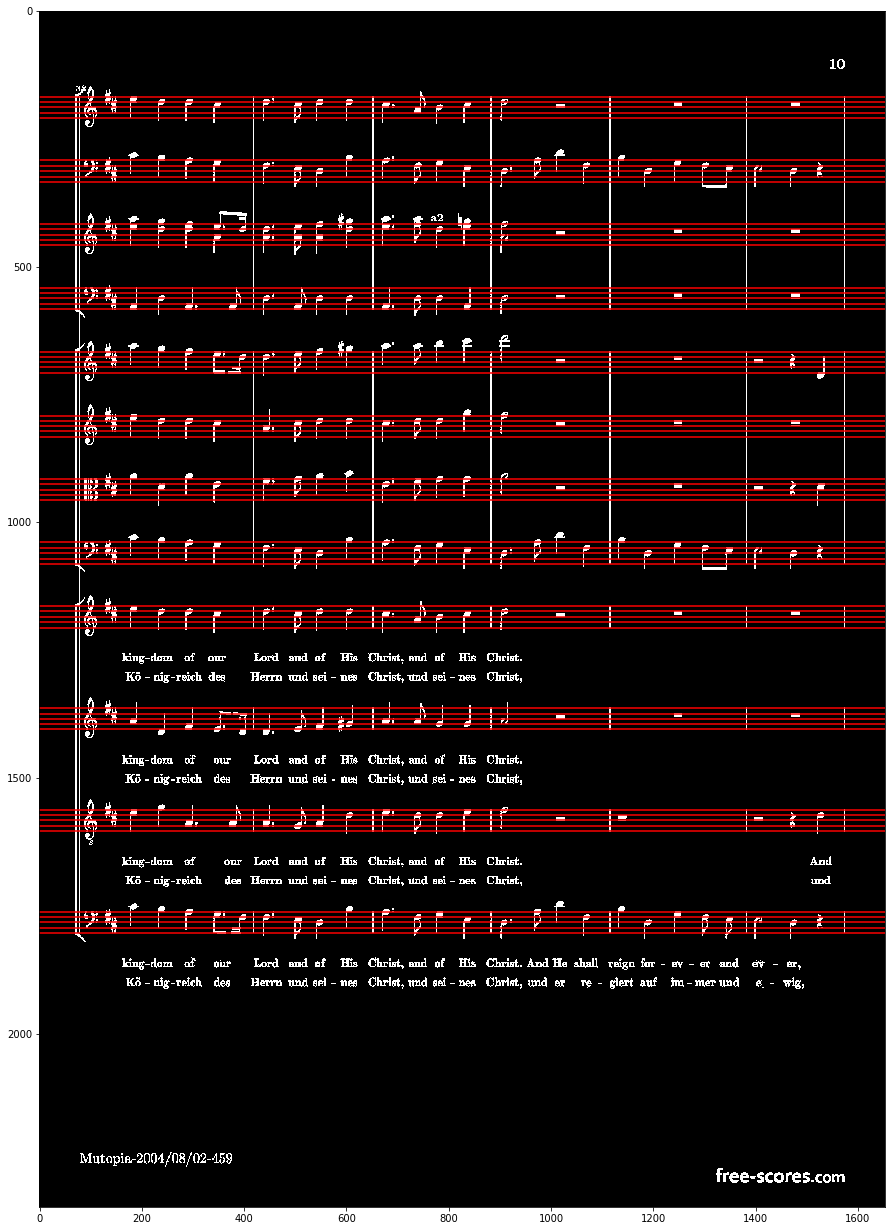

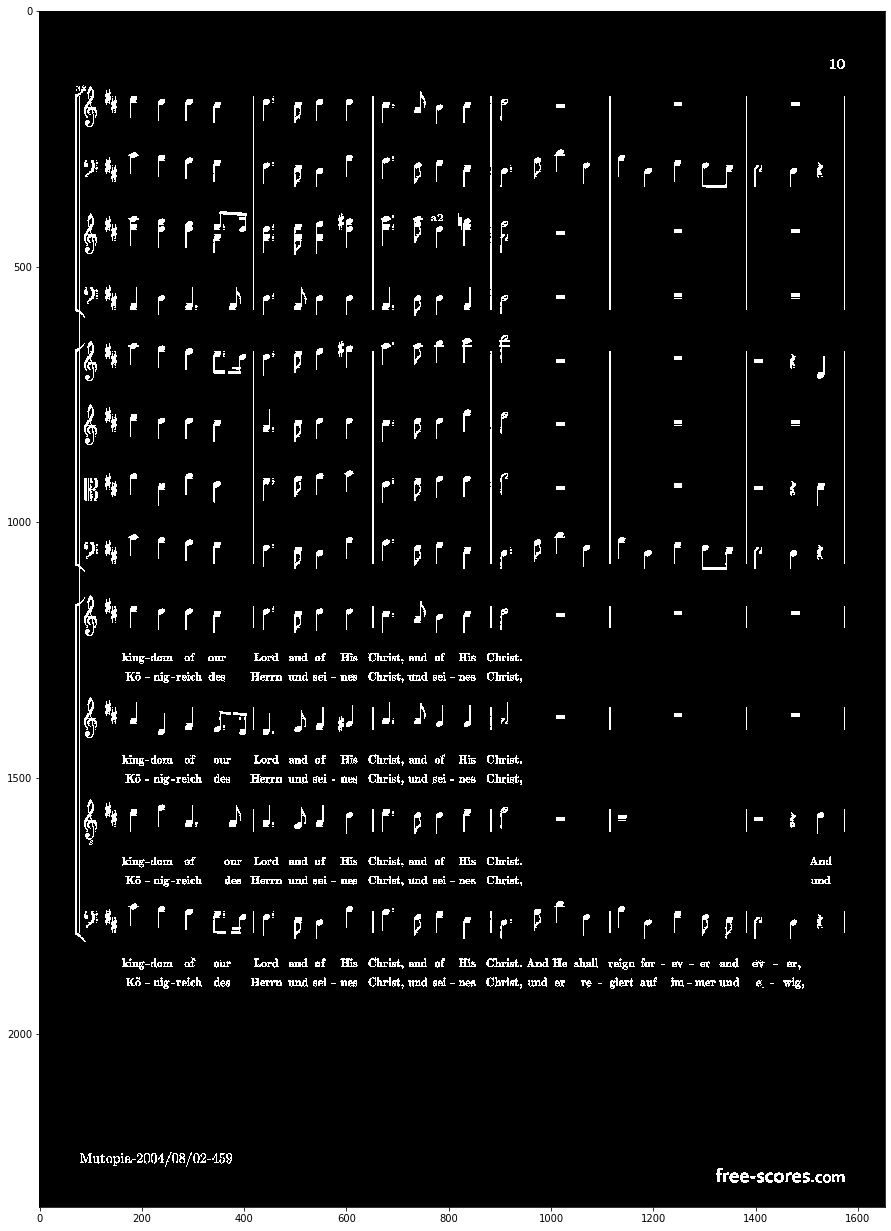

In [30]:
#Bierze imidż zarotowany równolegle do górnej krawędzi obrazka
def distinct(arr):
    st=sorted(arr, key=lambda x:x[0])
    j=0
    dist=1
    while (j<len(arr)):
        if (0.8*arr[0][1]>arr[j][1]):
            break
        if (j>0 and arr[j][0]-arr[j-1][0]>3):
            dist+=1
        j+=1
    return (1 if dist>=5 else 0)
    


def blackening(bwimg, pathway_of_decay):
    s, t, gr=0, 0, 0
    for i in range(len(pathway_of_decay)):
        if (bwimg[pathway_of_decay[i][0]+3, pathway_of_decay[i][1]]==255 and bwimg[pathway_of_decay[i][0]-3, pathway_of_decay[i][1]]):
            t+=1
            for j in range(5):
                if (bwimg[pathway_of_decay[i][0]-2+j, pathway_of_decay[i][1]]==0):
                    s=s+j-2
                    gr+=1
            
            bwimg[pathway_of_decay[i][0], pathway_of_decay[i][1]]=255
            bwimg[pathway_of_decay[i][0]-1, pathway_of_decay[i][1]]=255
            bwimg[pathway_of_decay[i][0]+1, pathway_of_decay[i][1]]=255
            bwimg[pathway_of_decay[i][0]-2, pathway_of_decay[i][1]]=255
            bwimg[pathway_of_decay[i][0]+2, pathway_of_decay[i][1]]=255
    if (t>0):
        s=s/t
        gr=gr/t
    return (pathway_of_decay[i][0]+s, gr)
            
def pathfinder(bwimg, fals, dead, yla, ylc, x):
    slain=0
    im=bwimg[yla:ylc+1,x]
    if (im[1]==255 and (im[0]==0 or im[2]==0)):
        fals+=1
        dead=0
    elif(im[1]==255):
        dead+=1
    else:
        fals, dead=0, 0

    if (fals==3):
        fals=0
        if (im[0]==0):
            yla, ylc=yla-1, ylc-1
        else:
            yla, ylc=yla+1, ylc+1
    if (dead==20):
        dead=0
        slain=1
    return(fals, dead, slain, yla, ylc)
    
def findlinez(bwimg):
    y=0
    x1=bwimg.shape[1]//2-2
    x2=bwimg.shape[1]//2+2
    solution=[]
    
    while (y<bwimg.shape[0]):
        vs=bwimg[y,x1:x2+1]
        if (0 in vs):
            xl=bwimg.shape[1]//2
            yla, ylc=y-1, y+1
            xr=xl
            
            pathway=[]
            fals, dead, slain=0, 0, 0
            while (xl>0):
                fals, dead, slain, yla, ylc=pathfinder(bwimg, fals, dead, yla, ylc, xl)
                pathway.append((yla+1, xl))
                if (slain==1):
                    break
                xl-=1
            
            fals, dead, slain=0, 0, 0
            yla, ylc=y-1, y+1
            while (xr<bwimg.shape[1]):
                fals, dead, slain, yla, ylc=pathfinder(bwimg, fals, dead, yla, ylc, xr)
                pathway.append((yla+1, xr))
                if (slain==1):
                    break
                xr+=1
            if (xr-xl>1000):
                sv, gr=blackening(bwimg, pathway)
                solution.append((sv, gr, xl, xr))
                
        y+=1
    return solution


kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])

for i in range(20):
    ###BINARIZATION
    img=f[i].copy()
    mg=cv.filter2D(img, -1, kernel[5])
    mg2=cv.filter2D(img, -1, kernel[4])
    #mg=cv.filter2D(mg, -1, kernel[5])
    im2=cv.filter2D(mg, -1, kernel[2])
    im3=cv.filter2D(mg2, -1, kernel[1])
    #grave(im2, 1)
    #grave(im3, 1)
    im4=cv.filter2D(im3, -1, kernel[7])
    #grave(im4, 1)
    
    img2=cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 1)
    #img2[im4<140]=255
    #grave(img2, 1)
    #grave(img, 1)
    
    
    
    ###Linez - Only horizontal hier - to będzie później
    ##
    ##
    
    fig, ax=plt.subplots(1,1,figsize=(22,22))    
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()
    
    ###DETECTION
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    sol=findlinez(img2)
    #sol - lista tupli - 1-wszy to uśrednione miejsce linii pięciolinii, 2-gi to grubość linii
    print('kolejno: wysokość wiersza, grubość wiersza, kolumna od lewej: początek, koniec')
    for x in sol:
        ax.axhline(x[0], color=(1,0,0))
        print(x)
    print('liczba liń z pięcioliń: {} (jak podzielna przez 5 to pewnie się zgadza)'.format(len(sol)))
        
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()
    
    
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()

In [ ]:
#### 

In [ ]:
##Bardzo efektywny do pdfów
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])


for i in range(j):
    img=f[i].copy()
    grayscaled = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img2=cv.adaptiveThreshold(grayscaled, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 35, 1)
    grave(img2)
    grave(img)
    
    
    
    
#To idzie do lamusa
def detect_5(bwimg):
    cs=0
    jj=0
    bethon=[0]*1000
    x=0
    cdis=80
    v1, v2=10, cdis+10
    
    while (x<len(bwimg)-v1):
        svv=((255-bwimg[x:x+cdis,:])//255).astype('int32')
        svg=(sorted(np.sum(svv, axis=1), reverse=1))
        stv=zip(range(x, x+cdis), np.sum(svv, axis=1))
        stv=(sorted(stv, key=lambda x:x[1], reverse=1))
        
        svv2=((255-bwimg[x+v1:x+v2,:])//255).astype('int32')
        svg2=(sorted(np.sum(svv2, axis=1), reverse=1))
        stv2=zip(range(x+v1, x+v2), np.sum(svv2, axis=1))
        stv2=(sorted(stv2, key=lambda x:x[1], reverse=1))
        
        #Ta heura na razie jest koszmarna i nieuniwersalizowalna, choć idea pewnie dobra
        if (len(svg2)>5 and svg[4]==svg2[4] and svg[4]>0.6*bwimg.shape[1] and distinct(stv)==1):
            bethon[jj]=(x+5, x+cdis+5, stv2[:15])
            jj+=1
            x+=cdis
        else:
            x+=1
    return (bethon[:jj])